In [1]:
# import necessary modules
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import os
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# listing files
files = os.listdir("C:/Users/manas/Desktop/Springboard/Capstone ideas/Home credit default risk/Data")
print(files)
# training data
path = 'C:/Users/manas/Desktop/Springboard/Capstone ideas/Home credit default risk/Data/'
app_train = pd.read_csv(path + files[1])
print('training dataset shape:', app_train.shape)
#print(app_train.columns)
app_test = pd.read_csv(path + files[0])
print('test dataset shape:', app_test.shape)

['application_test.csv', 'application_train.csv', 'bureau.csv', 'bureau_balance.csv', 'credit_card_balance.csv', 'HomeCredit_columns_description.csv', 'installments_payments.csv', 'POS_CASH_balance.csv', 'previous_application.csv', 'sample_submission.csv']
training dataset shape: (307511, 122)
test dataset shape: (48744, 121)


There are 8 data files + 1 description file (HomeCredit_columns_description.csv) and 1 submission file (sample_submission.csv). Training dataset (application_train) has 122 variables including the target ofcourse.

In [482]:
bureau = pd.read_csv(path + files[2])
bureau_bal = pd.read_csv(path + files[3])
credit_bal = pd.read_csv(path + files[4])
inst_pay = pd.read_csv(path + files[6])
cash_bal = pd.read_csv(path + files[7])
prev_app = pd.read_csv(path + files[8])

In [4]:
print('bureau shape:', bureau.shape)
print('bureau_bal shape:', bureau_bal.shape)
print('credit_bal shape:', credit_bal.shape)
print('inst_pay shape:', inst_pay.shape) 
print('cash_bal shape:', cash_bal.shape)
print('prev_app shape:', prev_app.shape)

bureau shape: (1716428, 17)
bureau_bal shape: (27299925, 3)
credit_bal shape: (3840312, 23)
inst_pay shape: (13605401, 8)
cash_bal shape: (10001358, 8)
prev_app shape: (1670214, 37)


Structure of other dataset files are here, which we would look into little later. First we would focus on the missing data.

## Missing values in the given datasets

In [4]:
## Missing values in appication_train
print('Total number of variables:', app_train.shape[1])
miss_val = app_train.isnull().sum() # number of missing value in each col
miss_val = miss_val.sort_values(ascending=False) # sorting from max to min
miss_list = list(miss_val)
ind = miss_list.index(0)
miss_var = miss_val[0:ind] # only variables with missing values
print('Out of', app_train.shape[1], ', number of variables with missing values:', ind)

percent_miss = miss_var/len(app_train) * 100 # percent missing value for each variable
percents =[10 , 30, 50]
for percent in percents:
    for i in range(len(percent_miss)):
        if percent_miss.sort_values()[i] > percent:
            print('Out of', ind, ', there are', ind-i, 'variables with more than', percent, '% missing values')
            break

Total number of variables: 122
Out of 122 , number of variables with missing values: 67
Out of 67 , there are 57 variables with more than 10 % missing values
Out of 67 , there are 50 variables with more than 30 % missing values
Out of 67 , there are 41 variables with more than 50 % missing values


In [173]:
# save to csv (miss_val_train.csv): variables with missing values in app_train
percent_miss = percent_miss.sort_values(ascending=False)
miss_var_sort = percent_miss.index
# C:\Users\manas\Desktop\Springboard\Capstone ideas\Home credit default risk
filepath = "C:/Users/manas/Desktop/Springboard/Capstone ideas/Home credit default risk/miss_val_train.csv"
df = pd.DataFrame(percent_miss)
df.to_csv(filepath, header='missing', index=True, index_label='variable')

Discussion
Among 122 variables 67 variables have missing values. 57 variables have more than 10% value missing, 50 variables have more than 30% values missing, and 41 variables have more than 50% values missing. So, a large number of variables missing values. How can we deal with those missing values??

In [483]:
## Missing values in other datasets
var_names = [app_test, bureau, bureau_bal, credit_bal, inst_pay, cash_bal, prev_app]
names = ['app_test', 'bureau', 'bureau_bal', 'credit_bal', 'inst_pay', 'cash_bal', 'prev_app']
## Missing values in bureau
for i in range(len(var_names)):
    print('Name of the variable is:', names[i])
    print('Total number of features:', var_names[i].shape[1])
    miss_val = var_names[i].isnull().sum() # number of missing value in each col
    miss_val = miss_val.sort_values(ascending=False) # sorting from max to min
    miss_list = list(miss_val)
    ind = miss_list.index(0)
    miss_var = miss_val[0:ind] # only variables with missing values
    print('Out of', var_names[i].shape[1], ', number of variables with missing values:', ind)

    percent_miss = miss_var/len(var_names[i]) * 100 # percent missing value for each variable
    percents =[10 , 30, 50]
    for percent in percents:
        for i in range(len(percent_miss)):
            if percent_miss.sort_values()[i] > percent:
                print('Out of', ind, ', there are', ind-i, 'variables with more than', percent, '% missing values')
                break
    print(percent_miss.head())
    print('----------------------------------------------------------------------------------------')

Name of the variable is: app_test
Total number of features: 121
Out of 121 , number of variables with missing values: 64
Out of 64 , there are 57 variables with more than 10 % missing values
Out of 64 , there are 50 variables with more than 30 % missing values
Out of 64 , there are 29 variables with more than 50 % missing values
COMMONAREA_MEDI             68.716150
COMMONAREA_AVG              68.716150
COMMONAREA_MODE             68.716150
NONLIVINGAPARTMENTS_MODE    68.412523
NONLIVINGAPARTMENTS_MEDI    68.412523
dtype: float64
----------------------------------------------------------------------------------------
Name of the variable is: bureau
Total number of features: 17
Out of 17 , number of variables with missing values: 7
Out of 7 , there are 5 variables with more than 10 % missing values
Out of 7 , there are 4 variables with more than 30 % missing values
Out of 7 , there are 2 variables with more than 50 % missing values
AMT_ANNUITY               71.473490
AMT_CREDIT_MAX_OVER

Many variables have missing data and in significnat amount. How to deal with them depends on the variable type and its significance.

## Variable type in application_train dataset

In [486]:
# app_train variable type, object type are categorical variables
print('Variable types are:\n', app_train.dtypes.value_counts()) # variable type: integer, float, categorical
obj = app_train.select_dtypes('object') # selcting only categorical variable
obj_uni = obj.apply(pd.Series.nunique, axis=0) # unique values in category
print('\nUnique values in categorical variables are:\n', obj_uni.sort_values())
var_float = app_train.select_dtypes('float64')
print('\nVariables with float outcome:\n', var_float.columns)
var_int = app_train.select_dtypes('int64')
print('\nVariables with integer outcome:\n', var_int.columns)
var_int_uni = var_int.apply(pd.Series.nunique, axis=0)
print('\nUnique values in integer variables:', var_int_uni.sort_values())

Variable types are:
 float64    65
int64      41
object     16
dtype: int64

Unique values in categorical variables are:
 NAME_CONTRACT_TYPE             2
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
EMERGENCYSTATE_MODE            2
CODE_GENDER                    3
HOUSETYPE_MODE                 3
FONDKAPREMONT_MODE             4
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
NAME_TYPE_SUITE                7
WEEKDAY_APPR_PROCESS_START     7
WALLSMATERIAL_MODE             7
NAME_INCOME_TYPE               8
OCCUPATION_TYPE               18
ORGANIZATION_TYPE             58
dtype: int64

Variables with float outcome:
 Index(['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE',
       'REGION_POPULATION_RELATIVE', 'DAYS_REGISTRATION', 'OWN_CAR_AGE',
       'CNT_FAM_MEMBERS', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3',
       'APARTMENTS_AVG', 'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG',
       

There are 3 variable types in application train: 65 float, 41 integer, and 16 object (categorical). Among the categorical variables 15 variables have less than 7 unique values. Categorical variables can be presented using bar plots. Among 41 integer variables 35 have less than or equal to 3 unique values. So it would be best to present them with bar plots. The float type variables and integer type with higher number of unique values can be presented using distribution.

## Frequency distribution of variables in application_train dataset

First we will look into the target data, whether a applicant has repaid a loan (marked as '0') or not (as '1'). All other variables would be grouped seperately based on this variable.

In [3]:
target_val = app_train['TARGET'].value_counts()
print(target_val)
print('% repaid loan: {:05.2f}'.format(target_val[0]/(target_val[0] + target_val[1])*100)) 
print('% difficulty in loan repayment: {:04.2f}'.format(target_val[1]/(target_val[0] + target_val[1])*100))


0    282686
1     24825
Name: TARGET, dtype: int64
% repaid loan: 91.93
% difficulty in loan repayment: 8.07


Discussion: Among 307511 applicants, 282686 (92%) repaid the loan on time. 24825 (8%) had difficulties in repaying. 

### Check for each variable:
1. variable type: float/integer/categorical
2. % missing data
3. Any anomaly?
4. If integer/categorical unique value types
5. distribution/percentage 
6. standard deviation for numerical value/ gini impurities for categorical values

## Variable type: float

Float variable name: AMT_INCOME_TOTAL
% missing value 0.0


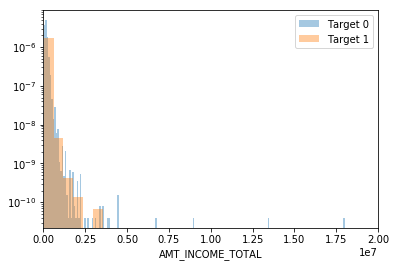

       AMT_INCOME_TOTAL_TARGET_0  AMT_INCOME_TOTAL_TARGET_1
count               2.826860e+05               2.482500e+04
mean                1.690777e+05               1.656118e+05
std                 1.104763e+05               7.466770e+05
min                 2.565000e+04               2.565000e+04
25%                 1.125000e+05               1.125000e+05
50%                 1.485000e+05               1.350000e+05
75%                 2.025000e+05               2.025000e+05
max                 1.800009e+07               1.170000e+08


In [646]:
var_names = var_float.columns
var_n = var_names[0]
print('Float variable name:', var_n)
# % missing value
print('% missing value', app_train[var_n].isnull().sum()/len(app_train[var_n]) * 100)

# distribution of variable:
A = app_train.loc[app_train['TARGET'] == 0, var_n]
B = app_train.loc[app_train['TARGET'] == 1, var_n]
var = (var_float.groupby([app_train['TARGET']])[var_n].value_counts(normalize=True)
       .rename('percentage').mul(100).reset_index().sort_values(var_n))
plt.rcParams['figure.figsize'] = 6,4
sns.distplot(A, bins=200, hist=True, kde=False, norm_hist=True, label='Target 0')
sns.distplot(B, bins=200, hist=True, kde=False, norm_hist=True, label='Target 1')
#plt.xscale('log')
plt.yscale('log')
plt.xlim(0, 20000000)
plt.legend(loc='upper right')
plt.show()
# Statistical summary
# with target '0'
target_0_des = app_train.loc[app_train['TARGET'] == 0, var_n].describe().rename('AMT_INCOME_TOTAL_TARGET_0')
# with target '1'
target_1_des = app_train.loc[app_train['TARGET'] == 1, var_n].describe().rename('AMT_INCOME_TOTAL_TARGET_1')
print(pd.concat([target_0_des, target_1_des], axis=1))


When seen on log scale we can see the difference in values for Target 0 and 1. kde plot is not used here as the values were much discrete. The kde plot was not realistic. While this seems to be the most important parameter in repaying loan, it does not reflect so. 

Float variable name: AMT_CREDIT
% missing value 0.0


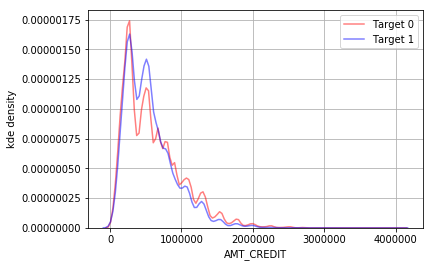

,AMT_CREDIT_TARGET_0,AMT_CREDIT_TARGET_1
count,2.826860e+05,2.482500e+04
mean,6.026483e+05,5.577785e+05
std,4.068459e+05,3.464332e+05
min,4.500000e+04,4.500000e+04
25%,2.700000e+05,2.844000e+05
50%,5.177880e+05,4.975200e+05
75%,8.100000e+05,7.333155e+05
max,4.050000e+06,4.027680e+06


In [503]:
var_names = var_float.columns
var = var_names[1]
print('Float variable name:', var)
# % missing value
print('% missing value', app_train[var].isnull().sum()/len(app_train[var]))
# distribution of variable:
sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, var], label = 'Target 0', color='red', alpha=0.5)
sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, var], label = 'Target 1', color='blue', alpha=0.5)
plt.xlabel(var)
plt.ylabel('kde density')
#plt.yscale('log')
plt.grid(True)
plt.rcParams['figure.figsize'] = 4,4
plt.show()

# Statistical summary
# with target '0'
target_0_des = app_train.loc[app_train['TARGET'] == 0, var].describe().rename('AMT_CREDIT_TARGET_0')
#print('Target 0:', target_0_des)
# with target '1'
target_1_des = app_train.loc[app_train['TARGET'] == 1, var].describe().rename('AMT_CREDIT_TARGET_1')
#print('Target 1:', target_1_des)
pd.concat([target_0_des, target_1_des], axis=1)

Float variable name: AMT_ANNUITY
% missing value 0.003902299429939092


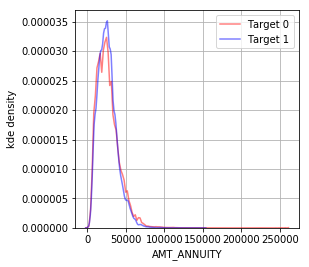

,AMT_ANNUITY_TARGET_0,AMT_ANNUITY_TARGET_1
count,282674.000000,24825.000000
mean,27163.623349,26481.744290
std,14658.307178,12450.676999
min,1615.500000,2722.500000
25%,16456.500000,17361.000000
50%,24876.000000,25263.000000
75%,34749.000000,32976.000000
max,258025.500000,149211.000000


In [199]:
var_names = var_float.columns
var = var_names[2]
print('Float variable name:', var)
# % missing value
print('% missing value', app_train[var].isnull().sum()/len(app_train[var])* 100)
# distribution of variable:
sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, var], label = 'Target 0', color='red', alpha=0.5)
sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, var], label = 'Target 1', color='blue', alpha=0.5)
plt.xlabel(var)
plt.ylabel('kde density')
#plt.yscale('log')
plt.grid(True)
plt.rcParams['figure.figsize'] = 4,4
plt.show()

# Statistical summary
# with target '0'
target_0_des = app_train.loc[app_train['TARGET'] == 0, var].describe().rename('AMT_ANNUITY_TARGET_0')
#print('Target 0:', target_0_des)
# with target '1'
target_1_des = app_train.loc[app_train['TARGET'] == 1, var].describe().rename('AMT_ANNUITY_TARGET_1')
#print('Target 1:', target_1_des)
pd.concat([target_0_des, target_1_des], axis=1)

Float variable name: AMT_GOODS_PRICE
% missing value 0.09040327012692229


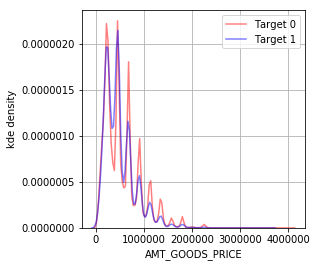

,AMT_GOODS_PRICE_TARGET_0,AMT_GOODS_PRICE_TARGET_1
count,2.824290e+05,2.480400e+04
mean,5.427368e+05,4.889724e+05
std,3.737855e+05,3.116365e+05
min,4.050000e+04,4.500000e+04
25%,2.385000e+05,2.385000e+05
50%,4.500000e+05,4.500000e+05
75%,6.885000e+05,6.750000e+05
max,4.050000e+06,3.600000e+06


In [200]:
var_names = var_float.columns
var = var_names[3]
print('Float variable name:', var)
# % missing value
print('% missing value', app_train[var].isnull().sum()/len(app_train[var])* 100)
# distribution of variable:
sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, var], label = 'Target 0', color='red', alpha=0.5)
sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, var], label = 'Target 1', color='blue', alpha=0.5)
plt.xlabel(var)
plt.ylabel('kde density')
#plt.yscale('log')
plt.grid(True)
plt.rcParams['figure.figsize'] = 4,4
plt.show()

# Statistical summary
# with target '0'
target_0_des = app_train.loc[app_train['TARGET'] == 0, var].describe().rename('AMT_GOODS_PRICE_TARGET_0')
#print('Target 0:', target_0_des)
# with target '1'
target_1_des = app_train.loc[app_train['TARGET'] == 1, var].describe().rename('AMT_GOODS_PRICE_TARGET_1')
#print('Target 1:', target_1_des)
pd.concat([target_0_des, target_1_des], axis=1)

Float variable name: REGION_POPULATION_RELATIVE
% missing value 0.0


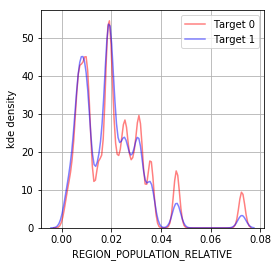

,REGION_POPULATION_RELATIVE_TARGET_0,REGION_POPULATION_RELATIVE_TARGET_1
count,282686.000000,24825.000000
mean,0.021021,0.019131
std,0.013978,0.011905
min,0.000290,0.000533
25%,0.010006,0.009630
50%,0.018850,0.018634
75%,0.028663,0.025164
max,0.072508,0.072508


In [222]:
var_names = var_float.columns
var = var_names[4]
print('Float variable name:', var)
# % missing value
print('% missing value', app_train[var].isnull().sum()/len(app_train[var])* 100)
# distribution of variable:
sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, var], label = 'Target 0', color='red', alpha=0.5)
sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, var], label = 'Target 1', color='blue', alpha=0.5)
plt.xlabel(var)
plt.ylabel('kde density')
#plt.yscale('log')
plt.grid(True)
plt.rcParams['figure.figsize'] = 4,4
plt.show()

# Statistical summary
# with target '0'
target_0_des = app_train.loc[app_train['TARGET'] == 0, var].describe().rename('REGION_POPULATION_RELATIVE_TARGET_0')
#print('Target 0:', target_0_des)
# with target '1'
target_1_des = app_train.loc[app_train['TARGET'] == 1, var].describe().rename('REGION_POPULATION_RELATIVE_TARGET_1')
#print('Target 1:', target_1_des)
pd.concat([target_0_des, target_1_des], axis=1)

Float variable name: DAYS_REGISTRATION
% missing value 0.0


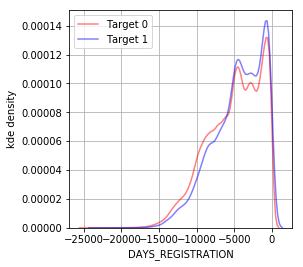

,DAYS_REGISTRATION_TARGET_0,DAYS_REGISTRATION_TARGET_1
count,282686.000000,24825.000000
mean,-5029.941065,-4487.127009
std,3538.464478,3299.650241
min,-24672.000000,-22928.000000
25%,-7550.000000,-6646.000000
50%,-4544.000000,-4056.000000
75%,-2045.000000,-1671.000000
max,0.000000,0.000000


In [224]:
var_names = var_float.columns
var = var_names[5]
print('Float variable name:', var)
# % missing value
print('% missing value', app_train[var].isnull().sum()/len(app_train[var])* 100)
# distribution of variable:
sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, var], label = 'Target 0', color='red', alpha=0.5)
sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, var], label = 'Target 1', color='blue', alpha=0.5)
plt.xlabel(var)
plt.ylabel('kde density')
#plt.yscale('log')
plt.grid(True)
plt.rcParams['figure.figsize'] = 4,4
plt.show()

# Statistical summary
# with target '0'
target_0_des = app_train.loc[app_train['TARGET'] == 0, var].describe().rename('DAYS_REGISTRATION_TARGET_0')
#print('Target 0:', target_0_des)
# with target '1'
target_1_des = app_train.loc[app_train['TARGET'] == 1, var].describe().rename('DAYS_REGISTRATION_TARGET_1')
#print('Target 1:', target_1_des)
pd.concat([target_0_des, target_1_des], axis=1)

Float variable name: OWN_CAR_AGE
% missing value 65.9908100848425


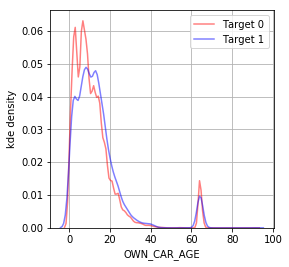

,OWN_CAR_AGE_TARGET_0,OWN_CAR_AGE_TARGET_1
count,97006.000000,7576.000000
mean,11.935540,13.668691
std,11.891359,12.499074
min,0.000000,0.000000
25%,5.000000,6.000000
50%,9.000000,11.000000
75%,15.000000,17.000000
max,91.000000,91.000000


In [226]:
var_names = var_float.columns
var = var_names[6]
print('Float variable name:', var)
# % missing value
print('% missing value', app_train[var].isnull().sum()/len(app_train[var])* 100)
# distribution of variable:
sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, var], label = 'Target 0', color='red', alpha=0.5)
sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, var], label = 'Target 1', color='blue', alpha=0.5)
plt.xlabel(var)
plt.ylabel('kde density')
#plt.yscale('log')
plt.grid(True)
plt.rcParams['figure.figsize'] = 4,4
plt.show()

# Statistical summary
# with target '0'
target_0_des = app_train.loc[app_train['TARGET'] == 0, var].describe().rename('OWN_CAR_AGE_TARGET_0')
#print('Target 0:', target_0_des)
# with target '1'
target_1_des = app_train.loc[app_train['TARGET'] == 1, var].describe().rename('OWN_CAR_AGE_TARGET_1')
#print('Target 1:', target_1_des)
pd.concat([target_0_des, target_1_des], axis=1)

This variable has 66% missing data. However the distribution looks similar for target 1 and 0.

Float variable name: CNT_FAM_MEMBERS
% missing value 0.0006503832383231819


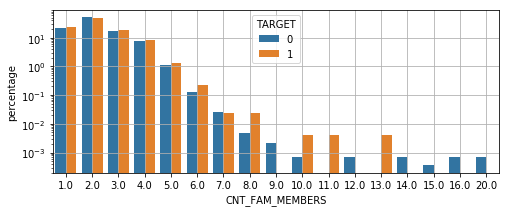


Group summary
     TARGET  CNT_FAM_MEMBERS  percentage
1        0              1.0   21.993463
16       1              1.0   22.860020
0        0              2.0   51.770882
15       1              2.0   48.374622
2        0              3.0   16.977615
17       1              3.0   18.561934
3        0              4.0    7.980996
18       1              4.0    8.604230
4        0              5.0    1.114672
19       1              5.0    1.317221
20       1              6.0    0.221551
5        0              6.0    0.124874
21       1              7.0    0.024169
6        0              7.0    0.026531
22       1              8.0    0.024169
7        0              8.0    0.004953
8        0              9.0    0.002123
23       1             10.0    0.004028
9        0             10.0    0.000708
24       1             11.0    0.004028
10       0             12.0    0.000708
25       1             13.0    0.004028
11       0             14.0    0.000708
14       0             1

In [509]:
var_names = var_float.columns
var = var_names[7]
print('Float variable name:', var)
# % missing value
print('% missing value', app_train[var].isnull().sum()/len(app_train[var])* 100)
# distribution of variable:
var_n = (var_float.groupby([app_train['TARGET']])[var_names[7]].value_counts(normalize=True).rename('percentage').mul(100).reset_index().sort_values(var_names[7]))
plt.rcParams['figure.figsize'] = 8,3
sns.barplot(x='CNT_FAM_MEMBERS', y='percentage', hue='TARGET', data=var_n)
plt.grid(True)
plt.yscale('log')
plt.show()

# Statistical summary
# with target '0'
target_0_des = app_train.loc[app_train['TARGET'] == 0, var].describe().rename('CNT_FAM_MEMBERS_TARGET_0')
#print('Target 0:', target_0_des)
# with target '1'
target_1_des = app_train.loc[app_train['TARGET'] == 1, var].describe().rename('CNT_FAM_MEMBERS_TARGET_1')
#print('Target 1:', target_1_des)
pd.concat([target_0_des, target_1_des], axis=1)
print('\nGroup summary\n', var_n)

Float variable name: EXT_SOURCE_1
% missing value 56.381072546998325


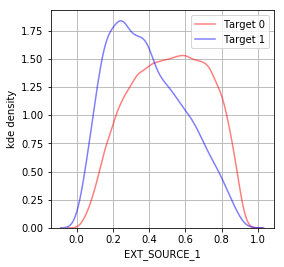

,EXT_SOURCE_1_TARGET_0,EXT_SOURCE_1_TARGET_1
count,124079.000000,10054.000000
mean,0.511461,0.386968
std,0.208804,0.204729
min,0.014568,0.014691
25%,0.345430,0.221847
50%,0.517452,0.361675
75%,0.682839,0.537508
max,0.962693,0.929394


In [232]:
var_names = var_float.columns
var = var_names[8]
print('Float variable name:', var)
# % missing value
print('% missing value', app_train[var].isnull().sum()/len(app_train[var])* 100)
# distribution of variable:
sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, var], label = 'Target 0', color='red', alpha=0.5)
sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, var], label = 'Target 1', color='blue', alpha=0.5)
plt.xlabel(var)
plt.ylabel('kde density')
#plt.yscale('log')
plt.grid(True)
plt.rcParams['figure.figsize'] = 4,4
plt.show()

# Statistical summary
# with target '0'
target_0_des = app_train.loc[app_train['TARGET'] == 0, var].describe().rename('EXT_SOURCE_1_TARGET_0')
#print('Target 0:', target_0_des)
# with target '1'
target_1_des = app_train.loc[app_train['TARGET'] == 1, var].describe().rename('EXT_SOURCE_1_TARGET_1')
#print('Target 1:', target_1_des)
pd.concat([target_0_des, target_1_des], axis=1)

This variable has 56% missing value and as can be seen is important to differentiate between Target 1 and target 0.

Float variable name: EXT_SOURCE_2
% missing value 0.21462646864665005


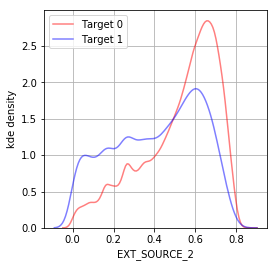

,EXT_SOURCE_2_TARGET_0,EXT_SOURCE_2_TARGET_1
count,2.820780e+05,24773.000000
mean,5.234787e-01,0.410935
std,1.862767e-01,0.213107
min,8.173617e-08,0.000005
25%,4.097866e-01,0.238568
50%,5.739047e-01,0.440381
75%,6.677051e-01,0.594190
max,8.549997e-01,0.811870


In [234]:
var_names = var_float.columns
var = var_names[9]
print('Float variable name:', var)
# % missing value
print('% missing value', app_train[var].isnull().sum()/len(app_train[var])* 100)
# distribution of variable:
sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, var], label = 'Target 0', color='red', alpha=0.5)
sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, var], label = 'Target 1', color='blue', alpha=0.5)
plt.xlabel(var)
plt.ylabel('kde density')
#plt.yscale('log')
plt.grid(True)
plt.rcParams['figure.figsize'] = 4,4
plt.show()

# Statistical summary
# with target '0'
target_0_des = app_train.loc[app_train['TARGET'] == 0, var].describe().rename('EXT_SOURCE_2_TARGET_0')
#print('Target 0:', target_0_des)
# with target '1'
target_1_des = app_train.loc[app_train['TARGET'] == 1, var].describe().rename('EXT_SOURCE_2_TARGET_1')
#print('Target 1:', target_1_des)
pd.concat([target_0_des, target_1_des], axis=1)

Float variable name: EXT_SOURCE_3
% missing value 19.825307062186393


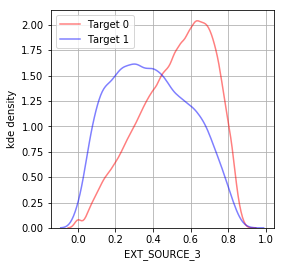

,EXT_SOURCE_3_TARGET_0,EXT_SOURCE_3_TARGET_1
count,227398.000000,19148.000000
mean,0.520969,0.390717
std,0.190465,0.205810
min,0.000527,0.000527
25%,0.385915,0.223831
50%,0.546023,0.379100
75%,0.673830,0.553165
max,0.893976,0.896010


In [236]:
var_names = var_float.columns
var = var_names[10]
print('Float variable name:', var)
# % missing value
print('% missing value', app_train[var].isnull().sum()/len(app_train[var])* 100)
# distribution of variable:
sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, var], label = 'Target 0', color='red', alpha=0.5)
sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, var], label = 'Target 1', color='blue', alpha=0.5)
plt.xlabel(var)
plt.ylabel('kde density')
#plt.yscale('log')
plt.grid(True)
plt.rcParams['figure.figsize'] = 4,4
plt.show()

# Statistical summary
# with target '0'
target_0_des = app_train.loc[app_train['TARGET'] == 0, var].describe().rename('EXT_SOURCE_3_TARGET_0')
#print('Target 0:', target_0_des)
# with target '1'
target_1_des = app_train.loc[app_train['TARGET'] == 1, var].describe().rename('EXT_SOURCE_3_TARGET_1')
#print('Target 1:', target_1_des)
pd.concat([target_0_des, target_1_des], axis=1)

It has 20% missing values. Important variable for target classification. 

Float variable name: APARTMENTS_AVG
% missing value 50.74972927797705


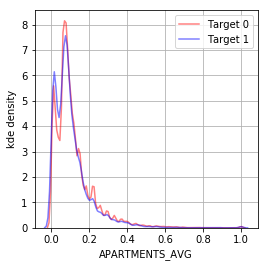

,APARTMENTS_AVG_TARGET_0,APARTMENTS_AVG_TARGET_1
count,140910.000000,10540.000000
mean,0.118314,0.105766
std,0.108715,0.100959
min,0.000000,0.000000
25%,0.058800,0.041200
50%,0.088700,0.082500
75%,0.148500,0.133000
max,1.000000,1.000000


In [238]:
var_names = var_float.columns
var = var_names[11]
print('Float variable name:', var)
# % missing value
print('% missing value', app_train[var].isnull().sum()/len(app_train[var])* 100)
# distribution of variable:
sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, var], label = 'Target 0', color='red', alpha=0.5)
sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, var], label = 'Target 1', color='blue', alpha=0.5)
plt.xlabel(var)
plt.ylabel('kde density')
#plt.yscale('log')
plt.grid(True)
plt.rcParams['figure.figsize'] = 4,4
plt.show()

# Statistical summary
# with target '0'
target_0_des = app_train.loc[app_train['TARGET'] == 0, var].describe().rename('APARTMENTS_AVG_TARGET_0')
#print('Target 0:', target_0_des)
# with target '1'
target_1_des = app_train.loc[app_train['TARGET'] == 1, var].describe().rename('APARTMENTS_AVG_TARGET_1')
#print('Target 1:', target_1_des)
pd.concat([target_0_des, target_1_des], axis=1)

This variable has more than 50% values missing. The distribution looks similar for both targets.

Float variable name: BASEMENTAREA_AVG
% missing value 58.51595552679416


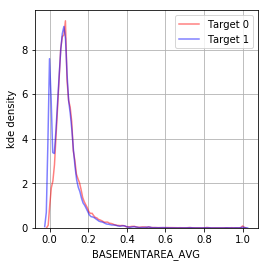

,BASEMENTAREA_AVG_TARGET_0,BASEMENTAREA_AVG_TARGET_1
count,118781.000000,8787.000000
mean,0.088952,0.081548
std,0.082987,0.074289
min,0.000000,0.000000
25%,0.044500,0.039900
50%,0.076500,0.072300
75%,0.112500,0.106100
max,1.000000,1.000000


In [240]:
var_names = var_float.columns
var = var_names[12]
print('Float variable name:', var)
# % missing value
print('% missing value', app_train[var].isnull().sum()/len(app_train[var])* 100)
# distribution of variable:
sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, var], label = 'Target 0', color='red', alpha=0.5)
sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, var], label = 'Target 1', color='blue', alpha=0.5)
plt.xlabel(var)
plt.ylabel('kde density')
#plt.yscale('log')
plt.grid(True)
plt.rcParams['figure.figsize'] = 4,4
plt.show()

# Statistical summary
# with target '0'
target_0_des = app_train.loc[app_train['TARGET'] == 0, var].describe().rename('BASEMENTAREA_AVG_TARGET_0')
#print('Target 0:', target_0_des)
# with target '1'
target_1_des = app_train.loc[app_train['TARGET'] == 1, var].describe().rename('BASEMENTAREA_AVG_TARGET_1')
#print('Target 1:', target_1_des)
pd.concat([target_0_des, target_1_des], axis=1)

More than 58% data are missing 

Float variable name: YEARS_BEGINEXPLUATATION_AVG
% missing value 48.781019215572776


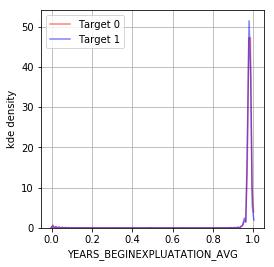

,YEARS_BEGINEXPLUATATION_AVG_TARGET_0,YEARS_BEGINEXPLUATATION_AVG_TARGET_1
count,146487.000000,11017.000000
mean,0.977893,0.975634
std,0.058406,0.069148
min,0.000000,0.000000
25%,0.976700,0.976200
50%,0.982100,0.981100
75%,0.986600,0.986100
max,1.000000,1.000000


In [9]:
var_names = var_float.columns
var = var_names[13]
print('Float variable name:', var)
# % missing value
print('% missing value', app_train[var].isnull().sum()/len(app_train[var])* 100)
# distribution of variable:
sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, var], label = 'Target 0', color='red', alpha=0.5)
sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, var], label = 'Target 1', color='blue', alpha=0.5)
plt.xlabel(var)
plt.ylabel('kde density')
#plt.yscale('log')
plt.grid(True)
plt.rcParams['figure.figsize'] = 4,4
plt.show()

# Statistical summary
# with target '0'
target_0_des = app_train.loc[app_train['TARGET'] == 0, var].describe().rename('YEARS_BEGINEXPLUATATION_AVG_TARGET_0')
#print('Target 0:', target_0_des)
# with target '1'
target_1_des = app_train.loc[app_train['TARGET'] == 1, var].describe().rename('YEARS_BEGINEXPLUATATION_AVG_TARGET_1')
#print('Target 1:', target_1_des)
pd.concat([target_0_des, target_1_des], axis=1)

Float variable name: YEARS_BUILD_AVG
% missing value 66.49778381911543


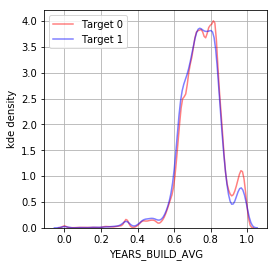

,YEARS_BUILD_AVG_TARGET_0,YEARS_BUILD_AVG_TARGET_1
count,95949.000000,7074.000000
mean,0.753153,0.743231
std,0.113316,0.112389
min,0.000000,0.000000
25%,0.687200,0.680400
50%,0.755200,0.748400
75%,0.823200,0.816400
max,1.000000,1.000000


In [11]:
var_names = var_float.columns
var = var_names[14]
print('Float variable name:', var)
# % missing value
print('% missing value', app_train[var].isnull().sum()/len(app_train[var])* 100)
# distribution of variable:
sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, var], label = 'Target 0', color='red', alpha=0.5)
sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, var], label = 'Target 1', color='blue', alpha=0.5)
plt.xlabel(var)
plt.ylabel('kde density')
#plt.yscale('log')
plt.grid(True)
plt.rcParams['figure.figsize'] = 4,4
plt.show()

# Statistical summary
# with target '0'
target_0_des = app_train.loc[app_train['TARGET'] == 0, var].describe().rename('YEARS_BUILD_AVG_TARGET_0')
#print('Target 0:', target_0_des)
# with target '1'
target_1_des = app_train.loc[app_train['TARGET'] == 1, var].describe().rename('YEARS_BUILD_AVG_TARGET_1')
#print('Target 1:', target_1_des)
pd.concat([target_0_des, target_1_des], axis=1)

Float variable name: COMMONAREA_AVG
% missing value 69.87229725115525


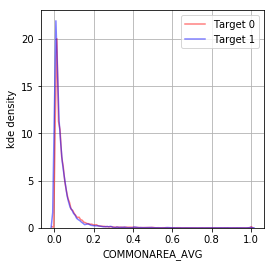

,COMMONAREA_AVG_TARGET_0,COMMONAREA_AVG_TARGET_1
count,86244.000000,6402.000000
mean,0.045005,0.039444
std,0.076669,0.066716
min,0.000000,0.000000
25%,0.007900,0.007300
50%,0.021300,0.018600
75%,0.051800,0.046700
max,1.000000,1.000000


In [13]:
var_names = var_float.columns
var = var_names[15]
print('Float variable name:', var)
# % missing value
print('% missing value', app_train[var].isnull().sum()/len(app_train[var])* 100)
# distribution of variable:
sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, var], label = 'Target 0', color='red', alpha=0.5)
sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, var], label = 'Target 1', color='blue', alpha=0.5)
plt.xlabel(var)
plt.ylabel('kde density')
#plt.yscale('log')
plt.grid(True)
plt.rcParams['figure.figsize'] = 4,4
plt.show()

# Statistical summary
# with target '0'
target_0_des = app_train.loc[app_train['TARGET'] == 0, var].describe().rename('COMMONAREA_AVG_TARGET_0')
#print('Target 0:', target_0_des)
# with target '1'
target_1_des = app_train.loc[app_train['TARGET'] == 1, var].describe().rename('COMMONAREA_AVG_TARGET_1')
#print('Target 1:', target_1_des)
pd.concat([target_0_des, target_1_des], axis=1)

Float variable name: ELEVATORS_AVG
% missing value 53.29597965601231


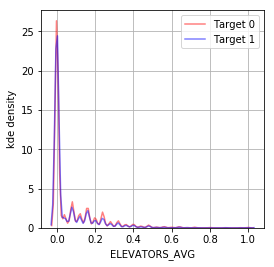

,ELEVATORS_AVG_TARGET_0,ELEVATORS_AVG_TARGET_1
count,133710.000000,9910.000000
mean,0.080194,0.062036
std,0.135567,0.119132
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.120000,0.080000
max,1.000000,1.000000


In [594]:
var_names = var_float.columns
var = var_names[16]
print('Float variable name:', var)
# % missing value
print('% missing value', app_train[var].isnull().sum()/len(app_train[var])* 100)
# distribution of variable:
sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, var], label = 'Target 0', color='red', alpha=0.5)
sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, var], label = 'Target 1', color='blue', alpha=0.5)
plt.xlabel(var)
plt.ylabel('kde density')
#plt.yscale('log')
plt.grid(True)
plt.rcParams['figure.figsize'] = 4,4
plt.show()

# Statistical summary
# with target '0'
target_0_des = app_train.loc[app_train['TARGET'] == 0, var].describe().rename('ELEVATORS_AVG_TARGET_0')
#print('Target 0:', target_0_des)
# with target '1'
target_1_des = app_train.loc[app_train['TARGET'] == 1, var].describe().rename('ELEVATORS_AVG_TARGET_1')
#print('Target 1:', target_1_des)
pd.concat([target_0_des, target_1_des], axis=1)

Float variable name: ENTRANCES_AVG
% missing value 50.3487680115508


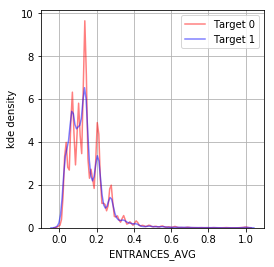

,ENTRANCES_AVG_TARGET_0,ENTRANCES_AVG_TARGET_1
count,142069.000000,10614.000000
mean,0.150249,0.142707
std,0.100171,0.098134
min,0.000000,0.000000
25%,0.069000,0.069000
50%,0.137900,0.137900
75%,0.206900,0.189700
max,1.000000,1.000000


In [17]:
var_names = var_float.columns
var = var_names[17]
print('Float variable name:', var)
# % missing value
print('% missing value', app_train[var].isnull().sum()/len(app_train[var])* 100)
# distribution of variable:
sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, var], label = 'Target 0', color='red', alpha=0.5)
sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, var], label = 'Target 1', color='blue', alpha=0.5)
plt.xlabel(var)
plt.ylabel('kde density')
#plt.yscale('log')
plt.grid(True)
plt.rcParams['figure.figsize'] = 4,4
plt.show()

# Statistical summary
# with target '0'
target_0_des = app_train.loc[app_train['TARGET'] == 0, var].describe().rename('ENTRANCES_AVG_TARGET_0')
#print('Target 0:', target_0_des)
# with target '1'
target_1_des = app_train.loc[app_train['TARGET'] == 1, var].describe().rename('ENTRANCES_AVG_TARGET_1')
#print('Target 1:', target_1_des)
pd.concat([target_0_des, target_1_des], axis=1)

Float variable name: FLOORSMAX_AVG
% missing value 49.76082156410665


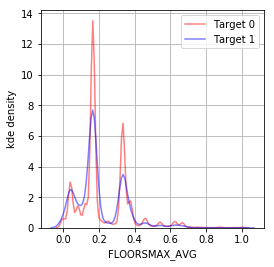

,FLOORSMAX_AVG_TARGET_0,FLOORSMAX_AVG_TARGET_1
count,143730.000000,10761.000000
mean,0.228023,0.203021
std,0.145228,0.134414
min,0.000000,0.000000
25%,0.166700,0.125000
50%,0.166700,0.166700
75%,0.333300,0.333300
max,1.000000,1.000000


In [19]:
var_names = var_float.columns
var = var_names[18]
print('Float variable name:', var)
# % missing value
print('% missing value', app_train[var].isnull().sum()/len(app_train[var])* 100)
# distribution of variable:
sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, var], label = 'Target 0', color='red', alpha=0.5)
sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, var], label = 'Target 1', color='blue', alpha=0.5)
plt.xlabel(var)
plt.ylabel('kde density')
#plt.yscale('log')
plt.grid(True)
plt.rcParams['figure.figsize'] = 4,4
plt.show()

# Statistical summary
# with target '0'
target_0_des = app_train.loc[app_train['TARGET'] == 0, var].describe().rename('FLOORSMAX_AVG_TARGET_0')
#print('Target 0:', target_0_des)
# with target '1'
target_1_des = app_train.loc[app_train['TARGET'] == 1, var].describe().rename('FLOORSMAX_AVG_TARGET_1')
#print('Target 1:', target_1_des)
pd.concat([target_0_des, target_1_des], axis=1)

Float variable name: FLOORSMIN_AVG
% missing value 67.84862980511267


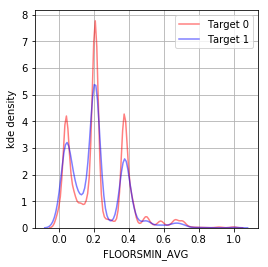

,FLOORSMIN_AVG_TARGET_0,FLOORSMIN_AVG_TARGET_1
count,92052.000000,6817.00000
mean,0.233370,0.21196
std,0.162181,0.14873
min,0.000000,0.00000
25%,0.083300,0.08330
50%,0.208300,0.20830
75%,0.375000,0.31920
max,1.000000,1.00000


In [21]:
var_names = var_float.columns
var = var_names[19]
print('Float variable name:', var)
# % missing value
print('% missing value', app_train[var].isnull().sum()/len(app_train[var])* 100)
# distribution of variable:
sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, var], label = 'Target 0', color='red', alpha=0.5)
sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, var], label = 'Target 1', color='blue', alpha=0.5)
plt.xlabel(var)
plt.ylabel('kde density')
#plt.yscale('log')
plt.grid(True)
plt.rcParams['figure.figsize'] = 4,4
plt.show()

# Statistical summary
# with target '0'
target_0_des = app_train.loc[app_train['TARGET'] == 0, var].describe().rename('FLOORSMIN_AVG_TARGET_0')
#print('Target 0:', target_0_des)
# with target '1'
target_1_des = app_train.loc[app_train['TARGET'] == 1, var].describe().rename('FLOORSMIN_AVG_TARGET_1')
#print('Target 1:', target_1_des)
pd.concat([target_0_des, target_1_des], axis=1)

Float variable name: LANDAREA_AVG
% missing value 59.376737742714894


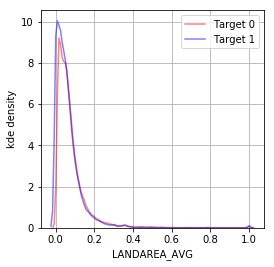

,LANDAREA_AVG_TARGET_0,LANDAREA_AVG_TARGET_1
count,116200.000000,8721.000000
mean,0.066575,0.063108
std,0.081200,0.080903
min,0.000000,0.000000
25%,0.018800,0.017800
50%,0.048400,0.044900
75%,0.085900,0.080800
max,1.000000,1.000000


In [23]:
var_names = var_float.columns
var = var_names[20]
print('Float variable name:', var)
# % missing value
print('% missing value', app_train[var].isnull().sum()/len(app_train[var])* 100)
# distribution of variable:
sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, var], label = 'Target 0', color='red', alpha=0.5)
sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, var], label = 'Target 1', color='blue', alpha=0.5)
plt.xlabel(var)
plt.ylabel('kde density')
#plt.yscale('log')
plt.grid(True)
plt.rcParams['figure.figsize'] = 4,4
plt.show()

# Statistical summary
# with target '0'
target_0_des = app_train.loc[app_train['TARGET'] == 0, var].describe().rename('LANDAREA_AVG_TARGET_0')
#print('Target 0:', target_0_des)
# with target '1'
target_1_des = app_train.loc[app_train['TARGET'] == 1, var].describe().rename('LANDAREA_AVG_TARGET_1')
#print('Target 1:', target_1_des)
pd.concat([target_0_des, target_1_des], axis=1)

Float variable name: LIVINGAPARTMENTS_AVG
% missing value 68.35495315614726


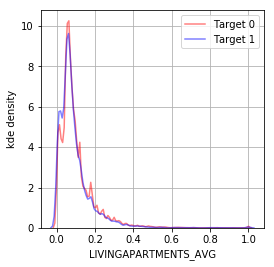

,LIVINGAPARTMENTS_AVG_TARGET_0,LIVINGAPARTMENTS_AVG_TARGET_1
count,90609.000000,6703.000000
mean,0.101405,0.092255
std,0.092910,0.087500
min,0.000000,0.000000
25%,0.050400,0.045400
50%,0.075600,0.067200
75%,0.121000,0.116800
max,1.000000,1.000000


In [25]:
var_names = var_float.columns
var = var_names[21]
print('Float variable name:', var)
# % missing value
print('% missing value', app_train[var].isnull().sum()/len(app_train[var])* 100)
# distribution of variable:
sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, var], label = 'Target 0', color='red', alpha=0.5)
sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, var], label = 'Target 1', color='blue', alpha=0.5)
plt.xlabel(var)
plt.ylabel('kde density')
#plt.yscale('log')
plt.grid(True)
plt.rcParams['figure.figsize'] = 4,4
plt.show()

# Statistical summary
# with target '0'
target_0_des = app_train.loc[app_train['TARGET'] == 0, var].describe().rename('LIVINGAPARTMENTS_AVG_TARGET_0')
#print('Target 0:', target_0_des)
# with target '1'
target_1_des = app_train.loc[app_train['TARGET'] == 1, var].describe().rename('LIVINGAPARTMENTS_AVG_TARGET_1')
#print('Target 1:', target_1_des)
pd.concat([target_0_des, target_1_des], axis=1)

Float variable name: LIVINGAREA_AVG
% missing value 50.193326417591564


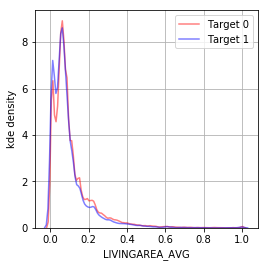

,LIVINGAREA_AVG_TARGET_0,LIVINGAREA_AVG_TARGET_1
count,142447.000000,10714.000000
mean,0.108400,0.094096
std,0.111216,0.100576
min,0.000000,0.000000
25%,0.046100,0.035525
50%,0.075200,0.066700
75%,0.131800,0.113800
max,1.000000,1.000000


In [27]:
var_names = var_float.columns
var = var_names[22]
print('Float variable name:', var)
# % missing value
print('% missing value', app_train[var].isnull().sum()/len(app_train[var])* 100)
# distribution of variable:
sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, var], label = 'Target 0', color='red', alpha=0.5)
sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, var], label = 'Target 1', color='blue', alpha=0.5)
plt.xlabel(var)
plt.ylabel('kde density')
#plt.yscale('log')
plt.grid(True)
plt.rcParams['figure.figsize'] = 4,4
plt.show()

# Statistical summary
# with target '0'
target_0_des = app_train.loc[app_train['TARGET'] == 0, var].describe().rename('LIVINGAREA_AVG_TARGET_0')
#print('Target 0:', target_0_des)
# with target '1'
target_1_des = app_train.loc[app_train['TARGET'] == 1, var].describe().rename('LIVINGAREA_AVG_TARGET_1')
#print('Target 1:', target_1_des)
pd.concat([target_0_des, target_1_des], axis=1)

Float variable name: NONLIVINGAPARTMENTS_AVG
% missing value 69.43296337366793


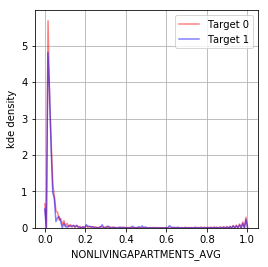

,NONLIVINGAPARTMENTS_AVG_TARGET_0,NONLIVINGAPARTMENTS_AVG_TARGET_1
count,87499.000000,6498.000000
mean,0.008850,0.008252
std,0.047813,0.046621
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.003900,0.003900
max,1.000000,1.000000


In [592]:
var_names = var_float.columns
var = var_names[23]
print('Float variable name:', var)
# % missing value
print('% missing value', app_train[var].isnull().sum()/len(app_train[var])* 100)
# distribution of variable:
sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, var], label = 'Target 0', color='red', alpha=0.5)
sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, var], label = 'Target 1', color='blue', alpha=0.5)
plt.xlabel(var)
plt.ylabel('kde density')
#plt.xscale('log')
plt.grid(True)
plt.rcParams['figure.figsize'] = 4,4
plt.show()

# Statistical summary
# with target '0'
target_0_des = app_train.loc[app_train['TARGET'] == 0, var].describe().rename('NONLIVINGAPARTMENTS_AVG_TARGET_0')
#print('Target 0:', target_0_des)
# with target '1'
target_1_des = app_train.loc[app_train['TARGET'] == 1, var].describe().rename('NONLIVINGAPARTMENTS_AVG_TARGET_1')
#print('Target 1:', target_1_des)
pd.concat([target_0_des, target_1_des], axis=1)

Float variable name: NONLIVINGAREA_AVG
% missing value 55.17916432257708


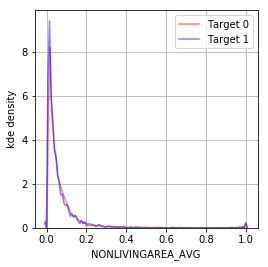

,NONLIVINGAREA_AVG_TARGET_0,NONLIVINGAREA_AVG_TARGET_1
count,128334.000000,9495.000000
mean,0.028615,0.024887
std,0.070017,0.062371
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.003600,0.002800
75%,0.027900,0.024500
max,1.000000,1.000000


In [31]:
var_names = var_float.columns
var = var_names[24]
print('Float variable name:', var)
# % missing value
print('% missing value', app_train[var].isnull().sum()/len(app_train[var])* 100)
# distribution of variable:
sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, var], label = 'Target 0', color='red', alpha=0.5)
sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, var], label = 'Target 1', color='blue', alpha=0.5)
plt.xlabel(var)
plt.ylabel('kde density')
#plt.yscale('log')
plt.grid(True)
plt.rcParams['figure.figsize'] = 4,4
plt.show()

# Statistical summary
# with target '0'
target_0_des = app_train.loc[app_train['TARGET'] == 0, var].describe().rename('NONLIVINGAREA_AVG_TARGET_0')
#print('Target 0:', target_0_des)
# with target '1'
target_1_des = app_train.loc[app_train['TARGET'] == 1, var].describe().rename('NONLIVINGAREA_AVG_TARGET_1')
#print('Target 1:', target_1_des)
pd.concat([target_0_des, target_1_des], axis=1)

Float variable name: APARTMENTS_MODE
% missing value 50.74972927797705


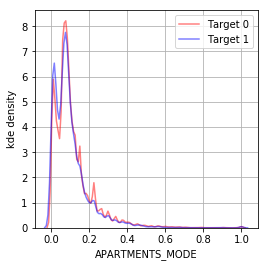

,APARTMENTS_MODE_TARGET_0,APARTMENTS_MODE_TARGET_1
count,140910.000000,10540.000000
mean,0.115036,0.103463
std,0.108375,0.101271
min,0.000000,0.000000
25%,0.053600,0.037800
50%,0.084000,0.080900
75%,0.146000,0.126100
max,1.000000,1.000000


In [33]:
var_names = var_float.columns
var = var_names[25]
print('Float variable name:', var)
# % missing value
print('% missing value', app_train[var].isnull().sum()/len(app_train[var])* 100)
# distribution of variable:
sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, var], label = 'Target 0', color='red', alpha=0.5)
sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, var], label = 'Target 1', color='blue', alpha=0.5)
plt.xlabel(var)
plt.ylabel('kde density')
#plt.yscale('log')
plt.grid(True)
plt.rcParams['figure.figsize'] = 4,4
plt.show()

# Statistical summary
# with target '0'
target_0_des = app_train.loc[app_train['TARGET'] == 0, var].describe().rename('APARTMENTS_MODE_TARGET_0')
#print('Target 0:', target_0_des)
# with target '1'
target_1_des = app_train.loc[app_train['TARGET'] == 1, var].describe().rename('APARTMENTS_MODE_TARGET_1')
#print('Target 1:', target_1_des)
pd.concat([target_0_des, target_1_des], axis=1)

Float variable name: BASEMENTAREA_MODE
% missing value 58.51595552679416


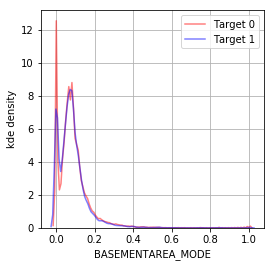

,BASEMENTAREA_MODE_TARGET_0,BASEMENTAREA_MODE_TARGET_1
count,118781.000000,8787.000000
mean,0.088001,0.081359
std,0.084858,0.076210
min,0.000000,0.000000
25%,0.041000,0.036300
50%,0.074800,0.071600
75%,0.112900,0.106800
max,1.000000,1.000000


In [35]:
var_names = var_float.columns
var = var_names[26]
print('Float variable name:', var)
# % missing value
print('% missing value', app_train[var].isnull().sum()/len(app_train[var])* 100)
# distribution of variable:
sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, var], label = 'Target 0', color='red', alpha=0.5)
sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, var], label = 'Target 1', color='blue', alpha=0.5)
plt.xlabel(var)
plt.ylabel('kde density')
#plt.yscale('log')
plt.grid(True)
plt.rcParams['figure.figsize'] = 4,4
plt.show()

# Statistical summary
# with target '0'
target_0_des = app_train.loc[app_train['TARGET'] == 0, var].describe().rename('BASEMENTAREA_MODE_TARGET_0')
#print('Target 0:', target_0_des)
# with target '1'
target_1_des = app_train.loc[app_train['TARGET'] == 1, var].describe().rename('BASEMENTAREA_MODE_TARGET_1')
#print('Target 1:', target_1_des)
pd.concat([target_0_des, target_1_des], axis=1)

Float variable name: YEARS_BEGINEXPLUATATION_MODE
% missing value 48.781019215572776


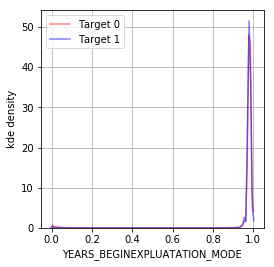

,YEARS_BEGINEXPLUATATION_MODE_TARGET_0,YEARS_BEGINEXPLUATATION_MODE_TARGET_1
count,146487.000000,11017.000000
mean,0.977225,0.974938
std,0.063821,0.073849
min,0.000000,0.000000
25%,0.976700,0.975700
50%,0.981600,0.980600
75%,0.986600,0.986100
max,1.000000,1.000000


In [37]:
var_names = var_float.columns
var = var_names[27]
print('Float variable name:', var)
# % missing value
print('% missing value', app_train[var].isnull().sum()/len(app_train[var])* 100)
# distribution of variable:
sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, var], label = 'Target 0', color='red', alpha=0.5)
sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, var], label = 'Target 1', color='blue', alpha=0.5)
plt.xlabel(var)
plt.ylabel('kde density')
#plt.yscale('log')
plt.grid(True)
plt.rcParams['figure.figsize'] = 4,4
plt.show()

# Statistical summary
# with target '0'
target_0_des = app_train.loc[app_train['TARGET'] == 0, var].describe().rename('YEARS_BEGINEXPLUATATION_MODE_TARGET_0')
#print('Target 0:', target_0_des)
# with target '1'
target_1_des = app_train.loc[app_train['TARGET'] == 1, var].describe().rename('YEARS_BEGINEXPLUATATION_MODE_TARGET_1')
#print('Target 1:', target_1_des)
pd.concat([target_0_des, target_1_des], axis=1)

Float variable name: YEARS_BUILD_MODE
% missing value 66.49778381911543


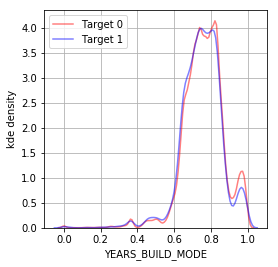

,YEARS_BUILD_MODE_TARGET_0,YEARS_BUILD_MODE_TARGET_1
count,95949.000000,7074.000000
mean,0.760297,0.750688
std,0.110144,0.109280
min,0.000000,0.000000
25%,0.699400,0.686400
50%,0.764800,0.755000
75%,0.830100,0.817100
max,1.000000,1.000000


In [39]:
var_names = var_float.columns
var = var_names[28]
print('Float variable name:', var)
# % missing value
print('% missing value', app_train[var].isnull().sum()/len(app_train[var])* 100)
# distribution of variable:
sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, var], label = 'Target 0', color='red', alpha=0.5)
sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, var], label = 'Target 1', color='blue', alpha=0.5)
plt.xlabel(var)
plt.ylabel('kde density')
#plt.yscale('log')
plt.grid(True)
plt.rcParams['figure.figsize'] = 4,4
plt.show()

# Statistical summary
# with target '0'
target_0_des = app_train.loc[app_train['TARGET'] == 0, var].describe().rename('YEARS_BUILD_MODE_TARGET_0')
#print('Target 0:', target_0_des)
# with target '1'
target_1_des = app_train.loc[app_train['TARGET'] == 1, var].describe().rename('YEARS_BUILD_MODE_TARGET_1')
#print('Target 1:', target_1_des)
pd.concat([target_0_des, target_1_des], axis=1)

Float variable name: COMMONAREA_MODE
% missing value 69.87229725115525


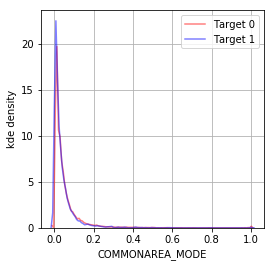

,COMMONAREA_MODE_TARGET_0,COMMONAREA_MODE_TARGET_1
count,86244.000000,6402.000000
mean,0.042885,0.038088
std,0.075006,0.066271
min,0.000000,0.000000
25%,0.007300,0.006700
50%,0.019200,0.017100
75%,0.049300,0.044975
max,1.000000,1.000000


In [41]:
var_names = var_float.columns
var = var_names[29]
print('Float variable name:', var)
# % missing value
print('% missing value', app_train[var].isnull().sum()/len(app_train[var])* 100)
# distribution of variable:
sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, var], label = 'Target 0', color='red', alpha=0.5)
sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, var], label = 'Target 1', color='blue', alpha=0.5)
plt.xlabel(var)
plt.ylabel('kde density')
#plt.yscale('log')
plt.grid(True)
plt.rcParams['figure.figsize'] = 4,4
plt.show()

# Statistical summary
# with target '0'
target_0_des = app_train.loc[app_train['TARGET'] == 0, var].describe().rename('COMMONAREA_MODE_TARGET_0')
#print('Target 0:', target_0_des)
# with target '1'
target_1_des = app_train.loc[app_train['TARGET'] == 1, var].describe().rename('COMMONAREA_MODE_TARGET_1')
#print('Target 1:', target_1_des)
pd.concat([target_0_des, target_1_des], axis=1)

Float variable name: ELEVATORS_MODE
% missing value 53.29597965601231


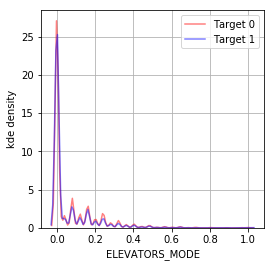

,COMMONAREA_MODE_TARGET_0,COMMONAREA_MODE_TARGET_1
count,133710.000000,9910.000000
mean,0.075647,0.058880
std,0.133202,0.117662
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.120800,0.080600
max,1.000000,1.000000


In [42]:
var_names = var_float.columns
var = var_names[30]
print('Float variable name:', var)
# % missing value
print('% missing value', app_train[var].isnull().sum()/len(app_train[var])* 100)
# distribution of variable:
sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, var], label = 'Target 0', color='red', alpha=0.5)
sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, var], label = 'Target 1', color='blue', alpha=0.5)
plt.xlabel(var)
plt.ylabel('kde density')
#plt.yscale('log')
plt.grid(True)
plt.rcParams['figure.figsize'] = 4,4
plt.show()

# Statistical summary
# with target '0'
target_0_des = app_train.loc[app_train['TARGET'] == 0, var].describe().rename('COMMONAREA_MODE_TARGET_0')
#print('Target 0:', target_0_des)
# with target '1'
target_1_des = app_train.loc[app_train['TARGET'] == 1, var].describe().rename('COMMONAREA_MODE_TARGET_1')
#print('Target 1:', target_1_des)
pd.concat([target_0_des, target_1_des], axis=1)

Float variable name: ENTRANCES_MODE
% missing value 50.3487680115508


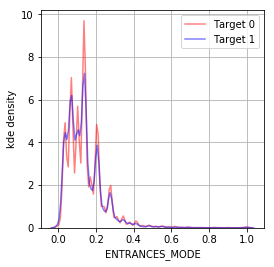

,ENTRANCES_MODE_TARGET_0,ENTRANCES_MODE_TARGET_1
count,142069.000000,10614.000000
mean,0.145673,0.138769
std,0.101106,0.099009
min,0.000000,0.000000
25%,0.069000,0.069000
50%,0.137900,0.137900
75%,0.206900,0.172400
max,1.000000,1.000000


In [44]:
var_names = var_float.columns
var = var_names[31]
print('Float variable name:', var)
# % missing value
print('% missing value', app_train[var].isnull().sum()/len(app_train[var])* 100)
# distribution of variable:
sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, var], label = 'Target 0', color='red', alpha=0.5)
sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, var], label = 'Target 1', color='blue', alpha=0.5)
plt.xlabel(var)
plt.ylabel('kde density')
#plt.yscale('log')
plt.grid(True)
plt.rcParams['figure.figsize'] = 4,4
plt.show()

# Statistical summary
# with target '0'
target_0_des = app_train.loc[app_train['TARGET'] == 0, var].describe().rename('ENTRANCES_MODE_TARGET_0')
#print('Target 0:', target_0_des)
# with target '1'
target_1_des = app_train.loc[app_train['TARGET'] == 1, var].describe().rename('ENTRANCES_MODE_TARGET_1')
#print('Target 1:', target_1_des)
pd.concat([target_0_des, target_1_des], axis=1)

Float variable name: FLOORSMAX_MODE
% missing value 49.76082156410665


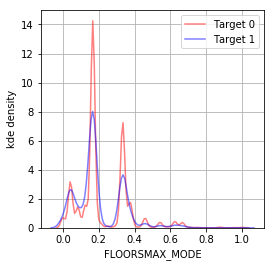

,FLOORSMAX_MODE_TARGET_0,FLOORSMAX_MODE_TARGET_1
count,143730.000000,10761.000000
mean,0.224015,0.199612
std,0.144298,0.133548
min,0.000000,0.000000
25%,0.166700,0.125000
50%,0.166700,0.166700
75%,0.333300,0.333300
max,1.000000,1.000000


In [46]:
var_names = var_float.columns
var = var_names[32]
print('Float variable name:', var)
# % missing value
print('% missing value', app_train[var].isnull().sum()/len(app_train[var])* 100)
# distribution of variable:
sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, var], label = 'Target 0', color='red', alpha=0.5)
sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, var], label = 'Target 1', color='blue', alpha=0.5)
plt.xlabel(var)
plt.ylabel('kde density')
#plt.yscale('log')
plt.grid(True)
plt.rcParams['figure.figsize'] = 4,4
plt.show()

# Statistical summary
# with target '0'
target_0_des = app_train.loc[app_train['TARGET'] == 0, var].describe().rename('FLOORSMAX_MODE_TARGET_0')
#print('Target 0:', target_0_des)
# with target '1'
target_1_des = app_train.loc[app_train['TARGET'] == 1, var].describe().rename('FLOORSMAX_MODE_TARGET_1')
#print('Target 1:', target_1_des)
pd.concat([target_0_des, target_1_des], axis=1)

Float variable name: FLOORSMIN_MODE
% missing value 67.84862980511267


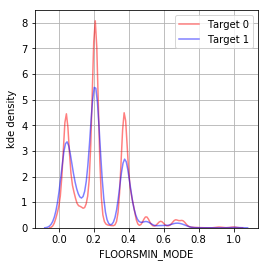

,FLOORSMIN_MODE_TARGET_0,FLOORSMIN_MODE_TARGET_1
count,92052.000000,6817.000000
mean,0.229493,0.208695
std,0.161968,0.148480
min,0.000000,0.000000
25%,0.083300,0.083300
50%,0.208300,0.208300
75%,0.375000,0.291700
max,1.000000,1.000000


In [48]:
var_names = var_float.columns
var = var_names[33]
print('Float variable name:', var)
# % missing value
print('% missing value', app_train[var].isnull().sum()/len(app_train[var])* 100)
# distribution of variable:
sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, var], label = 'Target 0', color='red', alpha=0.5)
sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, var], label = 'Target 1', color='blue', alpha=0.5)
plt.xlabel(var)
plt.ylabel('kde density')
#plt.yscale('log')
plt.grid(True)
plt.rcParams['figure.figsize'] = 4,4
plt.show()

# Statistical summary
# with target '0'
target_0_des = app_train.loc[app_train['TARGET'] == 0, var].describe().rename('FLOORSMIN_MODE_TARGET_0')
#print('Target 0:', target_0_des)
# with target '1'
target_1_des = app_train.loc[app_train['TARGET'] == 1, var].describe().rename('FLOORSMIN_MODE_TARGET_1')
#print('Target 1:', target_1_des)
pd.concat([target_0_des, target_1_des], axis=1)

Float variable name: LANDAREA_MODE
% missing value 59.376737742714894


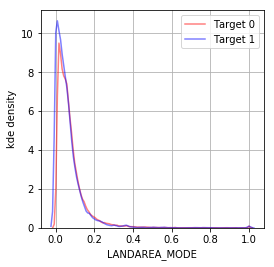

,LANDAREA_MODE_TARGET_0,LANDAREA_MODE_TARGET_1
count,116200.000000,8721.000000
mean,0.065186,0.061922
std,0.081800,0.081023
min,0.000000,0.000000
25%,0.016600,0.016000
50%,0.046100,0.042800
75%,0.084400,0.079300
max,1.000000,1.000000


In [50]:
var_names = var_float.columns
var = var_names[34]
print('Float variable name:', var)
# % missing value
print('% missing value', app_train[var].isnull().sum()/len(app_train[var])* 100)
# distribution of variable:
sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, var], label = 'Target 0', color='red', alpha=0.5)
sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, var], label = 'Target 1', color='blue', alpha=0.5)
plt.xlabel(var)
plt.ylabel('kde density')
#plt.yscale('log')
plt.grid(True)
plt.rcParams['figure.figsize'] = 4,4
plt.show()

# Statistical summary
# with target '0'
target_0_des = app_train.loc[app_train['TARGET'] == 0, var].describe().rename('LANDAREA_MODE_TARGET_0')
#print('Target 0:', target_0_des)
# with target '1'
target_1_des = app_train.loc[app_train['TARGET'] == 1, var].describe().rename('LANDAREA_MODE_TARGET_1')
#print('Target 1:', target_1_des)
pd.concat([target_0_des, target_1_des], axis=1)

Float variable name: LIVINGAPARTMENTS_MODE
% missing value 68.35495315614726


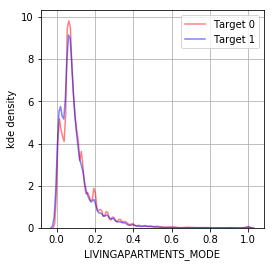

,LIVINGAPARTMENTS_MODE_TARGET_0,LIVINGAPARTMENTS_MODE_TARGET_1
count,90609.000000,6703.000000
mean,0.106268,0.097226
std,0.098184,0.093276
min,0.000000,0.000000
25%,0.054200,0.044100
50%,0.077100,0.073500
75%,0.131300,0.118500
max,1.000000,1.000000


In [52]:
var_names = var_float.columns
var = var_names[35]
print('Float variable name:', var)
# % missing value
print('% missing value', app_train[var].isnull().sum()/len(app_train[var])* 100)
# distribution of variable:
sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, var], label = 'Target 0', color='red', alpha=0.5)
sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, var], label = 'Target 1', color='blue', alpha=0.5)
plt.xlabel(var)
plt.ylabel('kde density')
#plt.yscale('log')
plt.grid(True)
plt.rcParams['figure.figsize'] = 4,4
plt.show()

# Statistical summary
# with target '0'
target_0_des = app_train.loc[app_train['TARGET'] == 0, var].describe().rename('LIVINGAPARTMENTS_MODE_TARGET_0')
#print('Target 0:', target_0_des)
# with target '1'
target_1_des = app_train.loc[app_train['TARGET'] == 1, var].describe().rename('LIVINGAPARTMENTS_MODE_TARGET_1')
#print('Target 1:', target_1_des)
pd.concat([target_0_des, target_1_des], axis=1)

Float variable name: LIVINGAREA_MODE
% missing value 50.193326417591564


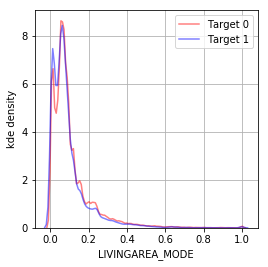

,LIVINGAREA_MODE_TARGET_0,LIVINGAREA_MODE_TARGET_1
count,142447.000000,10714.000000
mean,0.106916,0.093461
std,0.112475,0.102287
min,0.000000,0.000000
25%,0.043400,0.032900
50%,0.073400,0.066750
75%,0.126100,0.112200
max,1.000000,1.000000


In [54]:
var_names = var_float.columns
var = var_names[36]
print('Float variable name:', var)
# % missing value
print('% missing value', app_train[var].isnull().sum()/len(app_train[var])* 100)
# distribution of variable:
sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, var], label = 'Target 0', color='red', alpha=0.5)
sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, var], label = 'Target 1', color='blue', alpha=0.5)
plt.xlabel(var)
plt.ylabel('kde density')
#plt.yscale('log')
plt.grid(True)
plt.rcParams['figure.figsize'] = 4,4
plt.show()

# Statistical summary
# with target '0'
target_0_des = app_train.loc[app_train['TARGET'] == 0, var].describe().rename('LIVINGAREA_MODE_TARGET_0')
#print('Target 0:', target_0_des)
# with target '1'
target_1_des = app_train.loc[app_train['TARGET'] == 1, var].describe().rename('LIVINGAREA_MODE_TARGET_1')
#print('Target 1:', target_1_des)
pd.concat([target_0_des, target_1_des], axis=1)

Float variable name: NONLIVINGAPARTMENTS_MODE
% missing value 69.43296337366793


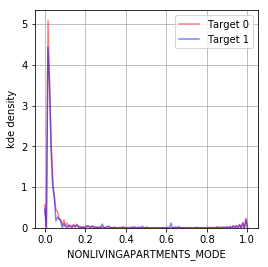

,NONLIVINGAPARTMENTS_MODE_TARGET_0,NONLIVINGAPARTMENTS_MODE_TARGET_1
count,87499.000000,6498.000000
mean,0.008096,0.007812
std,0.046250,0.046627
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.003900,0.003900
max,1.000000,1.000000


In [56]:
var_names = var_float.columns
var = var_names[37]
print('Float variable name:', var)
# % missing value
print('% missing value', app_train[var].isnull().sum()/len(app_train[var])* 100)
# distribution of variable:
sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, var], label = 'Target 0', color='red', alpha=0.5)
sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, var], label = 'Target 1', color='blue', alpha=0.5)
plt.xlabel(var)
plt.ylabel('kde density')
#plt.yscale('log')
plt.grid(True)
plt.rcParams['figure.figsize'] = 4,4
plt.show()

# Statistical summary
# with target '0'
target_0_des = app_train.loc[app_train['TARGET'] == 0, var].describe().rename('NONLIVINGAPARTMENTS_MODE_TARGET_0')
#print('Target 0:', target_0_des)
# with target '1'
target_1_des = app_train.loc[app_train['TARGET'] == 1, var].describe().rename('NONLIVINGAPARTMENTS_MODE_TARGET_1')
#print('Target 1:', target_1_des)
pd.concat([target_0_des, target_1_des], axis=1)

Float variable name: NONLIVINGAREA_MODE
% missing value 55.17916432257708


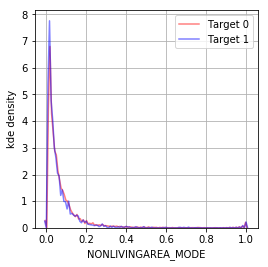

,NONLIVINGAREA_MODE_TARGET_0,NONLIVINGAREA_MODE_TARGET_1
count,128334.000000,9495.000000
mean,0.027265,0.023739
std,0.070740,0.063229
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.001100,0.000000
75%,0.023300,0.020200
max,1.000000,1.000000


In [58]:
var_names = var_float.columns
var = var_names[38]
print('Float variable name:', var)
# % missing value
print('% missing value', app_train[var].isnull().sum()/len(app_train[var])* 100)
# distribution of variable:
sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, var], label = 'Target 0', color='red', alpha=0.5)
sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, var], label = 'Target 1', color='blue', alpha=0.5)
plt.xlabel(var)
plt.ylabel('kde density')
#plt.yscale('log')
plt.grid(True)
plt.rcParams['figure.figsize'] = 4,4
plt.show()

# Statistical summary
# with target '0'
target_0_des = app_train.loc[app_train['TARGET'] == 0, var].describe().rename('NONLIVINGAREA_MODE_TARGET_0')
#print('Target 0:', target_0_des)
# with target '1'
target_1_des = app_train.loc[app_train['TARGET'] == 1, var].describe().rename('NONLIVINGAREA_MODE_TARGET_1')
#print('Target 1:', target_1_des)
pd.concat([target_0_des, target_1_des], axis=1)

Float variable name: APARTMENTS_MEDI
% missing value 50.74972927797705


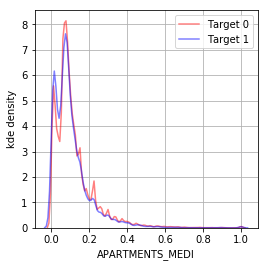

,APARTMENTS_MEDI_TARGET_0,APARTMENTS_MEDI_TARGET_1
count,140910.000000,10540.000000
mean,0.118721,0.106211
std,0.109572,0.101504
min,0.000000,0.000000
25%,0.058300,0.041600
50%,0.087400,0.083300
75%,0.149900,0.133200
max,1.000000,1.000000


In [60]:
var_names = var_float.columns
var = var_names[39]
print('Float variable name:', var)
# % missing value
print('% missing value', app_train[var].isnull().sum()/len(app_train[var])* 100)
# distribution of variable:
sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, var], label = 'Target 0', color='red', alpha=0.5)
sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, var], label = 'Target 1', color='blue', alpha=0.5)
plt.xlabel(var)
plt.ylabel('kde density')
#plt.yscale('log')
plt.grid(True)
plt.rcParams['figure.figsize'] = 4,4
plt.show()

# Statistical summary
# with target '0'
target_0_des = app_train.loc[app_train['TARGET'] == 0, var].describe().rename('APARTMENTS_MEDI_TARGET_0')
#print('Target 0:', target_0_des)
# with target '1'
target_1_des = app_train.loc[app_train['TARGET'] == 1, var].describe().rename('APARTMENTS_MEDI_TARGET_1')
#print('Target 1:', target_1_des)
pd.concat([target_0_des, target_1_des], axis=1)

Float variable name: BASEMENTAREA_MEDI
% missing value 58.51595552679416


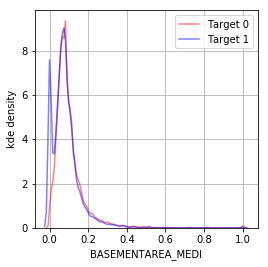

,BASEMENTAREA_MEDI_TARGET_0,BASEMENTAREA_MEDI_TARGET_1
count,118781.000000,8787.000000
mean,0.088448,0.081283
std,0.082705,0.074385
min,0.000000,0.000000
25%,0.044100,0.039300
50%,0.076100,0.071800
75%,0.112100,0.105900
max,1.000000,1.000000


In [63]:
var_names = var_float.columns
var = var_names[40]
print('Float variable name:', var)
# % missing value
print('% missing value', app_train[var].isnull().sum()/len(app_train[var])* 100)
# distribution of variable:
sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, var], label = 'Target 0', color='red', alpha=0.5)
sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, var], label = 'Target 1', color='blue', alpha=0.5)
plt.xlabel(var)
plt.ylabel('kde density')
#plt.yscale('log')
plt.grid(True)
plt.rcParams['figure.figsize'] = 4,4
plt.show()

# Statistical summary
# with target '0'
target_0_des = app_train.loc[app_train['TARGET'] == 0, var].describe().rename('BASEMENTAREA_MEDI_TARGET_0')
#print('Target 0:', target_0_des)
# with target '1'
target_1_des = app_train.loc[app_train['TARGET'] == 1, var].describe().rename('BASEMENTAREA_MEDI_TARGET_1')
#print('Target 1:', target_1_des)
pd.concat([target_0_des, target_1_des], axis=1)

Float variable name: YEARS_BEGINEXPLUATATION_MEDI
% missing value 48.781019215572776


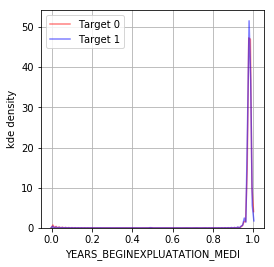

,YEARS_BEGINEXPLUATATION_MEDI_TARGET_0,YEARS_BEGINEXPLUATATION_MEDI_TARGET_1
count,146487.000000,11017.000000
mean,0.977916,0.975570
std,0.059055,0.070114
min,0.000000,0.000000
25%,0.976700,0.975700
50%,0.982100,0.981100
75%,0.986600,0.986100
max,1.000000,1.000000


In [276]:
var_names = var_float.columns
var = var_names[41]
print('Float variable name:', var)
# % missing value
print('% missing value', app_train[var].isnull().sum()/len(app_train[var])* 100)
# distribution of variable:
sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, var], label = 'Target 0', color='red', alpha=0.5)
sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, var], label = 'Target 1', color='blue', alpha=0.5)
plt.xlabel(var)
plt.ylabel('kde density')
#plt.xscale('log')
plt.grid(True)
plt.rcParams['figure.figsize'] = 4,4
plt.show()

# Statistical summary
# with target '0'
target_0_des = app_train.loc[app_train['TARGET'] == 0, var].describe().rename('YEARS_BEGINEXPLUATATION_MEDI_TARGET_0')
#print('Target 0:', target_0_des)
# with target '1'
target_1_des = app_train.loc[app_train['TARGET'] == 1, var].describe().rename('YEARS_BEGINEXPLUATATION_MEDI_TARGET_1')
#print('Target 1:', target_1_des)
pd.concat([target_0_des, target_1_des], axis=1)

Float variable name: YEARS_BUILD_MEDI
% missing value 66.49778381911543


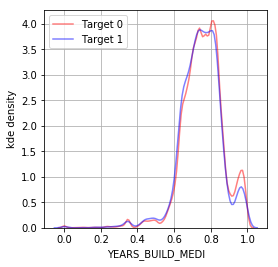

,YEARS_BUILD_MEDI_TARGET_0,YEARS_BUILD_MEDI_TARGET_1
count,95949.000000,7074.000000
mean,0.756426,0.746532
std,0.112101,0.111189
min,0.000000,0.000000
25%,0.691400,0.684700
50%,0.758500,0.751800
75%,0.825600,0.818900
max,1.000000,1.000000


In [67]:
var_names = var_float.columns
var = var_names[42]
print('Float variable name:', var)
# % missing value
print('% missing value', app_train[var].isnull().sum()/len(app_train[var])* 100)
# distribution of variable:
sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, var], label = 'Target 0', color='red', alpha=0.5)
sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, var], label = 'Target 1', color='blue', alpha=0.5)
plt.xlabel(var)
plt.ylabel('kde density')
#plt.yscale('log')
plt.grid(True)
plt.rcParams['figure.figsize'] = 4,4
plt.show()

# Statistical summary
# with target '0'
target_0_des = app_train.loc[app_train['TARGET'] == 0, var].describe().rename('YEARS_BUILD_MEDI_TARGET_0')
#print('Target 0:', target_0_des)
# with target '1'
target_1_des = app_train.loc[app_train['TARGET'] == 1, var].describe().rename('YEARS_BUILD_MEDI_TARGET_1')
#print('Target 1:', target_1_des)
pd.concat([target_0_des, target_1_des], axis=1)

Float variable name: COMMONAREA_MEDI
% missing value 69.87229725115525


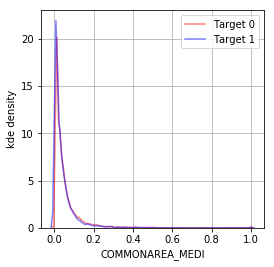

,COMMONAREA_MEDI_TARGET_0,COMMONAREA_MEDI_TARGET_1
count,86244.000000,6402.000000
mean,0.044980,0.039404
std,0.076778,0.066815
min,0.000000,0.000000
25%,0.007900,0.007200
50%,0.021000,0.018300
75%,0.051700,0.046700
max,1.000000,1.000000


In [278]:
var_names = var_float.columns
var = var_names[43]
print('Float variable name:', var)
# % missing value
print('% missing value', app_train[var].isnull().sum()/len(app_train[var])* 100)
# distribution of variable:
sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, var], label = 'Target 0', color='red', alpha=0.5)
sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, var], label = 'Target 1', color='blue', alpha=0.5)
plt.xlabel(var)
plt.ylabel('kde density')
#plt.xscale('log')
plt.grid(True)
plt.rcParams['figure.figsize'] = 4,4
plt.show()

# Statistical summary
# with target '0'
target_0_des = app_train.loc[app_train['TARGET'] == 0, var].describe().rename('COMMONAREA_MEDI_TARGET_0')
#print('Target 0:', target_0_des)
# with target '1'
target_1_des = app_train.loc[app_train['TARGET'] == 1, var].describe().rename('COMMONAREA_MEDI_TARGET_1')
#print('Target 1:', target_1_des)
pd.concat([target_0_des, target_1_des], axis=1)

Float variable name: ELEVATORS_MEDI
% missing value 53.29597965601231


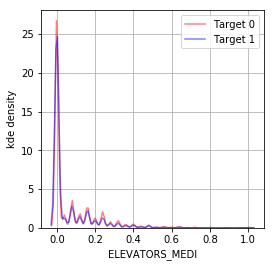

,ELEVATORS_MEDI_TARGET_0,ELEVATORS_MEDI_TARGET_1
count,133710.000000,9910.000000
mean,0.079317,0.061352
std,0.135463,0.118984
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.120000,0.080000
max,1.000000,1.000000


In [71]:
var_names = var_float.columns
var = var_names[44]
print('Float variable name:', var)
# % missing value
print('% missing value', app_train[var].isnull().sum()/len(app_train[var])* 100)
# distribution of variable:
sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, var], label = 'Target 0', color='red', alpha=0.5)
sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, var], label = 'Target 1', color='blue', alpha=0.5)
plt.xlabel(var)
plt.ylabel('kde density')
#plt.yscale('log')
plt.grid(True)
plt.rcParams['figure.figsize'] = 4,4
plt.show()

# Statistical summary
# with target '0'
target_0_des = app_train.loc[app_train['TARGET'] == 0, var].describe().rename('ELEVATORS_MEDI_TARGET_0')
#print('Target 0:', target_0_des)
# with target '1'
target_1_des = app_train.loc[app_train['TARGET'] == 1, var].describe().rename('ELEVATORS_MEDI_TARGET_1')
#print('Target 1:', target_1_des)
pd.concat([target_0_des, target_1_des], axis=1)

Float variable name: ENTRANCES_MEDI
% missing value 50.3487680115508


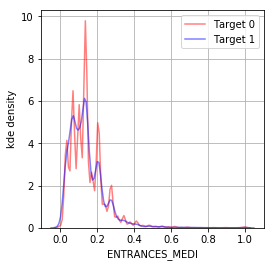

,ENTRANCES_MEDI_TARGET_0,ENTRANCES_MEDI_TARGET_1
count,142069.000000,10614.000000
mean,0.149735,0.142227
std,0.100492,0.098443
min,0.000000,0.000000
25%,0.069000,0.069000
50%,0.137900,0.137900
75%,0.206900,0.206900
max,1.000000,1.000000


In [73]:
var_names = var_float.columns
var = var_names[45]
print('Float variable name:', var)
# % missing value
print('% missing value', app_train[var].isnull().sum()/len(app_train[var])* 100)
# distribution of variable:
sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, var], label = 'Target 0', color='red', alpha=0.5)
sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, var], label = 'Target 1', color='blue', alpha=0.5)
plt.xlabel(var)
plt.ylabel('kde density')
#plt.yscale('log')
plt.grid(True)
plt.rcParams['figure.figsize'] = 4,4
plt.show()

# Statistical summary
# with target '0'
target_0_des = app_train.loc[app_train['TARGET'] == 0, var].describe().rename('ENTRANCES_MEDI_TARGET_0')
#print('Target 0:', target_0_des)
# with target '1'
target_1_des = app_train.loc[app_train['TARGET'] == 1, var].describe().rename('ENTRANCES_MEDI_TARGET_1')
#print('Target 1:', target_1_des)
pd.concat([target_0_des, target_1_des], axis=1)

Float variable name: FLOORSMAX_MEDI
% missing value 49.76082156410665


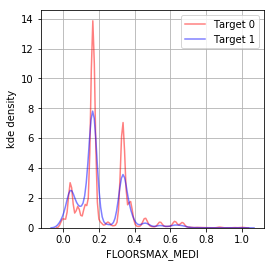

,FLOORSMAX_MEDI_TARGET_0,FLOORSMAX_MEDI_TARGET_1
count,143730.000000,10761.000000
mean,0.227634,0.202692
std,0.145665,0.134705
min,0.000000,0.000000
25%,0.166700,0.125000
50%,0.166700,0.166700
75%,0.333300,0.333300
max,1.000000,1.000000


In [75]:
var_names = var_float.columns
var = var_names[46]
print('Float variable name:', var)
# % missing value
print('% missing value', app_train[var].isnull().sum()/len(app_train[var])* 100)
# distribution of variable:
sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, var], label = 'Target 0', color='red', alpha=0.5)
sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, var], label = 'Target 1', color='blue', alpha=0.5)
plt.xlabel(var)
plt.ylabel('kde density')
#plt.yscale('log')
plt.grid(True)
plt.rcParams['figure.figsize'] = 4,4
plt.show()

# Statistical summary
# with target '0'
target_0_des = app_train.loc[app_train['TARGET'] == 0, var].describe().rename('FLOORSMAX_MEDI_TARGET_0')
#print('Target 0:', target_0_des)
# with target '1'
target_1_des = app_train.loc[app_train['TARGET'] == 1, var].describe().rename('FLOORSMAX_MEDI_TARGET_1')
#print('Target 1:', target_1_des)
pd.concat([target_0_des, target_1_des], axis=1)

Float variable name: FLOORSMIN_MEDI
% missing value 67.84862980511267


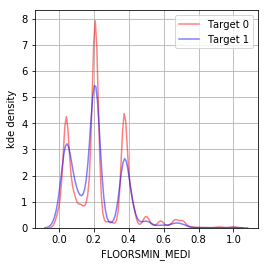

,FLOORSMIN_MEDI_TARGET_0,FLOORSMIN_MEDI_TARGET_1
count,92052.000000,6817.000000
mean,0.233097,0.211754
std,0.162759,0.148931
min,0.000000,0.000000
25%,0.083300,0.083300
50%,0.208300,0.208300
75%,0.375000,0.333300
max,1.000000,1.000000


In [77]:
var_names = var_float.columns
var = var_names[47]
print('Float variable name:', var)
# % missing value
print('% missing value', app_train[var].isnull().sum()/len(app_train[var])* 100)
# distribution of variable:
sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, var], label = 'Target 0', color='red', alpha=0.5)
sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, var], label = 'Target 1', color='blue', alpha=0.5)
plt.xlabel(var)
plt.ylabel('kde density')
#plt.yscale('log')
plt.grid(True)
plt.rcParams['figure.figsize'] = 4,4
plt.show()

# Statistical summary
# with target '0'
target_0_des = app_train.loc[app_train['TARGET'] == 0, var].describe().rename('FLOORSMIN_MEDI_TARGET_0')
#print('Target 0:', target_0_des)
# with target '1'
target_1_des = app_train.loc[app_train['TARGET'] == 1, var].describe().rename('FLOORSMIN_MEDI_TARGET_1')
#print('Target 1:', target_1_des)
pd.concat([target_0_des, target_1_des], axis=1)

Float variable name: LANDAREA_MEDI
% missing value 59.376737742714894


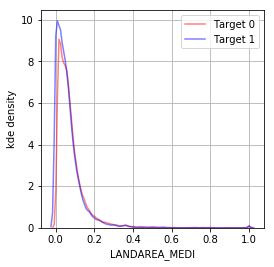

,LANDAREA_MEDI_TARGET_0,LANDAREA_MEDI_TARGET_1
count,116200.000000,8721.000000
mean,0.067422,0.063793
std,0.082242,0.081093
min,0.000000,0.000000
25%,0.018800,0.017900
50%,0.048900,0.045400
75%,0.087100,0.081800
max,1.000000,1.000000


In [79]:
var_names = var_float.columns
var = var_names[48]
print('Float variable name:', var)
# % missing value
print('% missing value', app_train[var].isnull().sum()/len(app_train[var])* 100)
# distribution of variable:
sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, var], label = 'Target 0', color='red', alpha=0.5)
sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, var], label = 'Target 1', color='blue', alpha=0.5)
plt.xlabel(var)
plt.ylabel('kde density')
#plt.yscale('log')
plt.grid(True)
plt.rcParams['figure.figsize'] = 4,4
plt.show()

# Statistical summary
# with target '0'
target_0_des = app_train.loc[app_train['TARGET'] == 0, var].describe().rename('LANDAREA_MEDI_TARGET_0')
#print('Target 0:', target_0_des)
# with target '1'
target_1_des = app_train.loc[app_train['TARGET'] == 1, var].describe().rename('LANDAREA_MEDI_TARGET_1')
#print('Target 1:', target_1_des)
pd.concat([target_0_des, target_1_des], axis=1)

Float variable name: LIVINGAPARTMENTS_MEDI
% missing value 68.35495315614726


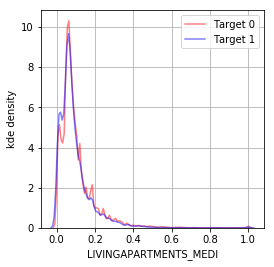

,LIVINGAPARTMENTS_MEDI_TARGET_0,LIVINGAPARTMENTS_MEDI_TARGET_1
count,90609.000000,6703.000000
mean,0.102582,0.093478
std,0.093956,0.088873
min,0.000000,0.000000
25%,0.051300,0.045700
50%,0.077000,0.068400
75%,0.123100,0.118000
max,1.000000,1.000000


In [81]:
var_names = var_float.columns
var = var_names[49]
print('Float variable name:', var)
# % missing value
print('% missing value', app_train[var].isnull().sum()/len(app_train[var])* 100)
# distribution of variable:
sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, var], label = 'Target 0', color='red', alpha=0.5)
sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, var], label = 'Target 1', color='blue', alpha=0.5)
plt.xlabel(var)
plt.ylabel('kde density')
#plt.yscale('log')
plt.grid(True)
plt.rcParams['figure.figsize'] = 4,4
plt.show()

# Statistical summary
# with target '0'
target_0_des = app_train.loc[app_train['TARGET'] == 0, var].describe().rename('LIVINGAPARTMENTS_MEDI_TARGET_0')
#print('Target 0:', target_0_des)
# with target '1'
target_1_des = app_train.loc[app_train['TARGET'] == 1, var].describe().rename('LIVINGAPARTMENTS_MEDI_TARGET_1')
#print('Target 1:', target_1_des)
pd.concat([target_0_des, target_1_des], axis=1)

Float variable name: LIVINGAREA_MEDI
% missing value 50.193326417591564


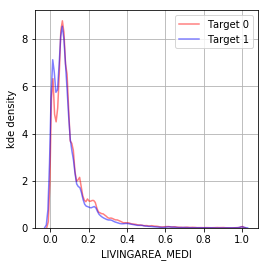

,LIVINGAREA_MEDI_TARGET_0,LIVINGAREA_MEDI_TARGET_1
count,142447.000000,10714.000000
mean,0.109615,0.095206
std,0.112933,0.101968
min,0.000000,0.000000
25%,0.046500,0.035700
50%,0.075800,0.067700
75%,0.131900,0.115200
max,1.000000,1.000000


In [596]:
var_names = var_float.columns
var = var_names[50]
print('Float variable name:', var)
# % missing value
print('% missing value', app_train[var].isnull().sum()/len(app_train[var])* 100)
# distribution of variable:
sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, var], label = 'Target 0', color='red', alpha=0.5)
sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, var], label = 'Target 1', color='blue', alpha=0.5)
plt.xlabel(var)
plt.ylabel('kde density')
#plt.yscale('log')
plt.grid(True)
plt.rcParams['figure.figsize'] = 4,4
plt.show()

# Statistical summary
# with target '0'
target_0_des = app_train.loc[app_train['TARGET'] == 0, var].describe().rename('LIVINGAREA_MEDI_TARGET_0')
#print('Target 0:', target_0_des)
# with target '1'
target_1_des = app_train.loc[app_train['TARGET'] == 1, var].describe().rename('LIVINGAREA_MEDI_TARGET_1')
#print('Target 1:', target_1_des)
pd.concat([target_0_des, target_1_des], axis=1)

Float variable name: NONLIVINGAPARTMENTS_MEDI
% missing value 69.43296337366793


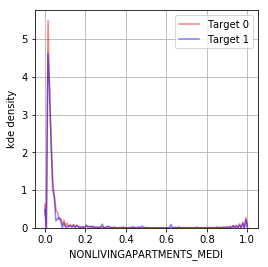

,NONLIVINGAPARTMENTS_MEDI_TARGET_0,NONLIVINGAPARTMENTS_MEDI_TARGET_1
count,87499.000000,6498.000000
mean,0.008687,0.008171
std,0.047468,0.046690
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.003900,0.003900
max,1.000000,1.000000


In [598]:
var_names = var_float.columns
var = var_names[51]
print('Float variable name:', var)
# % missing value
print('% missing value', app_train[var].isnull().sum()/len(app_train[var])* 100)
# distribution of variable:
sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, var], label = 'Target 0', color='red', alpha=0.5)
sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, var], label = 'Target 1', color='blue', alpha=0.5)
plt.xlabel(var)
plt.ylabel('kde density')
#plt.yscale('log')
plt.grid(True)
plt.rcParams['figure.figsize'] = 4,4
plt.show()

# Statistical summary
# with target '0'
target_0_des = app_train.loc[app_train['TARGET'] == 0, var].describe().rename('NONLIVINGAPARTMENTS_MEDI_TARGET_0')
#print('Target 0:', target_0_des)
# with target '1'
target_1_des = app_train.loc[app_train['TARGET'] == 1, var].describe().rename('NONLIVINGAPARTMENTS_MEDI_TARGET_1')
#print('Target 1:', target_1_des)
pd.concat([target_0_des, target_1_des], axis=1)

Float variable name: NONLIVINGAREA_MEDI
% missing value 55.17916432257708


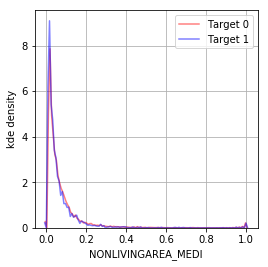

,NONLIVINGAREA_MEDI_TARGET_0,NONLIVINGAREA_MEDI_TARGET_1
count,128334.000000,9495.000000
mean,0.028490,0.024796
std,0.070652,0.063137
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.003100,0.002300
75%,0.026800,0.023000
max,1.000000,1.000000


In [87]:
var_names = var_float.columns
var = var_names[52]
print('Float variable name:', var)
# % missing value
print('% missing value', app_train[var].isnull().sum()/len(app_train[var])* 100)
# distribution of variable:
sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, var], label = 'Target 0', color='red', alpha=0.5)
sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, var], label = 'Target 1', color='blue', alpha=0.5)
plt.xlabel(var)
plt.ylabel('kde density')
#plt.yscale('log')
plt.grid(True)
plt.rcParams['figure.figsize'] = 4,4
plt.show()

# Statistical summary
# with target '0'
target_0_des = app_train.loc[app_train['TARGET'] == 0, var].describe().rename('NONLIVINGAREA_MEDI_TARGET_0')
#print('Target 0:', target_0_des)
# with target '1'
target_1_des = app_train.loc[app_train['TARGET'] == 1, var].describe().rename('NONLIVINGAREA_MEDI_TARGET_1')
#print('Target 1:', target_1_des)
pd.concat([target_0_des, target_1_des], axis=1)

Float variable name: TOTALAREA_MODE
% missing value 48.26851722377411


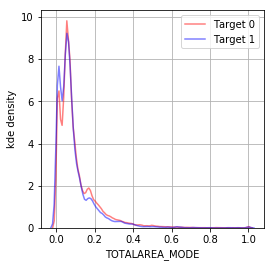

,TOTALAREA_MODE_TARGET_0,TOTALAREA_MODE_TARGET_1
count,147961.000000,11119.000000
mean,0.103507,0.089769
std,0.108043,0.098530
min,0.000000,0.000000
25%,0.041700,0.031600
50%,0.069100,0.061700
75%,0.129500,0.108400
max,1.000000,1.000000


In [600]:
var_names = var_float.columns
var = var_names[53]
print('Float variable name:', var)
# % missing value
print('% missing value', app_train[var].isnull().sum()/len(app_train[var])* 100)
# distribution of variable:
sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, var], label = 'Target 0', color='red', alpha=0.5)
sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, var], label = 'Target 1', color='blue', alpha=0.5)
plt.xlabel(var)
plt.ylabel('kde density')
#plt.yscale('log')
plt.grid(True)
plt.rcParams['figure.figsize'] = 4,4
plt.show()

# Statistical summary
# with target '0'
target_0_des = app_train.loc[app_train['TARGET'] == 0, var].describe().rename('TOTALAREA_MODE_TARGET_0')
#print('Target 0:', target_0_des)
# with target '1'
target_1_des = app_train.loc[app_train['TARGET'] == 1, var].describe().rename('TOTALAREA_MODE_TARGET_1')
#print('Target 1:', target_1_des)
pd.concat([target_0_des, target_1_des], axis=1)

Float variable name: OBS_30_CNT_SOCIAL_CIRCLE
% missing value 0.3320206431639844


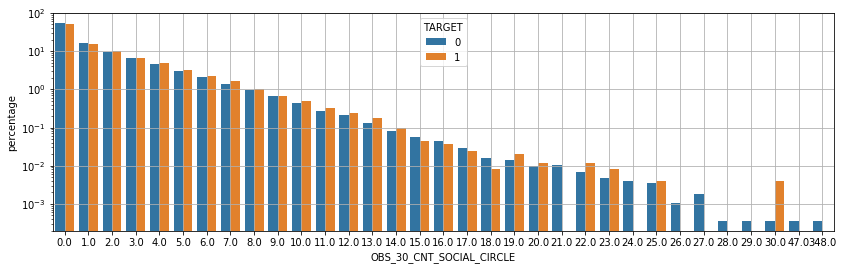

,OBS_30_CNT_SOCIAL_CIRCLE,OBS_30_CNT_SOCIAL_CIRCLE
count,281701.000000,24789.000000
mean,1.415742,1.496147
std,2.402858,2.378438
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,2.000000,2.000000
max,348.000000,30.000000


In [517]:
var_names = var_float.columns
var = var_names[54]
print('Float variable name:', var)
# % missing value
print('% missing value', app_train[var].isnull().sum()/len(app_train[var])* 100)
# distribution of variable:
A = app_train.loc[app_train['TARGET'] == 0, var]
B = app_train.loc[app_train['TARGET'] == 1, var]
var_n = (var_float.groupby([app_train['TARGET']])[var].value_counts(normalize=True)
         .rename('percentage').mul(100).reset_index().sort_values(var))
plt.rcParams['figure.figsize'] = 14,4
sns.barplot(x=var, y='percentage', hue='TARGET', data=var_n)
plt.grid(True)
plt.yscale('log')
plt.show()
# Statistical summary
# with target '0'
target_0_des = app_train.loc[app_train['TARGET'] == 0, var].describe().rename(var)
#print('Target 0:', target_0_des)
# with target '1'
target_1_des = app_train.loc[app_train['TARGET'] == 1, var].describe().rename(var)
#print('Target 1:', target_1_des)
pd.concat([target_0_des, target_1_des], axis=1)

Float variable name: DEF_30_CNT_SOCIAL_CIRCLE
% missing value 0.3320206431639844


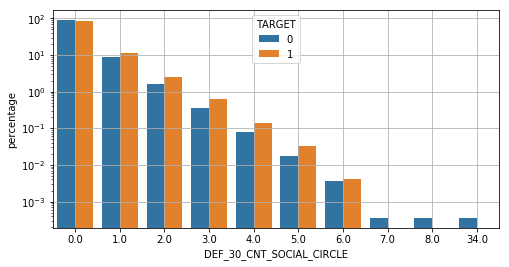

,DEF_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE
count,281701.000000,24789.000000
mean,0.139148,0.191980
std,0.439768,0.516524
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.000000,0.000000
max,34.000000,6.000000


In [520]:
var_names = var_float.columns
var = var_names[55]
print('Float variable name:', var)
# % missing value
print('% missing value', app_train[var].isnull().sum()/len(app_train[var])* 100)
# distribution of variable:
A = app_train.loc[app_train['TARGET'] == 0, var]
B = app_train.loc[app_train['TARGET'] == 1, var]
var_n = (var_float.groupby([app_train['TARGET']])[var].value_counts(normalize=True)
         .rename('percentage').mul(100).reset_index().sort_values(var))
plt.rcParams['figure.figsize'] = 8,4
sns.barplot(x=var, y='percentage', hue='TARGET', data=var_n)
plt.grid(True)
plt.yscale('log')
plt.show()
# Statistical summary
# with target '0'
target_0_des = app_train.loc[app_train['TARGET'] == 0, var].describe().rename(var)
#print('Target 0:', target_0_des)
# with target '1'
target_1_des = app_train.loc[app_train['TARGET'] == 1, var].describe().rename(var)
#print('Target 1:', target_1_des)
pd.concat([target_0_des, target_1_des], axis=1)

Float variable name: OBS_60_CNT_SOCIAL_CIRCLE
% missing value 0.3320206431639844


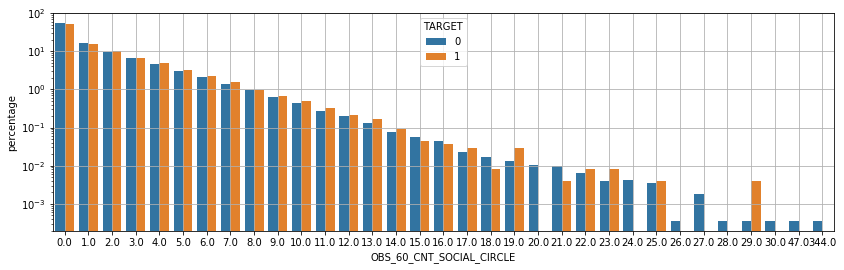

,OBS_60_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE
count,281701.000000,24789.000000
mean,1.398923,1.477672
std,2.381793,2.355908
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,2.000000,2.000000
max,344.000000,29.000000


In [523]:
var_names = var_float.columns
var = var_names[56]
print('Float variable name:', var)
# % missing value
print('% missing value', app_train[var].isnull().sum()/len(app_train[var])* 100)
# distribution of variable:
A = app_train.loc[app_train['TARGET'] == 0, var]
B = app_train.loc[app_train['TARGET'] == 1, var]
var_n = (var_float.groupby([app_train['TARGET']])[var].value_counts(normalize=True)
         .rename('percentage').mul(100).reset_index().sort_values(var))
plt.rcParams['figure.figsize'] = 14,4
sns.barplot(x=var, y='percentage', hue='TARGET', data=var_n)
plt.grid(True)
plt.yscale('log')
plt.show()
# Statistical summary
# with target '0'
target_0_des = app_train.loc[app_train['TARGET'] == 0, var].describe().rename(var)
#print('Target 0:', target_0_des)
# with target '1'
target_1_des = app_train.loc[app_train['TARGET'] == 1, var].describe().rename(var)
#print('Target 1:', target_1_des)
pd.concat([target_0_des, target_1_des], axis=1)

Float variable name: DEF_60_CNT_SOCIAL_CIRCLE
% missing value 0.3320206431639844


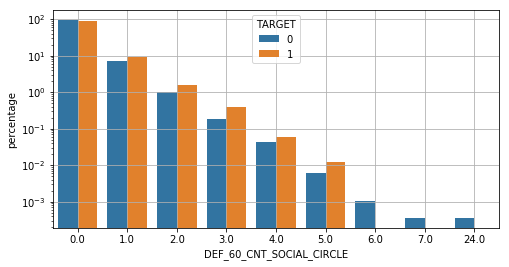

,DEF_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE
count,281701.000000,24789.000000
mean,0.096688,0.138247
std,0.355771,0.427645
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.000000,0.000000
max,24.000000,5.000000


In [524]:
var_names = var_float.columns
var = var_names[57]
print('Float variable name:', var)
# % missing value
print('% missing value', app_train[var].isnull().sum()/len(app_train[var])* 100)
# distribution of variable:
A = app_train.loc[app_train['TARGET'] == 0, var]
B = app_train.loc[app_train['TARGET'] == 1, var]
var_n = (var_float.groupby([app_train['TARGET']])[var].value_counts(normalize=True)
         .rename('percentage').mul(100).reset_index().sort_values(var))
plt.rcParams['figure.figsize'] = 8,4
sns.barplot(x=var, y='percentage', hue='TARGET', data=var_n)
plt.grid(True)
plt.yscale('log')
plt.show()
# Statistical summary
# with target '0'
target_0_des = app_train.loc[app_train['TARGET'] == 0, var].describe().rename(var)
#print('Target 0:', target_0_des)
# with target '1'
target_1_des = app_train.loc[app_train['TARGET'] == 1, var].describe().rename(var)
#print('Target 1:', target_1_des)
pd.concat([target_0_des, target_1_des], axis=1)

Float variable name: DAYS_LAST_PHONE_CHANGE
% missing value 0.00032519161916159093


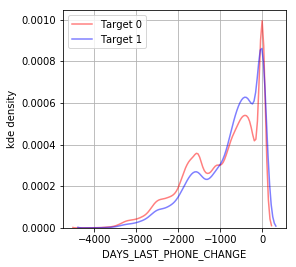

,DAYS_LAST_PHONE_CHANGE_TARGET_0,DAYS_LAST_PHONE_CHANGE_TARGET_1
count,282685.000000,24825.000000
mean,-976.388294,-808.796818
std,831.210739,758.090713
min,-4292.000000,-4070.000000
25%,-1586.000000,-1301.000000
50%,-776.000000,-594.000000
75%,-281.000000,-194.000000
max,0.000000,0.000000


In [103]:
var_names = var_float.columns
var = var_names[58]
print('Float variable name:', var)
# % missing value
print('% missing value', app_train[var].isnull().sum()/len(app_train[var])* 100)
# distribution of variable:
sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, var], label = 'Target 0', color='red', alpha=0.5)
sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, var], label = 'Target 1', color='blue', alpha=0.5)
plt.xlabel(var)
plt.ylabel('kde density')
#plt.yscale('log')
plt.grid(True)
plt.rcParams['figure.figsize'] = 4,4
plt.show()

# Statistical summary
# with target '0'
target_0_des = app_train.loc[app_train['TARGET'] == 0, var].describe().rename('DAYS_LAST_PHONE_CHANGE_TARGET_0')
#print('Target 0:', target_0_des)
# with target '1'
target_1_des = app_train.loc[app_train['TARGET'] == 1, var].describe().rename('DAYS_LAST_PHONE_CHANGE_TARGET_1')
#print('Target 1:', target_1_des)
pd.concat([target_0_des, target_1_des], axis=1)

Float variable name: AMT_REQ_CREDIT_BUREAU_HOUR
% missing value 13.501630835970097


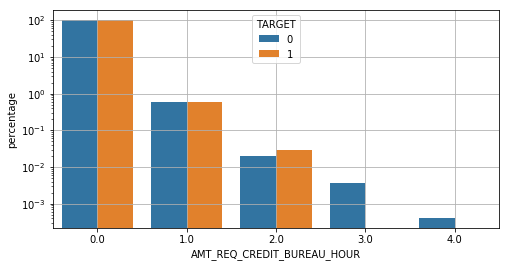

,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_HOUR
count,245459.000000,20533.000000
mean,0.006380,0.006672
std,0.083759,0.084926
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.000000,0.000000
max,4.000000,2.000000


In [526]:
var_names = var_float.columns
var = var_names[59]
print('Float variable name:', var)
# % missing value
print('% missing value', app_train[var].isnull().sum()/len(app_train[var])* 100)
# distribution of variable:
A = app_train.loc[app_train['TARGET'] == 0, var]
B = app_train.loc[app_train['TARGET'] == 1, var]
var_n = (var_float.groupby([app_train['TARGET']])[var].value_counts(normalize=True)
         .rename('percentage').mul(100).reset_index().sort_values(var))
plt.rcParams['figure.figsize'] = 8,4
sns.barplot(x=var, y='percentage', hue='TARGET', data=var_n)
plt.grid(True)
plt.yscale('log')
plt.show()
# Statistical summary
# with target '0'
target_0_des = app_train.loc[app_train['TARGET'] == 0, var].describe().rename(var)
#print('Target 0:', target_0_des)
# with target '1'
target_1_des = app_train.loc[app_train['TARGET'] == 1, var].describe().rename(var)
#print('Target 1:', target_1_des)
pd.concat([target_0_des, target_1_des], axis=1)

Float variable name: AMT_REQ_CREDIT_BUREAU_DAY
% missing value 13.501630835970097


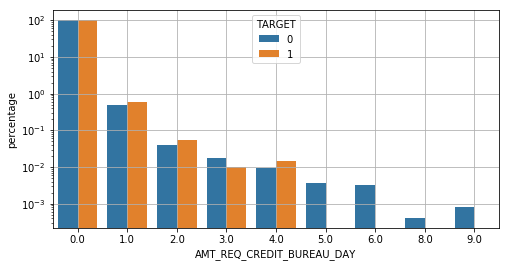

,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_DAY
count,245459.000000,20533.000000
mean,0.006914,0.008036
std,0.111091,0.106682
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.000000,0.000000
max,9.000000,4.000000


In [527]:
var_names = var_float.columns
var = var_names[60]
print('Float variable name:', var)
# % missing value
print('% missing value', app_train[var].isnull().sum()/len(app_train[var])* 100)
# distribution of variable:
A = app_train.loc[app_train['TARGET'] == 0, var]
B = app_train.loc[app_train['TARGET'] == 1, var]
var_n = (var_float.groupby([app_train['TARGET']])[var].value_counts(normalize=True)
         .rename('percentage').mul(100).reset_index().sort_values(var))
plt.rcParams['figure.figsize'] = 8,4
sns.barplot(x=var, y='percentage', hue='TARGET', data=var_n)
plt.grid(True)
plt.yscale('log')
plt.show()
# Statistical summary
# with target '0'
target_0_des = app_train.loc[app_train['TARGET'] == 0, var].describe().rename(var)
#print('Target 0:', target_0_des)
# with target '1'
target_1_des = app_train.loc[app_train['TARGET'] == 1, var].describe().rename(var)
#print('Target 1:', target_1_des)
pd.concat([target_0_des, target_1_des], axis=1)

Float variable name: AMT_REQ_CREDIT_BUREAU_WEEK
% missing value 13.501630835970097


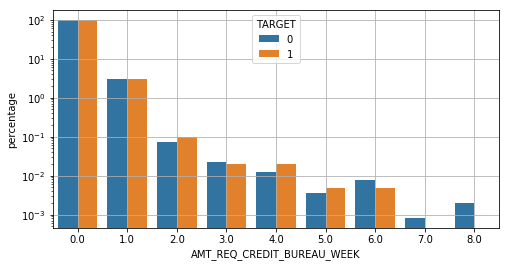

,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_WEEK
count,245459.000000,20533.000000
mean,0.034315,0.034919
std,0.204747,0.203941
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.000000,0.000000
max,8.000000,6.000000


In [528]:
var_names = var_float.columns
var = var_names[61]
print('Float variable name:', var)
# % missing value
print('% missing value', app_train[var].isnull().sum()/len(app_train[var])* 100)
# distribution of variable:
A = app_train.loc[app_train['TARGET'] == 0, var]
B = app_train.loc[app_train['TARGET'] == 1, var]
var_n = (var_float.groupby([app_train['TARGET']])[var].value_counts(normalize=True)
         .rename('percentage').mul(100).reset_index().sort_values(var))
plt.rcParams['figure.figsize'] = 8,4
sns.barplot(x=var, y='percentage', hue='TARGET', data=var_n)
plt.grid(True)
plt.yscale('log')
plt.show()
# Statistical summary
# with target '0'
target_0_des = app_train.loc[app_train['TARGET'] == 0, var].describe().rename(var)
#print('Target 0:', target_0_des)
# with target '1'
target_1_des = app_train.loc[app_train['TARGET'] == 1, var].describe().rename(var)
#print('Target 1:', target_1_des)
pd.concat([target_0_des, target_1_des], axis=1)

Float variable name: AMT_REQ_CREDIT_BUREAU_MON
% missing value 13.501630835970097


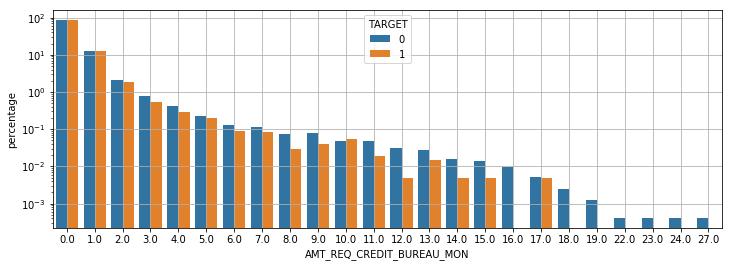

,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_MON
count,245459.000000,20533.000000
mean,0.270697,0.227926
std,0.928799,0.745116
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.000000,0.000000
max,27.000000,17.000000


In [530]:
var_names = var_float.columns
var = var_names[62]
print('Float variable name:', var)
# % missing value
print('% missing value', app_train[var].isnull().sum()/len(app_train[var])* 100)
# distribution of variable:
A = app_train.loc[app_train['TARGET'] == 0, var]
B = app_train.loc[app_train['TARGET'] == 1, var]
var_n = (var_float.groupby([app_train['TARGET']])[var].value_counts(normalize=True)
         .rename('percentage').mul(100).reset_index().sort_values(var))
plt.rcParams['figure.figsize'] = 12,4
sns.barplot(x=var, y='percentage', hue='TARGET', data=var_n)
plt.grid(True)
plt.yscale('log')
plt.show()
# Statistical summary
# with target '0'
target_0_des = app_train.loc[app_train['TARGET'] == 0, var].describe().rename(var)
#print('Target 0:', target_0_des)
# with target '1'
target_1_des = app_train.loc[app_train['TARGET'] == 1, var].describe().rename(var)
#print('Target 1:', target_1_des)
pd.concat([target_0_des, target_1_des], axis=1)

Float variable name: AMT_REQ_CREDIT_BUREAU_QRT
% missing value 13.501630835970097


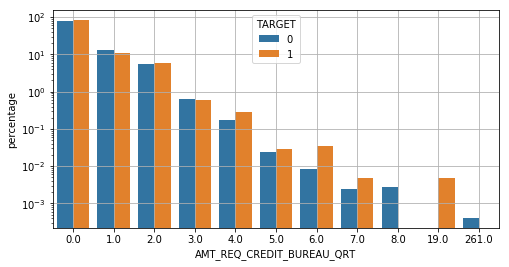

,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_QRT
count,245459.000000,20533.000000
mean,0.265939,0.259923
std,0.805355,0.643789
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.000000,0.000000
max,261.000000,19.000000


In [531]:
var_names = var_float.columns
var = var_names[63]
print('Float variable name:', var)
# % missing value
print('% missing value', app_train[var].isnull().sum()/len(app_train[var])* 100)
# distribution of variable:
A = app_train.loc[app_train['TARGET'] == 0, var]
B = app_train.loc[app_train['TARGET'] == 1, var]
var_n = (var_float.groupby([app_train['TARGET']])[var].value_counts(normalize=True)
         .rename('percentage').mul(100).reset_index().sort_values(var))
plt.rcParams['figure.figsize'] = 8,4
sns.barplot(x=var, y='percentage', hue='TARGET', data=var_n)
plt.grid(True)
plt.yscale('log')
plt.show()
# Statistical summary
# with target '0'
target_0_des = app_train.loc[app_train['TARGET'] == 0, var].describe().rename(var)
#print('Target 0:', target_0_des)
# with target '1'
target_1_des = app_train.loc[app_train['TARGET'] == 1, var].describe().rename(var)
#print('Target 1:', target_1_des)
pd.concat([target_0_des, target_1_des], axis=1)

Float variable name: AMT_REQ_CREDIT_BUREAU_YEAR
% missing value 13.501630835970097


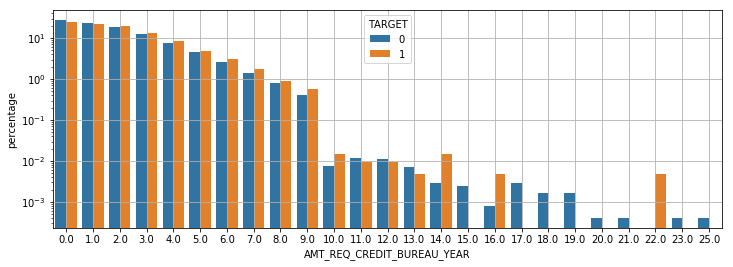

,AMT_REQ_CREDIT_BUREAU_YEAR,AMT_REQ_CREDIT_BUREAU_YEAR
count,245459.000000,20533.000000
mean,1.889199,2.028783
std,1.863376,1.934063
min,0.000000,0.000000
25%,0.000000,1.000000
50%,1.000000,2.000000
75%,3.000000,3.000000
max,25.000000,22.000000


In [533]:
var_names = var_float.columns
var = var_names[64]
print('Float variable name:', var)
# % missing value
print('% missing value', app_train[var].isnull().sum()/len(app_train[var])* 100)
# distribution of variable:
A = app_train.loc[app_train['TARGET'] == 0, var]
B = app_train.loc[app_train['TARGET'] == 1, var]
var_n = (var_float.groupby([app_train['TARGET']])[var].value_counts(normalize=True)
         .rename('percentage').mul(100).reset_index().sort_values(var))
plt.rcParams['figure.figsize'] = 12,4
sns.barplot(x=var, y='percentage', hue='TARGET', data=var_n)
plt.grid(True)
plt.yscale('log')
plt.show()
# Statistical summary
# with target '0'
target_0_des = app_train.loc[app_train['TARGET'] == 0, var].describe().rename(var)
#print('Target 0:', target_0_des)
# with target '1'
target_1_des = app_train.loc[app_train['TARGET'] == 1, var].describe().rename(var)
#print('Target 1:', target_1_des)
pd.concat([target_0_des, target_1_des], axis=1)

## Variable type: Integer

In [175]:
var_int_cnt = var_int.drop(columns = ['CNT_CHILDREN', 'HOUR_APPR_PROCESS_START', 'DAYS_EMPLOYED', 'DAYS_BIRTH', 'SK_ID_CURR', 'DAYS_ID_PUBLISH'])
var_names = var_int_cnt.columns
var_names[0]

'TARGET'

Integer variable name: FLAG_MOBIL
% missing value 0.0


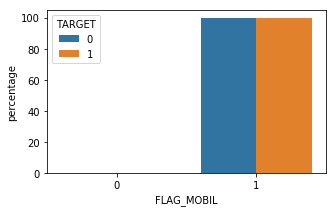

Group summary
    TARGET  FLAG_MOBIL  percentage
1       0           0    0.000354
0       0           1   99.999646
2       1           1  100.000000

Statistical summary:
        FLAG_MOBIL_TARGET_0  FLAG_MOBIL_TARGET_1
count        282686.000000              24825.0
mean              0.999996                  1.0
std               0.001881                  0.0
min               0.000000                  1.0
25%               1.000000                  1.0
50%               1.000000                  1.0
75%               1.000000                  1.0
max               1.000000                  1.0


In [539]:
var_int_cnt = var_int.drop(columns = ['CNT_CHILDREN', 'HOUR_APPR_PROCESS_START', 'DAYS_EMPLOYED', 'DAYS_BIRTH', 'SK_ID_CURR', 'DAYS_ID_PUBLISH'])
var_names = var_int_cnt.columns
var_n = var_names[1]
print('Integer variable name:', var_n)
# % missing value
print('% missing value', app_train[var_n].isnull().sum()/len(app_train[var_n])* 100)
# distribution of variable:
# This is how we have to present the bar plot: using the percentage, not count
var = (var_int_cnt.groupby([var_names[0]])[var_names[1]].value_counts(normalize=True).rename('percentage').mul(100).reset_index().sort_values(var_names[1]))
plt.rcParams['figure.figsize'] = 5,3
sns.barplot(x="FLAG_MOBIL", y='percentage', hue='TARGET', data=var)
plt.show()
# Statistical summary
target_0_des = app_train.loc[app_train['TARGET'] == 0, var_n].describe().rename('FLAG_MOBIL_TARGET_0')
target_1_des = app_train.loc[app_train['TARGET'] == 1, var_n].describe().rename('FLAG_MOBIL_TARGET_1')
#print('Target 1:', target_1_des)
print('Group summary\n', var)
print('\nStatistical summary:\n', pd.concat([target_0_des, target_1_des], axis=1))

All data are flagged as 1. So we can get rid of this variable.

Integer variable name: FLAG_EMP_PHONE
% missing value 0.0


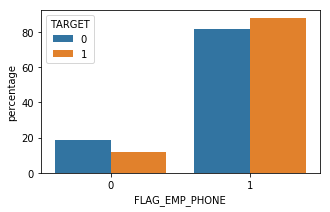

Group summary
    TARGET  FLAG_EMP_PHONE  percentage
1       0               0   18.534699
3       1               0   12.048338
0       0               1   81.465301
2       1               1   87.951662

Statistical summary:
        FLAG_EMP_PHONE_TARGET_0  FLAG_EMP_PHONE_TARGET_1
count            282686.000000             24825.000000
mean                  0.814653                 0.879517
std                   0.388579                 0.325532
min                   0.000000                 0.000000
25%                   1.000000                 1.000000
50%                   1.000000                 1.000000
75%                   1.000000                 1.000000
max                   1.000000                 1.000000


In [561]:
var_int_cnt = var_int.drop(columns = ['CNT_CHILDREN', 'HOUR_APPR_PROCESS_START', 'DAYS_EMPLOYED', 'DAYS_BIRTH', 'SK_ID_CURR', 'DAYS_ID_PUBLISH'])
var_names = var_int_cnt.columns
var_n = var_names[2]
print('Integer variable name:', var_n)
# % missing value
print('% missing value', app_train[var_n].isnull().sum()/len(app_train[var_n])* 100)
# distribution of variable:
# This is how we have to present the bar plot: using the percentage, not count
var = (var_int_cnt.groupby([var_names[0]])[var_names[2]].value_counts(normalize=True).rename('percentage').mul(100).reset_index().sort_values(var_names[2]))
sns.barplot(x="FLAG_EMP_PHONE", y='percentage', hue='TARGET', data=var)
plt.show()
# Statistical summary
target_0_des = app_train.loc[app_train['TARGET'] == 0, var_n].describe().rename('FLAG_EMP_PHONE_TARGET_0')
target_1_des = app_train.loc[app_train['TARGET'] == 1, var_n].describe().rename('FLAG_EMP_PHONE_TARGET_1')
#print('Target 1:', target_1_des)
print('Group summary\n', var)
print('\nStatistical summary:\n', pd.concat([target_0_des, target_1_des], axis=1))

Integer variable name: FLAG_WORK_PHONE
% missing value 0.0


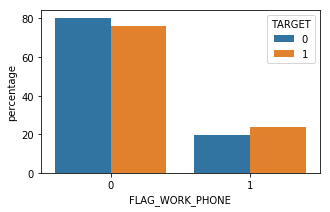

Group summary
    TARGET  FLAG_WORK_PHONE  percentage
0       0                0   80.400869
2       1                0   76.217523
1       0                1   19.599131
3       1                1   23.782477

Statistical summary:
        FLAG_WORK_PHONE_TARGET_0  FLAG_WORK_PHONE_TARGET_1
count             282686.000000              24825.000000
mean                   0.195991                  0.237825
std                    0.396963                  0.425760
min                    0.000000                  0.000000
25%                    0.000000                  0.000000
50%                    0.000000                  0.000000
75%                    0.000000                  0.000000
max                    1.000000                  1.000000


In [563]:
var_int_cnt = var_int.drop(columns = ['CNT_CHILDREN', 'HOUR_APPR_PROCESS_START', 'DAYS_EMPLOYED', 'DAYS_BIRTH', 'SK_ID_CURR', 'DAYS_ID_PUBLISH'])
var_names = var_int_cnt.columns
var_n = var_names[3]
print('Integer variable name:', var_n)
# % missing value
print('% missing value', app_train[var_n].isnull().sum()/len(app_train[var_n])* 100)
# distribution of variable:
# This is how we have to present the bar plot: using the percentage, not count
var = (var_int_cnt.groupby([var_names[0]])[var_names[3]].value_counts(normalize=True).rename('percentage').mul(100).reset_index().sort_values(var_names[3]))
sns.barplot(x="FLAG_WORK_PHONE", y='percentage', hue='TARGET', data=var)
plt.show()
# Statistical summary
target_0_des = app_train.loc[app_train['TARGET'] == 0, var_n].describe().rename('FLAG_WORK_PHONE_TARGET_0')
target_1_des = app_train.loc[app_train['TARGET'] == 1, var_n].describe().rename('FLAG_WORK_PHONE_TARGET_1')
#print('Target 1:', target_1_des)
print('Group summary\n', var)
print('\nStatistical summary:\n', pd.concat([target_0_des, target_1_des], axis=1))

Integer variable name: FLAG_CONT_MOBILE
% missing value 0.0


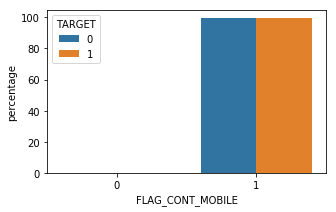

Group summary
    TARGET  FLAG_CONT_MOBILE  percentage
1       0                 0    0.187133
3       1                 0    0.181269
0       0                 1   99.812867
2       1                 1   99.818731

Statistical summary:
        FLAG_CONT_MOBILE_TARGET_0  FLAG_CONT_MOBILE_TARGET_1
count              282686.000000               24825.000000
mean                    0.998129                   0.998187
std                     0.043219                   0.042538
min                     0.000000                   0.000000
25%                     1.000000                   1.000000
50%                     1.000000                   1.000000
75%                     1.000000                   1.000000
max                     1.000000                   1.000000


In [564]:
var_int_cnt = var_int.drop(columns = ['CNT_CHILDREN', 'HOUR_APPR_PROCESS_START', 'DAYS_EMPLOYED', 'DAYS_BIRTH', 'SK_ID_CURR', 'DAYS_ID_PUBLISH'])
var_names = var_int_cnt.columns
var_n = var_names[4]
print('Integer variable name:', var_n)
# % missing value
print('% missing value', app_train[var_n].isnull().sum()/len(app_train[var_n])* 100)
# distribution of variable:
# This is how we have to present the bar plot: using the percentage, not count
var = (var_int_cnt.groupby([var_names[0]])[var_names[4]].value_counts(normalize=True).rename('percentage').mul(100).reset_index().sort_values(var_names[4]))
sns.barplot(x="FLAG_CONT_MOBILE", y='percentage', hue='TARGET', data=var)
plt.show()
# Statistical summary
target_0_des = app_train.loc[app_train['TARGET'] == 0, var_n].describe().rename('FLAG_CONT_MOBILE_TARGET_0')
target_1_des = app_train.loc[app_train['TARGET'] == 1, var_n].describe().rename('FLAG_CONT_MOBILE_TARGET_1')
#print('Target 1:', target_1_des)
print('Group summary\n', var)
print('\nStatistical summary:\n', pd.concat([target_0_des, target_1_des], axis=1))

This variable also does not make any difference

Integer variable name: FLAG_PHONE
% missing value 0.0


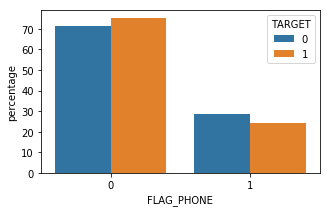

Group summary
    TARGET  FLAG_PHONE  percentage
0       0           0   71.576237
2       1           0   75.504532
1       0           1   28.423763
3       1           1   24.495468

Statistical summary:
        FLAG_PHONE_TARGET_0  FLAG_PHONE_TARGET_1
count        282686.000000         24825.000000
mean              0.284238             0.244955
std               0.451051             0.430069
min               0.000000             0.000000
25%               0.000000             0.000000
50%               0.000000             0.000000
75%               1.000000             0.000000
max               1.000000             1.000000


In [565]:
var_int_cnt = var_int.drop(columns = ['CNT_CHILDREN', 'HOUR_APPR_PROCESS_START', 'DAYS_EMPLOYED', 'DAYS_BIRTH', 'SK_ID_CURR', 'DAYS_ID_PUBLISH'])
var_names = var_int_cnt.columns
var_n = var_names[5]
print('Integer variable name:', var_n)
# % missing value
print('% missing value', app_train[var_n].isnull().sum()/len(app_train[var_n])* 100)
# distribution of variable:
# This is how we have to present the bar plot: using the percentage, not count
var = (var_int_cnt.groupby([var_names[0]])[var_names[5]].value_counts(normalize=True).rename('percentage').mul(100).reset_index().sort_values(var_names[5]))
sns.barplot(x="FLAG_PHONE", y='percentage', hue='TARGET', data=var)
plt.show()
# Statistical summary
target_0_des = app_train.loc[app_train['TARGET'] == 0, var_n].describe().rename('FLAG_PHONE_TARGET_0')
target_1_des = app_train.loc[app_train['TARGET'] == 1, var_n].describe().rename('FLAG_PHONE_TARGET_1')
#print('Target 1:', target_1_des)
print('Group summary\n', var)
print('\nStatistical summary:\n', pd.concat([target_0_des, target_1_des], axis=1))

Integer variable name: FLAG_EMAIL
% missing value 0.0


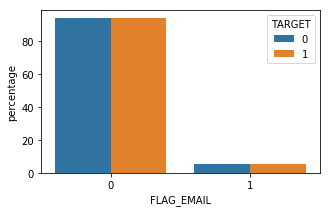

Group summary
    TARGET  FLAG_EMAIL  percentage
0       0           0   94.315955
2       1           0   94.465257
1       0           1    5.684045
3       1           1    5.534743

Statistical summary:
        FLAG_MOBIL_TARGET_0  FLAG_MOBIL_TARGET_1
count        282686.000000         24825.000000
mean              0.056840             0.055347
std               0.231538             0.228662
min               0.000000             0.000000
25%               0.000000             0.000000
50%               0.000000             0.000000
75%               0.000000             0.000000
max               1.000000             1.000000


In [544]:
var_int_cnt = var_int.drop(columns = ['CNT_CHILDREN', 'HOUR_APPR_PROCESS_START', 'DAYS_EMPLOYED', 
                                      'DAYS_BIRTH', 'SK_ID_CURR', 'DAYS_ID_PUBLISH'])
var_names = var_int_cnt.columns
var_n = var_names[6]
print('Integer variable name:', var_n)
# % missing value
print('% missing value', app_train[var_n].isnull().sum()/len(app_train[var_n])* 100)
# distribution of variable:
# This is how we have to present the bar plot: using the percentage, not count
var = (var_int_cnt.groupby([var_names[0]])[var_names[6]].value_counts(normalize=True).rename('percentage').
       mul(100).reset_index().sort_values(var_names[6]))
sns.barplot(x="FLAG_EMAIL", y='percentage', hue='TARGET', data=var)
plt.show()
# Statistical summary
target_0_des = app_train.loc[app_train['TARGET'] == 0, var_n].describe().rename('FLAG_MOBIL_TARGET_0')
target_1_des = app_train.loc[app_train['TARGET'] == 1, var_n].describe().rename('FLAG_MOBIL_TARGET_1')
#print('Target 1:', target_1_des)
print('Group summary\n', var)
print('\nStatistical summary:\n', pd.concat([target_0_des, target_1_des], axis=1))

No difference

Integer variable name: REGION_RATING_CLIENT
% missing value 0.0


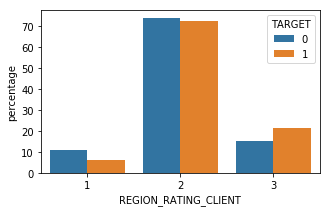

Group summary
    TARGET  REGION_RATING_CLIENT  percentage
2       0                     1   10.840650
5       1                     1    6.251762
0       0                     2   73.960861
3       1                     2   72.132931
1       0                     3   15.198489
4       1                     3   21.615307

Statistical summary:
        REGION_RATING_CLIENT_TARGET_0  REGION_RATING_CLIENT_TARGET_1
count                  282686.000000                   24825.000000
mean                        2.043578                       2.153635
std                         0.508422                       0.505052
min                         1.000000                       1.000000
25%                         2.000000                       2.000000
50%                         2.000000                       2.000000
75%                         2.000000                       2.000000
max                         3.000000                       3.000000


In [566]:
var_int_cnt = var_int.drop(columns = ['CNT_CHILDREN', 'HOUR_APPR_PROCESS_START', 'DAYS_EMPLOYED', 
                                      'DAYS_BIRTH', 'SK_ID_CURR', 'DAYS_ID_PUBLISH'])
var_names = var_int_cnt.columns
var_n = var_names[7]
print('Integer variable name:', var_n)
# % missing value
print('% missing value', app_train[var_n].isnull().sum()/len(app_train[var_n])* 100)
# distribution of variable:
# This is how we have to present the bar plot: using the percentage, not count
var = (var_int_cnt.groupby([var_names[0]])[var_names[7]].value_counts(normalize=True).rename('percentage').
       mul(100).reset_index().sort_values(var_names[7]))
sns.barplot(x="REGION_RATING_CLIENT", y='percentage', hue='TARGET', data=var)
plt.show()
# Statistical summary
target_0_des = app_train.loc[app_train['TARGET'] == 0, var_n].describe().rename('REGION_RATING_CLIENT_TARGET_0')
target_1_des = app_train.loc[app_train['TARGET'] == 1, var_n].describe().rename('REGION_RATING_CLIENT_TARGET_1')
#print('Target 1:', target_1_des)
print('Group summary\n', var)
print('\nStatistical summary:\n', pd.concat([target_0_des, target_1_des], axis=1))

Integer variable name: REGION_RATING_CLIENT_W_CITY
% missing value 0.0


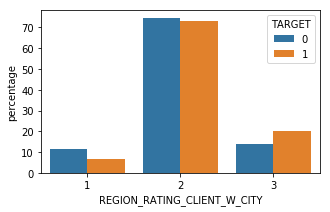

Group summary
    TARGET  REGION_RATING_CLIENT_W_CITY  percentage
2       0                            1   11.501454
5       1                            1    6.662638
0       0                            2   74.752199
3       1                            2   73.192346
1       0                            3   13.746348
4       1                            3   20.145015

Statistical summary:
        FLAG_MOBIL_TARGET_0  FLAG_MOBIL_TARGET_1
count        282686.000000         24825.000000
mean              2.022449             2.134824
std               0.501971             0.499909
min               1.000000             1.000000
25%               2.000000             2.000000
50%               2.000000             2.000000
75%               2.000000             2.000000
max               3.000000             3.000000


In [546]:
var_int_cnt = var_int.drop(columns = ['CNT_CHILDREN', 'HOUR_APPR_PROCESS_START', 'DAYS_EMPLOYED', 
                                      'DAYS_BIRTH', 'SK_ID_CURR', 'DAYS_ID_PUBLISH'])
var_names = var_int_cnt.columns
var_n = var_names[8]
print('Integer variable name:', var_n)
# % missing value
print('% missing value', app_train[var_n].isnull().sum()/len(app_train[var_n])* 100)
# distribution of variable:
# This is how we have to present the bar plot: using the percentage, not count
var = (var_int_cnt.groupby([var_names[0]])[var_names[8]].value_counts(normalize=True).rename('percentage').
       mul(100).reset_index().sort_values(var_names[8]))
sns.barplot(x="REGION_RATING_CLIENT_W_CITY", y='percentage', hue='TARGET', data=var)
plt.show()
# Statistical summary
target_0_des = app_train.loc[app_train['TARGET'] == 0, var_n].describe().rename('FLAG_MOBIL_TARGET_0')
target_1_des = app_train.loc[app_train['TARGET'] == 1, var_n].describe().rename('FLAG_MOBIL_TARGET_1')
#print('Target 1:', target_1_des)
print('Group summary\n', var)
print('\nStatistical summary:\n', pd.concat([target_0_des, target_1_des], axis=1))

Integer variable name: REG_REGION_NOT_LIVE_REGION
% missing value 0.0


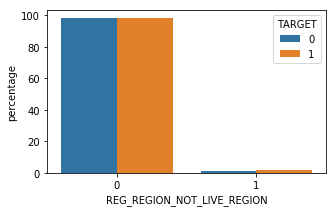

Group summary
    TARGET  REG_REGION_NOT_LIVE_REGION  percentage
0       0                           0   98.505763
2       1                           0   98.255791
1       0                           1    1.494237
3       1                           1    1.744209

Statistical summary:
        REG_REGION_NOT_LIVE_REGION_TARGET_0  \
count                        282686.000000   
mean                              0.014942   
std                               0.121323   
min                               0.000000   
25%                               0.000000   
50%                               0.000000   
75%                               0.000000   
max                               1.000000   

       REG_REGION_NOT_LIVE_REGION_TARGET_1  
count                         24825.000000  
mean                              0.017442  
std                               0.130914  
min                               0.000000  
25%                               0.000000  
50%                        

In [567]:
var_int_cnt = var_int.drop(columns = ['CNT_CHILDREN', 'HOUR_APPR_PROCESS_START', 'DAYS_EMPLOYED', 
                                      'DAYS_BIRTH', 'SK_ID_CURR', 'DAYS_ID_PUBLISH'])
var_names = var_int_cnt.columns
var_n = var_names[9]
print('Integer variable name:', var_n)
# % missing value
print('% missing value', app_train[var_n].isnull().sum()/len(app_train[var_n])* 100)
# distribution of variable:
# This is how we have to present the bar plot: using the percentage, not count
var = (var_int_cnt.groupby([var_names[0]])[var_names[9]].value_counts(normalize=True).rename('percentage').
       mul(100).reset_index().sort_values(var_names[9]))
sns.barplot(x="REG_REGION_NOT_LIVE_REGION", y='percentage', hue='TARGET', data=var)
plt.show()
# Statistical summary
target_0_des = app_train.loc[app_train['TARGET'] == 0, var_n].describe().rename('REG_REGION_NOT_LIVE_REGION_TARGET_0')
target_1_des = app_train.loc[app_train['TARGET'] == 1, var_n].describe().rename('REG_REGION_NOT_LIVE_REGION_TARGET_1')
#print('Target 1:', target_1_des)
print('Group summary\n', var)
print('\nStatistical summary:\n', pd.concat([target_0_des, target_1_des], axis=1))

Not differentiable

Integer variable name: REG_REGION_NOT_WORK_REGION
% missing value 0.0


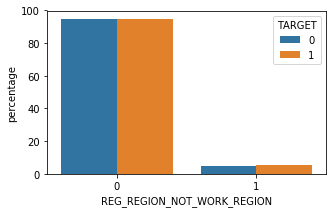

Group summary
    TARGET  REG_REGION_NOT_WORK_REGION  percentage
0       0                           0   94.968269
2       1                           0   94.408862
1       0                           1    5.031731
3       1                           1    5.591138

Statistical summary:
        REG_REGION_NOT_WORK_REGION_TARGET_0  \
count                        282686.000000   
mean                              0.050317   
std                               0.218599   
min                               0.000000   
25%                               0.000000   
50%                               0.000000   
75%                               0.000000   
max                               1.000000   

       REG_REGION_NOT_WORK_REGION_TARGET_1  
count                         24825.000000  
mean                              0.055911  
std                               0.229755  
min                               0.000000  
25%                               0.000000  
50%                        

In [568]:
var_int_cnt = var_int.drop(columns = ['CNT_CHILDREN', 'HOUR_APPR_PROCESS_START', 'DAYS_EMPLOYED', 
                                      'DAYS_BIRTH', 'SK_ID_CURR', 'DAYS_ID_PUBLISH'])
var_names = var_int_cnt.columns
var_n = var_names[10]
print('Integer variable name:', var_n)
# % missing value
print('% missing value', app_train[var_n].isnull().sum()/len(app_train[var_n])* 100)
# distribution of variable:
# This is how we have to present the bar plot: using the percentage, not count
var = (var_int_cnt.groupby([var_names[0]])[var_names[10]].value_counts(normalize=True).rename('percentage').
       mul(100).reset_index().sort_values(var_names[10]))
sns.barplot(x="REG_REGION_NOT_WORK_REGION", y='percentage', hue='TARGET', data=var)
plt.show()
# Statistical summary
target_0_des = app_train.loc[app_train['TARGET'] == 0, var_n].describe().rename('REG_REGION_NOT_WORK_REGION_TARGET_0')
target_1_des = app_train.loc[app_train['TARGET'] == 1, var_n].describe().rename('REG_REGION_NOT_WORK_REGION_TARGET_1')
#print('Target 1:', target_1_des)
print('Group summary\n', var)
print('\nStatistical summary:\n', pd.concat([target_0_des, target_1_des], axis=1))

Integer variable name: LIVE_REGION_NOT_WORK_REGION
% missing value 0.0


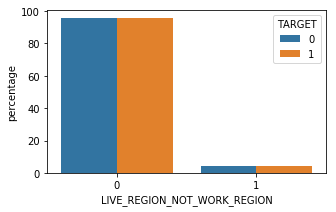

Group summary
    TARGET  LIVE_REGION_NOT_WORK_REGION  percentage
0       0                            0   95.950631
2       1                            0   95.746224
1       0                            1    4.049369
3       1                            1    4.253776

Statistical summary:
        LIVE_REGION_NOT_WORK_REGION_TARGET_0  \
count                         282686.000000   
mean                               0.040494   
std                                0.197114   
min                                0.000000   
25%                                0.000000   
50%                                0.000000   
75%                                0.000000   
max                                1.000000   

       LIVE_REGION_NOT_WORK_REGION_TARGET_1  
count                          24825.000000  
mean                               0.042538  
std                                0.201817  
min                                0.000000  
25%                                0.000000  
50%    

In [569]:
var_int_cnt = var_int.drop(columns = ['CNT_CHILDREN', 'HOUR_APPR_PROCESS_START', 'DAYS_EMPLOYED', 
                                      'DAYS_BIRTH', 'SK_ID_CURR', 'DAYS_ID_PUBLISH'])
var_names = var_int_cnt.columns
var_n = var_names[11]
print('Integer variable name:', var_n)
# % missing value
print('% missing value', app_train[var_n].isnull().sum()/len(app_train[var_n])* 100)
# distribution of variable:
# This is how we have to present the bar plot: using the percentage, not count
var = (var_int_cnt.groupby([var_names[0]])[var_names[11]].value_counts(normalize=True).rename('percentage').
       mul(100).reset_index().sort_values(var_names[11]))
sns.barplot(x="LIVE_REGION_NOT_WORK_REGION", y='percentage', hue='TARGET', data=var)
plt.show()
# Statistical summary
target_0_des = app_train.loc[app_train['TARGET'] == 0, var_n].describe().rename('LIVE_REGION_NOT_WORK_REGION_TARGET_0')
target_1_des = app_train.loc[app_train['TARGET'] == 1, var_n].describe().rename('LIVE_REGION_NOT_WORK_REGION_TARGET_1')
#print('Target 1:', target_1_des)
print('Group summary\n', var)
print('\nStatistical summary:\n', pd.concat([target_0_des, target_1_des], axis=1))

Integer variable name: REG_CITY_NOT_LIVE_CITY
% missing value 0.0


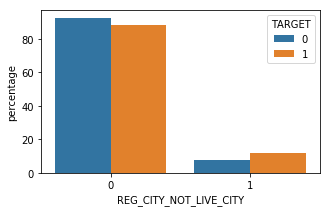

,REG_CITY_NOT_LIVE_CITY_TARGET_0,REG_CITY_NOT_LIVE_CITY_TARGET_1
count,282686.000000,24825.000000
mean,0.074641,0.118389
std,0.262812,0.323074
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.000000,0.000000
max,1.000000,1.000000


In [570]:
var_int_cnt = var_int.drop(columns = ['CNT_CHILDREN', 'HOUR_APPR_PROCESS_START', 'DAYS_EMPLOYED', 
                                      'DAYS_BIRTH', 'SK_ID_CURR', 'DAYS_ID_PUBLISH'])
var_names = var_int_cnt.columns
var_n = var_names[12]
print('Integer variable name:', var_n)
# % missing value
print('% missing value', app_train[var_n].isnull().sum()/len(app_train[var_n])* 100)
# distribution of variable:
# This is how we have to present the bar plot: using the percentage, not count
var = (var_int_cnt.groupby([var_names[0]])[var_names[12]].value_counts(normalize=True).rename('percentage').
       mul(100).reset_index().sort_values(var_names[12]))
sns.barplot(x="REG_CITY_NOT_LIVE_CITY", y='percentage', hue='TARGET', data=var)
plt.show()
# Statistical summary
target_0_des = app_train.loc[app_train['TARGET'] == 0, var_n].describe().rename('REG_CITY_NOT_LIVE_CITY_TARGET_0')
target_1_des = app_train.loc[app_train['TARGET'] == 1, var_n].describe().rename('REG_CITY_NOT_LIVE_CITY_TARGET_1')
#print('Target 1:', target_1_des)
pd.concat([target_0_des, target_1_des], axis=1)

Integer variable name: REG_CITY_NOT_WORK_CITY
% missing value 0.0


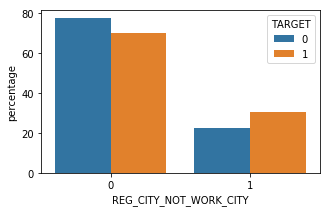

Group summary
    TARGET  REG_CITY_NOT_WORK_CITY  percentage
0       0                       0   77.591037
2       1                       0   69.707956
1       0                       1   22.408963
3       1                       1   30.292044

Statistical summary:
        REG_CITY_NOT_WORK_CITY_TARGET_0  REG_CITY_NOT_WORK_CITY_TARGET_1
count                    282686.000000                      24825.00000
mean                          0.224090                          0.30292
std                           0.416982                          0.45953
min                           0.000000                          0.00000
25%                           0.000000                          0.00000
50%                           0.000000                          0.00000
75%                           0.000000                          1.00000
max                           1.000000                          1.00000


In [571]:
var_int_cnt = var_int.drop(columns = ['CNT_CHILDREN', 'HOUR_APPR_PROCESS_START', 'DAYS_EMPLOYED', 
                                      'DAYS_BIRTH', 'SK_ID_CURR', 'DAYS_ID_PUBLISH'])
var_names = var_int_cnt.columns
var_n = var_names[13]
print('Integer variable name:', var_n)
# % missing value
print('% missing value', app_train[var_n].isnull().sum()/len(app_train[var_n])* 100)
# distribution of variable:
# This is how we have to present the bar plot: using the percentage, not count
var = (var_int_cnt.groupby([var_names[0]])[var_names[13]].value_counts(normalize=True).rename('percentage').
       mul(100).reset_index().sort_values(var_names[13]))
sns.barplot(x="REG_CITY_NOT_WORK_CITY", y='percentage', hue='TARGET', data=var)
plt.show()
# Statistical summary
target_0_des = app_train.loc[app_train['TARGET'] == 0, var_n].describe().rename('REG_CITY_NOT_WORK_CITY_TARGET_0')
target_1_des = app_train.loc[app_train['TARGET'] == 1, var_n].describe().rename('REG_CITY_NOT_WORK_CITY_TARGET_1')
#print('Target 1:', target_1_des)
print('Group summary\n', var)
print('\nStatistical summary:\n', pd.concat([target_0_des, target_1_des], axis=1))

Integer variable name: LIVE_CITY_NOT_WORK_CITY
% missing value 0.0


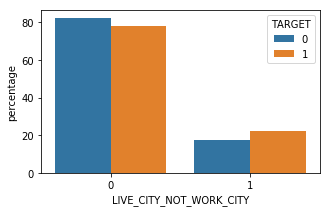

Group summary
    TARGET  LIVE_CITY_NOT_WORK_CITY  percentage
0       0                        0    82.41441
2       1                        0    77.83283
1       0                        1    17.58559
3       1                        1    22.16717

Statistical summary:
        LIVE_CITY_NOT_WORK_CITY_TARGET_0  LIVE_CITY_NOT_WORK_CITY_TARGET_1
count                     282686.000000                      24825.000000
mean                           0.175856                          0.221672
std                            0.380698                          0.415380
min                            0.000000                          0.000000
25%                            0.000000                          0.000000
50%                            0.000000                          0.000000
75%                            0.000000                          0.000000
max                            1.000000                          1.000000


In [572]:
var_int_cnt = var_int.drop(columns = ['CNT_CHILDREN', 'HOUR_APPR_PROCESS_START', 'DAYS_EMPLOYED', 
                                      'DAYS_BIRTH', 'SK_ID_CURR', 'DAYS_ID_PUBLISH'])
var_names = var_int_cnt.columns
var_n = var_names[14]
print('Integer variable name:', var_n)
# % missing value
print('% missing value', app_train[var_n].isnull().sum()/len(app_train[var_n])* 100)
# distribution of variable:
# This is how we have to present the bar plot: using the percentage, not count
var = (var_int_cnt.groupby([var_names[0]])[var_names[14]].value_counts(normalize=True).rename('percentage').
       mul(100).reset_index().sort_values(var_names[14]))
sns.barplot(x="LIVE_CITY_NOT_WORK_CITY", y='percentage', hue='TARGET', data=var)
plt.show()
# Statistical summary
target_0_des = app_train.loc[app_train['TARGET'] == 0, var_n].describe().rename('LIVE_CITY_NOT_WORK_CITY_TARGET_0')
target_1_des = app_train.loc[app_train['TARGET'] == 1, var_n].describe().rename('LIVE_CITY_NOT_WORK_CITY_TARGET_1')
#print('Target 1:', target_1_des)
print('Group summary\n', var)
print('\nStatistical summary:\n', pd.concat([target_0_des, target_1_des], axis=1))

Integer variable name: FLAG_DOCUMENT_2
% missing value 0.0


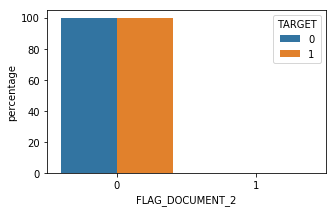

Group summary
    TARGET  FLAG_DOCUMENT_2  percentage
0       0                0   99.996816
2       1                0   99.983887
1       0                1    0.003184
3       1                1    0.016113

Statistical summary:
        FLAG_DOCUMENT_2_TARGET_0  FLAG_DOCUMENT_2_TARGET_1
count             282686.000000              24825.000000
mean                   0.000032                  0.000161
std                    0.005642                  0.012693
min                    0.000000                  0.000000
25%                    0.000000                  0.000000
50%                    0.000000                  0.000000
75%                    0.000000                  0.000000
max                    1.000000                  1.000000


In [573]:
var_int_cnt = var_int.drop(columns = ['CNT_CHILDREN', 'HOUR_APPR_PROCESS_START', 'DAYS_EMPLOYED', 
                                      'DAYS_BIRTH', 'SK_ID_CURR', 'DAYS_ID_PUBLISH'])
var_names = var_int_cnt.columns
var_n = var_names[15]
print('Integer variable name:', var_n)
# % missing value
print('% missing value', app_train[var_n].isnull().sum()/len(app_train[var_n])* 100)
# distribution of variable:
# This is how we have to present the bar plot: using the percentage, not count
var = (var_int_cnt.groupby([var_names[0]])[var_names[15]].value_counts(normalize=True).rename('percentage').
       mul(100).reset_index().sort_values(var_names[15]))
sns.barplot(x="FLAG_DOCUMENT_2", y='percentage', hue='TARGET', data=var)
plt.show()
# Statistical summary
target_0_des = app_train.loc[app_train['TARGET'] == 0, var_n].describe().rename('FLAG_DOCUMENT_2_TARGET_0')
target_1_des = app_train.loc[app_train['TARGET'] == 1, var_n].describe().rename('FLAG_DOCUMENT_2_TARGET_1')
#print('Target 1:', target_1_des)
print('Group summary\n', var)
print('\nStatistical summary:\n', pd.concat([target_0_des, target_1_des], axis=1))

All documents are flagegd as '0'.

Integer variable name: FLAG_DOCUMENT_3
% missing value 0.0


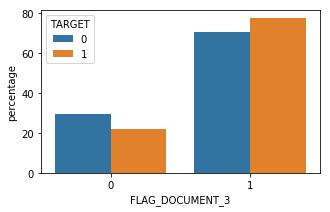

Group summary
    TARGET  FLAG_DOCUMENT_3  percentage
1       0                0   29.593966
3       1                0   22.207452
0       0                1   70.406034
2       1                1   77.792548

Statistical summary:
        FLAG_DOCUMENT_3_TARGET_0  FLAG_DOCUMENT_3_TARGET_1
count             282686.000000              24825.000000
mean                   0.704060                  0.777925
std                    0.456465                  0.415649
min                    0.000000                  0.000000
25%                    0.000000                  1.000000
50%                    1.000000                  1.000000
75%                    1.000000                  1.000000
max                    1.000000                  1.000000


In [574]:
var_int_cnt = var_int.drop(columns = ['CNT_CHILDREN', 'HOUR_APPR_PROCESS_START', 'DAYS_EMPLOYED', 
                                      'DAYS_BIRTH', 'SK_ID_CURR', 'DAYS_ID_PUBLISH'])
var_names = var_int_cnt.columns
var_n = var_names[16]
print('Integer variable name:', var_n)
# % missing value
print('% missing value', app_train[var_n].isnull().sum()/len(app_train[var_n])* 100)
# distribution of variable:
# This is how we have to present the bar plot: using the percentage, not count
var = (var_int_cnt.groupby([var_names[0]])[var_names[16]].value_counts(normalize=True).rename('percentage').
       mul(100).reset_index().sort_values(var_names[16]))
sns.barplot(x="FLAG_DOCUMENT_3", y='percentage', hue='TARGET', data=var)
plt.show()
# Statistical summary
target_0_des = app_train.loc[app_train['TARGET'] == 0, var_n].describe().rename('FLAG_DOCUMENT_3_TARGET_0')
target_1_des = app_train.loc[app_train['TARGET'] == 1, var_n].describe().rename('FLAG_DOCUMENT_3_TARGET_1')
#print('Target 1:', target_1_des)
print('Group summary\n', var)
print('\nStatistical summary:\n', pd.concat([target_0_des, target_1_des], axis=1))

Integer variable name: FLAG_DOCUMENT_4
% missing value 0.0


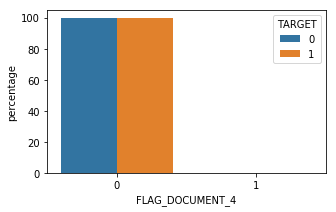

Group summary
    TARGET  FLAG_DOCUMENT_4  percentage
0       0                0   99.991156
2       1                0  100.000000
1       0                1    0.008844

Statistical summary:
        FLAG_DOCUMENT_4_TARGET_0  FLAG_DOCUMENT_4_TARGET_1
count             282686.000000                   24825.0
mean                   0.000088                       0.0
std                    0.009404                       0.0
min                    0.000000                       0.0
25%                    0.000000                       0.0
50%                    0.000000                       0.0
75%                    0.000000                       0.0
max                    1.000000                       0.0


In [575]:
var_int_cnt = var_int.drop(columns = ['CNT_CHILDREN', 'HOUR_APPR_PROCESS_START', 'DAYS_EMPLOYED', 
                                      'DAYS_BIRTH', 'SK_ID_CURR', 'DAYS_ID_PUBLISH'])
var_names = var_int_cnt.columns
var_n = var_names[17]
print('Integer variable name:', var_n)
# % missing value
print('% missing value', app_train[var_n].isnull().sum()/len(app_train[var_n])* 100)
# distribution of variable:
# This is how we have to present the bar plot: using the percentage, not count
var = (var_int_cnt.groupby([var_names[0]])[var_names[17]].value_counts(normalize=True).rename('percentage').
       mul(100).reset_index().sort_values(var_names[17]))
sns.barplot(x="FLAG_DOCUMENT_4", y='percentage', hue='TARGET', data=var)
plt.show()
# Statistical summary
target_0_des = app_train.loc[app_train['TARGET'] == 0, var_n].describe().rename('FLAG_DOCUMENT_4_TARGET_0')
target_1_des = app_train.loc[app_train['TARGET'] == 1, var_n].describe().rename('FLAG_DOCUMENT_4_TARGET_1')
#print('Target 1:', target_1_des)
print('Group summary\n', var)
print('\nStatistical summary:\n', pd.concat([target_0_des, target_1_des], axis=1))

All docs are flagged as 0, not useful variable,

Integer variable name: FLAG_DOCUMENT_5
% missing value 0.0


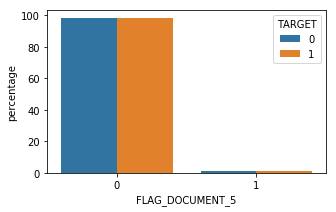

Group summary
    TARGET  FLAG_DOCUMENT_5  percentage
0       0                0   98.487368
2       1                0   98.501511
1       0                1    1.512632
3       1                1    1.498489

Statistical summary:
        FLAG_DOCUMENT_5_TARGET_0  FLAG_DOCUMENT_5_TARGET_1
count             282686.000000              24825.000000
mean                   0.015126                  0.014985
std                    0.122056                  0.121495
min                    0.000000                  0.000000
25%                    0.000000                  0.000000
50%                    0.000000                  0.000000
75%                    0.000000                  0.000000
max                    1.000000                  1.000000


In [576]:
var_int_cnt = var_int.drop(columns = ['CNT_CHILDREN', 'HOUR_APPR_PROCESS_START', 'DAYS_EMPLOYED', 
                                      'DAYS_BIRTH', 'SK_ID_CURR', 'DAYS_ID_PUBLISH'])
var_names = var_int_cnt.columns
var_n = var_names[18]
print('Integer variable name:', var_n)
# % missing value
print('% missing value', app_train[var_n].isnull().sum()/len(app_train[var_n])* 100)
# distribution of variable:
# This is how we have to present the bar plot: using the percentage, not count
var = (var_int_cnt.groupby([var_names[0]])[var_names[18]].value_counts(normalize=True).rename('percentage').
       mul(100).reset_index().sort_values(var_names[18]))
sns.barplot(x="FLAG_DOCUMENT_5", y='percentage', hue='TARGET', data=var)
plt.show()
# Statistical summary
target_0_des = app_train.loc[app_train['TARGET'] == 0, var_n].describe().rename('FLAG_DOCUMENT_5_TARGET_0')
target_1_des = app_train.loc[app_train['TARGET'] == 1, var_n].describe().rename('FLAG_DOCUMENT_5_TARGET_1')
#print('Target 1:', target_1_des)
print('Group summary\n', var)
print('\nStatistical summary:\n', pd.concat([target_0_des, target_1_des], axis=1))

Integer variable name: FLAG_DOCUMENT_6
% missing value 0.0


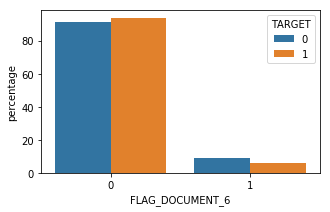

Group summary
    TARGET  FLAG_DOCUMENT_6  percentage
0       0                0   90.954274
2       1                0   93.929507
1       0                1    9.045726
3       1                1    6.070493

Statistical summary:
        FLAG_DOCUMENT_6_TARGET_0  FLAG_DOCUMENT_6_TARGET_1
count             282686.000000              24825.000000
mean                   0.090457                  0.060705
std                    0.286836                  0.238793
min                    0.000000                  0.000000
25%                    0.000000                  0.000000
50%                    0.000000                  0.000000
75%                    0.000000                  0.000000
max                    1.000000                  1.000000


In [577]:
var_int_cnt = var_int.drop(columns = ['CNT_CHILDREN', 'HOUR_APPR_PROCESS_START', 'DAYS_EMPLOYED', 
                                      'DAYS_BIRTH', 'SK_ID_CURR', 'DAYS_ID_PUBLISH'])
var_names = var_int_cnt.columns
var_n = var_names[19]
print('Integer variable name:', var_n)
# % missing value
print('% missing value', app_train[var_n].isnull().sum()/len(app_train[var_n])* 100)
# distribution of variable:
# This is how we have to present the bar plot: using the percentage, not count
var = (var_int_cnt.groupby([var_names[0]])[var_names[19]].value_counts(normalize=True).rename('percentage').
       mul(100).reset_index().sort_values(var_names[19]))
sns.barplot(x="FLAG_DOCUMENT_6", y='percentage', hue='TARGET', data=var)
plt.show()
# Statistical summary
target_0_des = app_train.loc[app_train['TARGET'] == 0, var_n].describe().rename('FLAG_DOCUMENT_6_TARGET_0')
target_1_des = app_train.loc[app_train['TARGET'] == 1, var_n].describe().rename('FLAG_DOCUMENT_6_TARGET_1')
#print('Target 1:', target_1_des)
print('Group summary\n', var)
print('\nStatistical summary:\n', pd.concat([target_0_des, target_1_des], axis=1))

Integer variable name: FLAG_DOCUMENT_7
% missing value 0.0


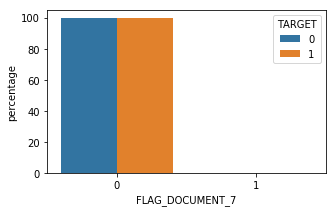

Group summary
    TARGET  FLAG_DOCUMENT_7  percentage
0       0                0   99.980190
2       1                0   99.987915
1       0                1    0.019810
3       1                1    0.012085

Statistical summary:
        FLAG_DOCUMENT_7_TARGET_0  FLAG_DOCUMENT_7_TARGET_1
count             282686.000000              24825.000000
mean                   0.000198                  0.000121
std                    0.014073                  0.010993
min                    0.000000                  0.000000
25%                    0.000000                  0.000000
50%                    0.000000                  0.000000
75%                    0.000000                  0.000000
max                    1.000000                  1.000000


In [578]:
var_int_cnt = var_int.drop(columns = ['CNT_CHILDREN', 'HOUR_APPR_PROCESS_START', 'DAYS_EMPLOYED', 
                                      'DAYS_BIRTH', 'SK_ID_CURR', 'DAYS_ID_PUBLISH'])
var_names = var_int_cnt.columns
var_n = var_names[20]
print('Integer variable name:', var_n)
# % missing value
print('% missing value', app_train[var_n].isnull().sum()/len(app_train[var_n])* 100)
# distribution of variable:
# This is how we have to present the bar plot: using the percentage, not count
var = (var_int_cnt.groupby([var_names[0]])[var_names[20]].value_counts(normalize=True).rename('percentage').
       mul(100).reset_index().sort_values(var_names[20]))
sns.barplot(x="FLAG_DOCUMENT_7", y='percentage', hue='TARGET', data=var)
plt.show()
# Statistical summary
target_0_des = app_train.loc[app_train['TARGET'] == 0, var_n].describe().rename('FLAG_DOCUMENT_7_TARGET_0')
target_1_des = app_train.loc[app_train['TARGET'] == 1, var_n].describe().rename('FLAG_DOCUMENT_7_TARGET_1')
#print('Target 1:', target_1_des)
print('Group summary\n', var)
print('\nStatistical summary:\n', pd.concat([target_0_des, target_1_des], axis=1))

Integer variable name: FLAG_DOCUMENT_8
% missing value 0.0


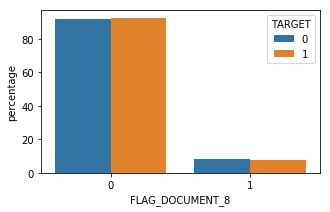

Group summary
    TARGET  FLAG_DOCUMENT_8  percentage
0       0                0   91.797259
2       1                0   92.604230
1       0                1    8.202741
3       1                1    7.395770

Statistical summary:
        FLAG_DOCUMENT_8_TARGET_0  FLAG_DOCUMENT_8_TARGET_1
count             282686.000000              24825.000000
mean                   0.082027                  0.073958
std                    0.274407                  0.261707
min                    0.000000                  0.000000
25%                    0.000000                  0.000000
50%                    0.000000                  0.000000
75%                    0.000000                  0.000000
max                    1.000000                  1.000000


In [579]:
var_int_cnt = var_int.drop(columns = ['CNT_CHILDREN', 'HOUR_APPR_PROCESS_START', 'DAYS_EMPLOYED', 
                                      'DAYS_BIRTH', 'SK_ID_CURR', 'DAYS_ID_PUBLISH'])
var_names = var_int_cnt.columns
var_n = var_names[21]
print('Integer variable name:', var_n)
# % missing value
print('% missing value', app_train[var_n].isnull().sum()/len(app_train[var_n])* 100)
# distribution of variable:
# This is how we have to present the bar plot: using the percentage, not count
var = (var_int_cnt.groupby([var_names[0]])[var_names[21]].value_counts(normalize=True).rename('percentage').
       mul(100).reset_index().sort_values(var_names[21]))
sns.barplot(x="FLAG_DOCUMENT_8", y='percentage', hue='TARGET', data=var)
plt.show()
# Statistical summary
target_0_des = app_train.loc[app_train['TARGET'] == 0, var_n].describe().rename('FLAG_DOCUMENT_8_TARGET_0')
target_1_des = app_train.loc[app_train['TARGET'] == 1, var_n].describe().rename('FLAG_DOCUMENT_8_TARGET_1')
#print('Target 1:', target_1_des)
print('Group summary\n', var)
print('\nStatistical summary:\n', pd.concat([target_0_des, target_1_des], axis=1))

Integer variable name: FLAG_DOCUMENT_9
% missing value 0.0


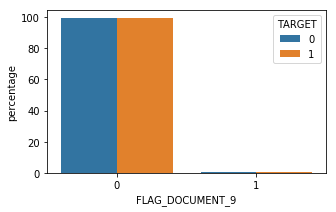

Group summary
    TARGET  FLAG_DOCUMENT_9  percentage
0       0                0   99.602386
2       1                0   99.701913
1       0                1    0.397614
3       1                1    0.298087

Statistical summary
        FLAG_DOCUMENT_9_TARGET_0  FLAG_DOCUMENT_9_TARGET_1
count             282686.000000              24825.000000
mean                   0.003976                  0.002981
std                    0.062931                  0.054517
min                    0.000000                  0.000000
25%                    0.000000                  0.000000
50%                    0.000000                  0.000000
75%                    0.000000                  0.000000
max                    1.000000                  1.000000


In [581]:
var_int_cnt = var_int.drop(columns = ['CNT_CHILDREN', 'HOUR_APPR_PROCESS_START', 'DAYS_EMPLOYED', 
                                      'DAYS_BIRTH', 'SK_ID_CURR', 'DAYS_ID_PUBLISH'])
var_names = var_int_cnt.columns
var_n = var_names[22]
print('Integer variable name:', var_n)
# % missing value
print('% missing value', app_train[var_n].isnull().sum()/len(app_train[var_n])* 100)
# distribution of variable:
# This is how we have to present the bar plot: using the percentage, not count
var = (var_int_cnt.groupby([var_names[0]])[var_names[22]].value_counts(normalize=True).rename('percentage').
       mul(100).reset_index().sort_values(var_names[22]))
sns.barplot(x="FLAG_DOCUMENT_9", y='percentage', hue='TARGET', data=var)
plt.show()
# Statistical summary
target_0_des = app_train.loc[app_train['TARGET'] == 0, var_n].describe().rename('FLAG_DOCUMENT_9_TARGET_0')
target_1_des = app_train.loc[app_train['TARGET'] == 1, var_n].describe().rename('FLAG_DOCUMENT_9_TARGET_1')
#print('Target 1:', target_1_des)
print('Group summary\n', var)
print('\nStatistical summary\n', pd.concat([target_0_des, target_1_des], axis=1))

Integer variable name: FLAG_DOCUMENT_10
% missing value 0.0


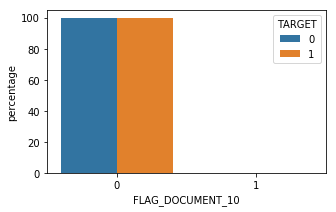

Group summary
    TARGET  FLAG_DOCUMENT_10  percentage
0       0                 0   99.997524
2       1                 0  100.000000
1       0                 1    0.002476

Statistical summary
        FLAG_DOCUMENT_10_TARGET_0  FLAG_DOCUMENT_10_TARGET_1
count              282686.000000                    24825.0
mean                    0.000025                        0.0
std                     0.004976                        0.0
min                     0.000000                        0.0
25%                     0.000000                        0.0
50%                     0.000000                        0.0
75%                     0.000000                        0.0
max                     1.000000                        0.0


In [580]:
var_int_cnt = var_int.drop(columns = ['CNT_CHILDREN', 'HOUR_APPR_PROCESS_START', 'DAYS_EMPLOYED', 
                                      'DAYS_BIRTH', 'SK_ID_CURR', 'DAYS_ID_PUBLISH'])
var_names = var_int_cnt.columns
var_n = var_names[23]
print('Integer variable name:', var_n)
# % missing value
print('% missing value', app_train[var_n].isnull().sum()/len(app_train[var_n])* 100)
# distribution of variable:
# This is how we have to present the bar plot: using the percentage, not count
var = (var_int_cnt.groupby([var_names[0]])[var_names[23]].value_counts(normalize=True).rename('percentage').
       mul(100).reset_index().sort_values(var_names[23]))
sns.barplot(x="FLAG_DOCUMENT_10", y='percentage', hue='TARGET', data=var)
plt.show()
# Statistical summary
target_0_des = app_train.loc[app_train['TARGET'] == 0, var_n].describe().rename('FLAG_DOCUMENT_10_TARGET_0')
target_1_des = app_train.loc[app_train['TARGET'] == 1, var_n].describe().rename('FLAG_DOCUMENT_10_TARGET_1')
#print('Target 1:', target_1_des)
print('Group summary\n', var)
print('\nStatistical summary\n', pd.concat([target_0_des, target_1_des], axis=1))

Integer variable name: FLAG_DOCUMENT_11
% missing value 0.0


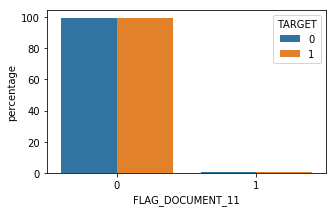

Group summary
    TARGET  FLAG_DOCUMENT_11  percentage
0       0                 0   99.600971
2       1                 0   99.697885
1       0                 1    0.399029
3       1                 1    0.302115

Statistical summary
        FLAG_DOCUMENT_11_TARGET_0  FLAG_DOCUMENT_11_TARGET_1
count              282686.000000               24825.000000
mean                    0.003990                   0.003021
std                     0.063043                   0.054883
min                     0.000000                   0.000000
25%                     0.000000                   0.000000
50%                     0.000000                   0.000000
75%                     0.000000                   0.000000
max                     1.000000                   1.000000


In [582]:
var_int_cnt = var_int.drop(columns = ['CNT_CHILDREN', 'HOUR_APPR_PROCESS_START', 'DAYS_EMPLOYED', 
                                      'DAYS_BIRTH', 'SK_ID_CURR', 'DAYS_ID_PUBLISH'])
var_names = var_int_cnt.columns
var_n = var_names[24]
print('Integer variable name:', var_n)
# % missing value
print('% missing value', app_train[var_n].isnull().sum()/len(app_train[var_n])* 100)
# distribution of variable:
# This is how we have to present the bar plot: using the percentage, not count
var = (var_int_cnt.groupby([var_names[0]])[var_names[24]].value_counts(normalize=True).rename('percentage').
       mul(100).reset_index().sort_values(var_names[24]))
sns.barplot(x="FLAG_DOCUMENT_11", y='percentage', hue='TARGET', data=var)
plt.show()
# Statistical summary
target_0_des = app_train.loc[app_train['TARGET'] == 0, var_n].describe().rename('FLAG_DOCUMENT_11_TARGET_0')
target_1_des = app_train.loc[app_train['TARGET'] == 1, var_n].describe().rename('FLAG_DOCUMENT_11_TARGET_1')
#print('Target 1:', target_1_des)
print('Group summary\n', var)
print('\nStatistical summary\n', pd.concat([target_0_des, target_1_des], axis=1))

Integer variable name: FLAG_DOCUMENT_12
% missing value 0.0


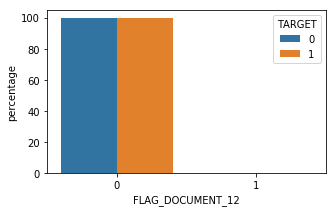

Group summary
    TARGET  FLAG_DOCUMENT_12  percentage
0       0                 0   99.999293
2       1                 0  100.000000
1       0                 1    0.000707

Statistical summary
        FLAG_DOCUMENT_12_TARGET_0  FLAG_DOCUMENT_12_TARGET_1
count              282686.000000                    24825.0
mean                    0.000007                        0.0
std                     0.002660                        0.0
min                     0.000000                        0.0
25%                     0.000000                        0.0
50%                     0.000000                        0.0
75%                     0.000000                        0.0
max                     1.000000                        0.0


In [583]:
var_int_cnt = var_int.drop(columns = ['CNT_CHILDREN', 'HOUR_APPR_PROCESS_START', 'DAYS_EMPLOYED', 
                                      'DAYS_BIRTH', 'SK_ID_CURR', 'DAYS_ID_PUBLISH'])
var_names = var_int_cnt.columns
var_n = var_names[25]
print('Integer variable name:', var_n)
# % missing value
print('% missing value', app_train[var_n].isnull().sum()/len(app_train[var_n])* 100)
# distribution of variable:
# This is how we have to present the bar plot: using the percentage, not count
var = (var_int_cnt.groupby([var_names[0]])[var_names[25]].value_counts(normalize=True).rename('percentage').
       mul(100).reset_index().sort_values(var_names[25]))
sns.barplot(x="FLAG_DOCUMENT_12", y='percentage', hue='TARGET', data=var)
plt.show()
# Statistical summary
target_0_des = app_train.loc[app_train['TARGET'] == 0, var_n].describe().rename('FLAG_DOCUMENT_12_TARGET_0')
target_1_des = app_train.loc[app_train['TARGET'] == 1, var_n].describe().rename('FLAG_DOCUMENT_12_TARGET_1')
#print('Target 1:', target_1_des)
print('Group summary\n', var)
print('\nStatistical summary\n', pd.concat([target_0_des, target_1_des], axis=1))

Integer variable name: FLAG_DOCUMENT_13
% missing value 0.0


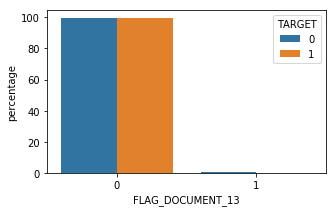

Group summary
    TARGET  FLAG_DOCUMENT_13  percentage
0       0                 0   99.627148
2       1                 0   99.879154
1       0                 1    0.372852
3       1                 1    0.120846

Statistical summary
        FLAG_DOCUMENT_13_TARGET_0  FLAG_DOCUMENT_13_TARGET_1
count              282686.000000               24825.000000
mean                    0.003729                   0.001208
std                     0.060948                   0.034743
min                     0.000000                   0.000000
25%                     0.000000                   0.000000
50%                     0.000000                   0.000000
75%                     0.000000                   0.000000
max                     1.000000                   1.000000


In [584]:
var_int_cnt = var_int.drop(columns = ['CNT_CHILDREN', 'HOUR_APPR_PROCESS_START', 'DAYS_EMPLOYED', 
                                      'DAYS_BIRTH', 'SK_ID_CURR', 'DAYS_ID_PUBLISH'])
var_names = var_int_cnt.columns
var_n = var_names[26]
print('Integer variable name:', var_n)
# % missing value
print('% missing value', app_train[var_n].isnull().sum()/len(app_train[var_n])* 100)
# distribution of variable:
# This is how we have to present the bar plot: using the percentage, not count
var = (var_int_cnt.groupby([var_names[0]])[var_names[26]].value_counts(normalize=True).rename('percentage').
       mul(100).reset_index().sort_values(var_names[26]))
sns.barplot(x="FLAG_DOCUMENT_13", y='percentage', hue='TARGET', data=var)
plt.show()
# Statistical summary
target_0_des = app_train.loc[app_train['TARGET'] == 0, var_n].describe().rename('FLAG_DOCUMENT_13_TARGET_0')
target_1_des = app_train.loc[app_train['TARGET'] == 1, var_n].describe().rename('FLAG_DOCUMENT_13_TARGET_1')
#print('Target 1:', target_1_des)
print('Group summary\n', var)
print('\nStatistical summary\n', pd.concat([target_0_des, target_1_des], axis=1))

Integer variable name: FLAG_DOCUMENT_14
% missing value 0.0


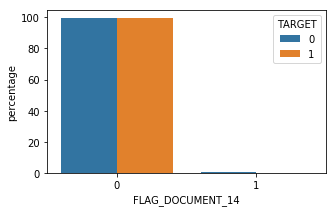

Group summary
    TARGET  FLAG_DOCUMENT_14  percentage
0       0                 0   99.691177
2       1                 0   99.879154
1       0                 1    0.308823
3       1                 1    0.120846

Statistical summary
        FLAG_DOCUMENT_14_TARGET_0  FLAG_DOCUMENT_14_TARGET_1
count              282686.000000               24825.000000
mean                    0.003088                   0.001208
std                     0.055486                   0.034743
min                     0.000000                   0.000000
25%                     0.000000                   0.000000
50%                     0.000000                   0.000000
75%                     0.000000                   0.000000
max                     1.000000                   1.000000


In [585]:
var_int_cnt = var_int.drop(columns = ['CNT_CHILDREN', 'HOUR_APPR_PROCESS_START', 'DAYS_EMPLOYED', 
                                      'DAYS_BIRTH', 'SK_ID_CURR', 'DAYS_ID_PUBLISH'])
var_names = var_int_cnt.columns
var_n = var_names[27]
print('Integer variable name:', var_n)
# % missing value
print('% missing value', app_train[var_n].isnull().sum()/len(app_train[var_n])* 100)
# distribution of variable:
# This is how we have to present the bar plot: using the percentage, not count
var = (var_int_cnt.groupby([var_names[0]])[var_names[27]].value_counts(normalize=True).rename('percentage').
       mul(100).reset_index().sort_values(var_names[27]))
sns.barplot(x="FLAG_DOCUMENT_14", y='percentage', hue='TARGET', data=var)
plt.show()
# Statistical summary
target_0_des = app_train.loc[app_train['TARGET'] == 0, var_n].describe().rename('FLAG_DOCUMENT_14_TARGET_0')
target_1_des = app_train.loc[app_train['TARGET'] == 1, var_n].describe().rename('FLAG_DOCUMENT_14_TARGET_1')
#print('Target 1:', target_1_des)
print('Group summary\n', var)
print('\nStatistical summary\n', pd.concat([target_0_des, target_1_des], axis=1))

Integer variable name: FLAG_DOCUMENT_15
% missing value 0.0


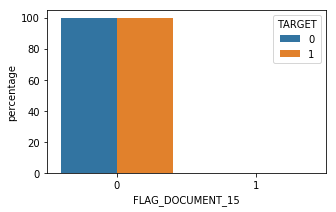

Group summary
    TARGET  FLAG_DOCUMENT_15  percentage
0       0                 0   99.872296
2       1                 0   99.955690
1       0                 1    0.127704
3       1                 1    0.044310

Statistical summary
        FLAG_DOCUMENT_15_TARGET_0  FLAG_DOCUMENT_15_TARGET_1
count              282686.000000               24825.000000
mean                    0.001277                   0.000443
std                     0.035713                   0.021046
min                     0.000000                   0.000000
25%                     0.000000                   0.000000
50%                     0.000000                   0.000000
75%                     0.000000                   0.000000
max                     1.000000                   1.000000


In [586]:
var_int_cnt = var_int.drop(columns = ['CNT_CHILDREN', 'HOUR_APPR_PROCESS_START', 'DAYS_EMPLOYED', 
                                      'DAYS_BIRTH', 'SK_ID_CURR', 'DAYS_ID_PUBLISH'])
var_names = var_int_cnt.columns
var_n = var_names[28]
print('Integer variable name:', var_n)
# % missing value
print('% missing value', app_train[var_n].isnull().sum()/len(app_train[var_n])* 100)
# distribution of variable:
# This is how we have to present the bar plot: using the percentage, not count
var = (var_int_cnt.groupby([var_names[0]])[var_names[28]].value_counts(normalize=True).rename('percentage').
       mul(100).reset_index().sort_values(var_names[28]))
sns.barplot(x="FLAG_DOCUMENT_15", y='percentage', hue='TARGET', data=var)
plt.show()
# Statistical summary
target_0_des = app_train.loc[app_train['TARGET'] == 0, var_n].describe().rename('FLAG_DOCUMENT_15_TARGET_0')
target_1_des = app_train.loc[app_train['TARGET'] == 1, var_n].describe().rename('FLAG_DOCUMENT_15_TARGET_1')
#print('Target 1:', target_1_des)
print('Group summary\n', var)
print('\nStatistical summary\n', pd.concat([target_0_des, target_1_des], axis=1))

Integer variable name: FLAG_DOCUMENT_16
% missing value 0.0


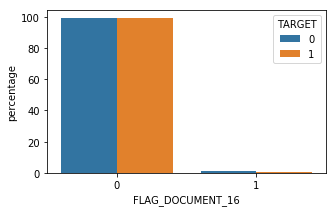

Group summary
    TARGET  FLAG_DOCUMENT_16  percentage
0       0                 0   98.973066
2       1                 0   99.395770
1       0                 1    1.026934
3       1                 1    0.604230

Statistical summary
        FLAG_DOCUMENT_16_TARGET_0  FLAG_DOCUMENT_16_TARGET_1
count              282686.000000               24825.000000
mean                    0.010269                   0.006042
std                     0.100816                   0.077499
min                     0.000000                   0.000000
25%                     0.000000                   0.000000
50%                     0.000000                   0.000000
75%                     0.000000                   0.000000
max                     1.000000                   1.000000


In [587]:
var_int_cnt = var_int.drop(columns = ['CNT_CHILDREN', 'HOUR_APPR_PROCESS_START', 'DAYS_EMPLOYED', 
                                      'DAYS_BIRTH', 'SK_ID_CURR', 'DAYS_ID_PUBLISH'])
var_names = var_int_cnt.columns
var_n = var_names[29]
print('Integer variable name:', var_n)
# % missing value
print('% missing value', app_train[var_n].isnull().sum()/len(app_train[var_n])* 100)
# distribution of variable:
# This is how we have to present the bar plot: using the percentage, not count
var = (var_int_cnt.groupby([var_names[0]])[var_names[29]].value_counts(normalize=True).rename('percentage').
       mul(100).reset_index().sort_values(var_names[29]))
sns.barplot(x="FLAG_DOCUMENT_16", y='percentage', hue='TARGET', data=var)
plt.show()
# Statistical summary
target_0_des = app_train.loc[app_train['TARGET'] == 0, var_n].describe().rename('FLAG_DOCUMENT_16_TARGET_0')
target_1_des = app_train.loc[app_train['TARGET'] == 1, var_n].describe().rename('FLAG_DOCUMENT_16_TARGET_1')
#print('Target 1:', target_1_des)
print('Group summary\n', var)
print('\nStatistical summary\n', pd.concat([target_0_des, target_1_des], axis=1))

Integer variable name: FLAG_DOCUMENT_17
% missing value 0.0


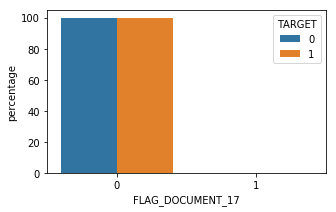

Group summary
    TARGET  FLAG_DOCUMENT_17  percentage
0       0                 0   99.971700
2       1                 0   99.991944
1       0                 1    0.028300
3       1                 1    0.008056

Statistical summary
        FLAG_DOCUMENT_17_TARGET_0  FLAG_DOCUMENT_17_TARGET_1
count              282686.000000               24825.000000
mean                    0.000283                   0.000081
std                     0.016820                   0.008976
min                     0.000000                   0.000000
25%                     0.000000                   0.000000
50%                     0.000000                   0.000000
75%                     0.000000                   0.000000
max                     1.000000                   1.000000


In [588]:
var_int_cnt = var_int.drop(columns = ['CNT_CHILDREN', 'HOUR_APPR_PROCESS_START', 'DAYS_EMPLOYED', 
                                      'DAYS_BIRTH', 'SK_ID_CURR', 'DAYS_ID_PUBLISH'])
var_names = var_int_cnt.columns
var_n = var_names[30]
print('Integer variable name:', var_n)
# % missing value
print('% missing value', app_train[var_n].isnull().sum()/len(app_train[var_n])* 100)
# distribution of variable:
# This is how we have to present the bar plot: using the percentage, not count
var = (var_int_cnt.groupby([var_names[0]])[var_names[30]].value_counts(normalize=True).rename('percentage').
       mul(100).reset_index().sort_values(var_names[30]))
sns.barplot(x="FLAG_DOCUMENT_17", y='percentage', hue='TARGET', data=var)
plt.show()
# Statistical summary
target_0_des = app_train.loc[app_train['TARGET'] == 0, var_n].describe().rename('FLAG_DOCUMENT_17_TARGET_0')
target_1_des = app_train.loc[app_train['TARGET'] == 1, var_n].describe().rename('FLAG_DOCUMENT_17_TARGET_1')
#print('Target 1:', target_1_des)
print('Group summary\n', var)
print('\nStatistical summary\n', pd.concat([target_0_des, target_1_des], axis=1))

Integer variable name: FLAG_DOCUMENT_18
% missing value 0.0


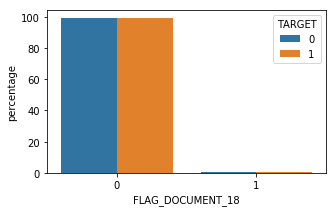

Group summary
    TARGET  FLAG_DOCUMENT_18  percentage
0       0                 0   99.165859
2       1                 0   99.427996
1       0                 1    0.834141
3       1                 1    0.572004

Statistical summary
        FLAG_DOCUMENT_18_TARGET_0  FLAG_DOCUMENT_18_TARGET_1
count              282686.000000               24825.000000
mean                    0.008341                   0.005720
std                     0.090950                   0.075416
min                     0.000000                   0.000000
25%                     0.000000                   0.000000
50%                     0.000000                   0.000000
75%                     0.000000                   0.000000
max                     1.000000                   1.000000


In [589]:
var_names = var_int_cnt.columns
var_n = var_names[31]
print('Integer variable name:', var_n)
# % missing value
print('% missing value', app_train[var_n].isnull().sum()/len(app_train[var_n])* 100)
# distribution of variable:
# This is how we have to present the bar plot: using the percentage, not count
var = (var_int_cnt.groupby([var_names[0]])[var_names[31]].value_counts(normalize=True).rename('percentage').
       mul(100).reset_index().sort_values(var_names[31]))
sns.barplot(x="FLAG_DOCUMENT_18", y='percentage', hue='TARGET', data=var)
plt.show()
# Statistical summary
target_0_des = app_train.loc[app_train['TARGET'] == 0, var_n].describe().rename('FLAG_DOCUMENT_18_TARGET_0')
target_1_des = app_train.loc[app_train['TARGET'] == 1, var_n].describe().rename('FLAG_DOCUMENT_18_TARGET_1')
#print('Target 1:', target_1_des)
print('Group summary\n', var)
print('\nStatistical summary\n', pd.concat([target_0_des, target_1_des], axis=1))

Integer variable name: FLAG_DOCUMENT_19
% missing value 0.0


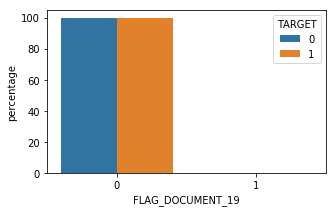

Group summary
    TARGET  FLAG_DOCUMENT_19  percentage
0       0                 0   99.939509
2       1                 0   99.951662
1       0                 1    0.060491
3       1                 1    0.048338

Statistical summary
        FLAG_DOCUMENT_19_TARGET_0  FLAG_DOCUMENT_19_TARGET_1
count              282686.000000               24825.000000
mean                    0.000605                   0.000483
std                     0.024588                   0.021981
min                     0.000000                   0.000000
25%                     0.000000                   0.000000
50%                     0.000000                   0.000000
75%                     0.000000                   0.000000
max                     1.000000                   1.000000


In [590]:
var_names = var_int_cnt.columns
var_n = var_names[32]
print('Integer variable name:', var_n)
# % missing value
print('% missing value', app_train[var_n].isnull().sum()/len(app_train[var_n])* 100)
# distribution of variable:
# This is how we have to present the bar plot: using the percentage, not count
var = (var_int_cnt.groupby([var_names[0]])[var_names[32]].value_counts(normalize=True).rename('percentage').
       mul(100).reset_index().sort_values(var_names[32]))
sns.barplot(x="FLAG_DOCUMENT_19", y='percentage', hue='TARGET', data=var)
plt.show()
# Statistical summary
target_0_des = app_train.loc[app_train['TARGET'] == 0, var_n].describe().rename('FLAG_DOCUMENT_19_TARGET_0')
target_1_des = app_train.loc[app_train['TARGET'] == 1, var_n].describe().rename('FLAG_DOCUMENT_19_TARGET_1')
#print('Target 1:', target_1_des)
print('Group summary\n', var)
print('\nStatistical summary\n', pd.concat([target_0_des, target_1_des], axis=1))

Integer variable name: FLAG_DOCUMENT_20
% missing value 0.0


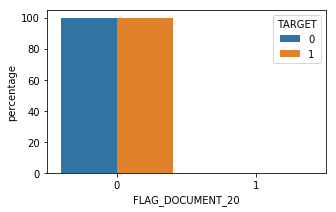

Group summary
    TARGET  FLAG_DOCUMENT_20  percentage
0       0                 0   99.949414
2       1                 0   99.947633
1       0                 1    0.050586
3       1                 1    0.052367

Statistical summary
        FLAG_DOCUMENT_20_TARGET_0  FLAG_DOCUMENT_20_TARGET_1
count              282686.000000               24825.000000
mean                    0.000506                   0.000524
std                     0.022486                   0.022878
min                     0.000000                   0.000000
25%                     0.000000                   0.000000
50%                     0.000000                   0.000000
75%                     0.000000                   0.000000
max                     1.000000                   1.000000


In [560]:
var_names = var_int_cnt.columns
var_n = var_names[33]
print('Integer variable name:', var_n)
# % missing value
print('% missing value', app_train[var_n].isnull().sum()/len(app_train[var_n])* 100)
# distribution of variable:
# This is how we have to present the bar plot: using the percentage, not count
var = (var_int_cnt.groupby([var_names[0]])[var_names[33]].value_counts(normalize=True).rename('percentage').
       mul(100).reset_index().sort_values(var_names[33]))
sns.barplot(x="FLAG_DOCUMENT_20", y='percentage', hue='TARGET', data=var)
plt.show()
# Statistical summary
target_0_des = app_train.loc[app_train['TARGET'] == 0, var_n].describe().rename('FLAG_DOCUMENT_20_TARGET_0')
target_1_des = app_train.loc[app_train['TARGET'] == 1, var_n].describe().rename('FLAG_DOCUMENT_20_TARGET_1')
#print('Target 1:', target_1_des)
print('Group summary\n', var)
print('\nStatistical summary\n', pd.concat([target_0_des, target_1_des], axis=1))

Integer variable name: FLAG_DOCUMENT_21
% missing value 0.0


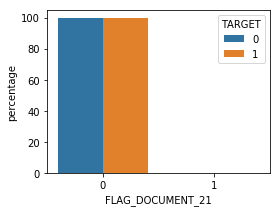

Group summary
    TARGET  FLAG_DOCUMENT_21  percentage
0       0                 0   99.968516
2       1                 0   99.943605
1       0                 1    0.031484
3       1                 1    0.056395

Statistical summary
        FLAG_DOCUMENT_21_TARGET_0  FLAG_DOCUMENT_21_TARGET_1
count              282686.000000               24825.000000
mean                    0.000315                   0.000564
std                     0.017741                   0.023741
min                     0.000000                   0.000000
25%                     0.000000                   0.000000
50%                     0.000000                   0.000000
75%                     0.000000                   0.000000
max                     1.000000                   1.000000


In [374]:
var_names = var_int_cnt.columns
var_n = var_names[34]
print('Integer variable name:', var_n)
# % missing value
print('% missing value', app_train[var_n].isnull().sum()/len(app_train[var_n])* 100)
# distribution of variable:
# This is how we have to present the bar plot: using the percentage, not count
var = (var_int_cnt.groupby([var_names[0]])[var_names[34]].value_counts(normalize=True).rename('percentage').
       mul(100).reset_index().sort_values(var_names[34]))
sns.barplot(x="FLAG_DOCUMENT_21", y='percentage', hue='TARGET', data=var)
plt.show()
# Statistical summary
target_0_des = app_train.loc[app_train['TARGET'] == 0, var_n].describe().rename('FLAG_DOCUMENT_21_TARGET_0')
target_1_des = app_train.loc[app_train['TARGET'] == 1, var_n].describe().rename('FLAG_DOCUMENT_21_TARGET_1')
#print('Target 1:', target_1_des)
print('Group summary\n', var)
print('\nStatistical summary\n', pd.concat([target_0_des, target_1_des], axis=1))

Integer variable name: DAYS_BIRTH
% missing value 0.0


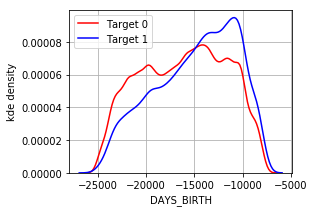


Statistical summary
        DAYS_BIRTH_TARGET_0  DAYS_BIRTH_TARGET_1
count        282686.000000         24825.000000
mean         -16138.176397        -14884.828077
std            4364.200856          4192.844583
min          -25229.000000        -25168.000000
25%          -19793.750000        -18037.000000
50%          -15877.000000        -14282.000000
75%          -12536.000000        -11396.000000
max           -7489.000000         -7678.000000


In [379]:
var_int_dist = pd.concat([app_train.DAYS_BIRTH, app_train.DAYS_EMPLOYED, app_train.DAYS_ID_PUBLISH, 
                          app_train.DAYS_LAST_PHONE_CHANGE, app_train.CNT_CHILDREN, app_train.HOUR_APPR_PROCESS_START], axis=1)

var_names = var_int_dist.columns
var = var_names[0]
print('Integer variable name:', var)
# % missing value
print('% missing value', app_train[var].isnull().sum()/len(app_train[var])* 100)

#sns.kdeplot(app_train[var], label = 'all', color='black')
sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, var], label = 'Target 0', color='red')
sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, var], label = 'Target 1', color='blue')
plt.xlabel(var)
plt.ylabel('kde density')
plt.grid(True)
plt.rcParams['figure.figsize'] = 4,3
plt.show()

# Statistical summary
target_0_des = app_train.loc[app_train['TARGET'] == 0, var].describe().rename('DAYS_BIRTH_TARGET_0')
target_1_des = app_train.loc[app_train['TARGET'] == 1, var].describe().rename('DAYS_BIRTH_TARGET_1')
#print('Target 1:', target_1_des)
print('\nStatistical summary\n', pd.concat([target_0_des, target_1_des], axis=1))

Integer variable name: DAYS_EMPLOYED
% missing value 0.0


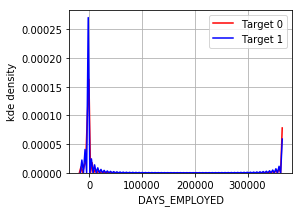


Statistical summary
        DAYS_EMPLOYED_TARGET_0  DAYS_EMPLOYED_TARGET_1
count           282686.000000            24825.000000
mean             65696.146123            42394.675448
std             142877.810161           119484.634253
min             -17912.000000           -16069.000000
25%              -2813.000000            -2156.000000
50%              -1235.000000            -1034.000000
75%               -278.000000             -379.000000
max             365243.000000           365243.000000
% anomaly in train.DAYS_EMPLOYED: 18.01
% anomaly in test.DAYS_EMPLOYED: 19.03


In [626]:
var_int_dist = pd.concat([app_train.DAYS_BIRTH, app_train.DAYS_EMPLOYED, app_train.DAYS_ID_PUBLISH, 
                          app_train.DAYS_LAST_PHONE_CHANGE, app_train.CNT_CHILDREN, app_train.HOUR_APPR_PROCESS_START], axis=1)

var_names = var_int_dist.columns
var = var_names[1]
print('Integer variable name:', var)
# % missing value
print('% missing value', app_train[var].isnull().sum()/len(app_train[var])* 100)

#sns.kdeplot(app_train[var], label = 'all', color='black')
sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, var], label = 'Target 0', color='red')
sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, var], label = 'Target 1', color='blue')
plt.xlabel(var)
plt.ylabel('kde density')
#plt.xscale('log')
plt.grid(True)
plt.rcParams['figure.figsize'] = 4,3
plt.show()

# Statistical summary
target_0_des = app_train.loc[app_train['TARGET'] == 0, var].describe().rename('DAYS_EMPLOYED_TARGET_0')
target_1_des = app_train.loc[app_train['TARGET'] == 1, var].describe().rename('DAYS_EMPLOYED_TARGET_1')
#print('Target 1:', target_1_des)
print('\nStatistical summary\n', pd.concat([target_0_des, target_1_des], axis=1))
# Anomalies in data
print('% anomaly in train.DAYS_EMPLOYED: {:05.2f}'.format(len(app_train[app_train['DAYS_EMPLOYED']> 0]['DAYS_EMPLOYED'])
                                   /len(app_train['DAYS_EMPLOYED'])*100))
print('% anomaly in test.DAYS_EMPLOYED: {:05.2f}'.format(len(app_test[app_test['DAYS_EMPLOYED']> 0]['DAYS_EMPLOYED'])
                                   /len(app_test['DAYS_EMPLOYED'])*100))


There are 18% anomalies in DAYS_EMPLOYED train dataset. It seemed to defaultvalue for employment days set as 365243.000000. We can just look into the histogram instead to see the distribution.

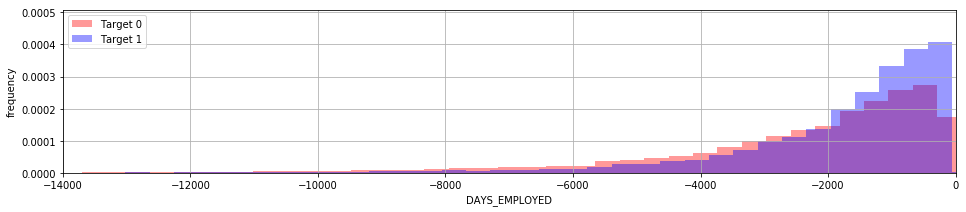

In [624]:
sns.distplot(app_train.loc[app_train['TARGET'] == 0, var], label = 'Target 0', color='red', kde=False, bins=1000, norm_hist=True)
sns.distplot(app_train.loc[app_train['TARGET'] == 1, var], label = 'Target 1', color='blue', kde=False, bins=1000, norm_hist=True)
plt.xlabel(var)
plt.legend()
plt.ylabel('frequency')
#plt.xscale('log')
plt.xlim(-14000, 0) # The max value should be 0 as the count is backward from the day of application
plt.grid(True)
plt.rcParams['figure.figsize'] = 16,3
plt.show()


Integer variable name: DAYS_ID_PUBLISH
% missing value 0.0


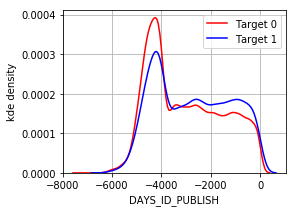


Statistical summary
        DAYS_ID_PUBLISH_TARGET_0  DAYS_ID_PUBLISH_TARGET_1
count             282686.000000              24825.000000
mean               -3017.219788              -2732.099617
std                 1506.614090               1516.975313
min                -7197.000000              -6207.000000
25%                -4313.000000              -4119.000000
50%                -3295.000000              -2797.000000
75%                -1755.000000              -1392.000000
max                    0.000000                  0.000000


In [385]:
var_int_dist = pd.concat([app_train.DAYS_BIRTH, app_train.DAYS_EMPLOYED, app_train.DAYS_ID_PUBLISH, 
                          app_train.DAYS_LAST_PHONE_CHANGE, app_train.CNT_CHILDREN, app_train.HOUR_APPR_PROCESS_START], axis=1)

var_names = var_int_dist.columns
var = var_names[2]
print('Integer variable name:', var)
# % missing value
print('% missing value', app_train[var].isnull().sum()/len(app_train[var])* 100)

#sns.kdeplot(app_train[var], label = 'all', color='black')
sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, var], label = 'Target 0', color='red')
sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, var], label = 'Target 1', color='blue')
plt.xlabel(var)
plt.ylabel('kde density')
plt.grid(True)
plt.rcParams['figure.figsize'] = 4,3
plt.show()

# Statistical summary
target_0_des = app_train.loc[app_train['TARGET'] == 0, var].describe().rename('DAYS_ID_PUBLISH_TARGET_0')
target_1_des = app_train.loc[app_train['TARGET'] == 1, var].describe().rename('DAYS_ID_PUBLISH_TARGET_1')
#print('Target 1:', target_1_des)
print('\nStatistical summary\n', pd.concat([target_0_des, target_1_des], axis=1))

Integer variable name: DAYS_LAST_PHONE_CHANGE
% missing value 0.00032519161916159093


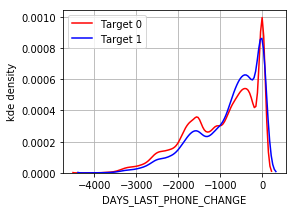


Statistical summary
        DAYS_LAST_PHONE_CHANGE_TARGET_0  DAYS_LAST_PHONE_CHANGE_TARGET_1
count                    282685.000000                     24825.000000
mean                       -976.388294                      -808.796818
std                         831.210739                       758.090713
min                       -4292.000000                     -4070.000000
25%                       -1586.000000                     -1301.000000
50%                        -776.000000                      -594.000000
75%                        -281.000000                      -194.000000
max                           0.000000                         0.000000


In [387]:
var_int_dist = pd.concat([app_train.DAYS_BIRTH, app_train.DAYS_EMPLOYED, app_train.DAYS_ID_PUBLISH, 
                          app_train.DAYS_LAST_PHONE_CHANGE, app_train.CNT_CHILDREN, app_train.HOUR_APPR_PROCESS_START], axis=1)

var_names = var_int_dist.columns
var = var_names[3]
print('Integer variable name:', var)
# % missing value
print('% missing value', app_train[var].isnull().sum()/len(app_train[var])* 100)

#sns.kdeplot(app_train[var], label = 'all', color='black')
sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, var], label = 'Target 0', color='red')
sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, var], label = 'Target 1', color='blue')
plt.xlabel(var)
plt.ylabel('kde density')
plt.grid(True)
plt.rcParams['figure.figsize'] = 4,3
plt.show()

# Statistical summary
target_0_des = app_train.loc[app_train['TARGET'] == 0, var].describe().rename('DAYS_LAST_PHONE_CHANGE_TARGET_0')
target_1_des = app_train.loc[app_train['TARGET'] == 1, var].describe().rename('DAYS_LAST_PHONE_CHANGE_TARGET_1')
#print('Target 1:', target_1_des)
print('\nStatistical summary\n', pd.concat([target_0_des, target_1_des], axis=1))

Integer variable name: CNT_CHILDREN
% missing value 0.0


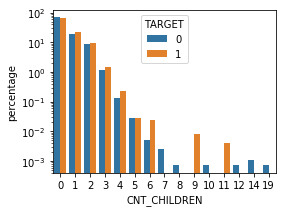

Group summary
     TARGET  CNT_CHILDREN  percentage
0        0             0   70.311936
13       1             0   66.904330
1        0             1   19.691460
14       1             1   21.969789
2        0             2    8.637145
15       1             2    9.397784
16       1             3    1.442095
3        0             3    1.188244
17       1             4    0.221551
4        0             4    0.132302
5        0             5    0.027239
18       1             5    0.028197
6        0             6    0.005306
19       1             6    0.024169
7        0             7    0.002476
9        0             8    0.000707
20       1             9    0.008056
10       0            10    0.000707
21       1            11    0.004028
11       0            12    0.000707
8        0            14    0.001061
12       0            19    0.000707

Statistical summary
        CNT_CHILDREN_TARGET_0  CNT_CHILDREN_TARGET_1
count          282686.000000           24825.000000
mean    

In [397]:
var_int_dist = pd.concat([app_train.TARGET, app_train.DAYS_BIRTH, app_train.DAYS_EMPLOYED, app_train.DAYS_ID_PUBLISH, 
                          app_train.DAYS_LAST_PHONE_CHANGE, app_train.CNT_CHILDREN, app_train.HOUR_APPR_PROCESS_START], axis=1)

var_names = var_int_dist.columns
var_n = var_names[5]
print('Integer variable name:', var_n)
# % missing value
print('% missing value', app_train[var_n].isnull().sum()/len(app_train[var_n])* 100)
# distribution of variable:
# This is how we have to present the bar plot: using the percentage, not count
var = (var_int_dist.groupby([var_names[0]])[var_names[5]].value_counts(normalize=True).rename('percentage').
       mul(100).reset_index().sort_values(var_names[5]))
sns.barplot(x="CNT_CHILDREN", y='percentage', hue='TARGET', data=var)
plt.yscale('log')
plt.show()
# Statistical summary
target_0_des = app_train.loc[app_train['TARGET'] == 0, var_n].describe().rename('CNT_CHILDREN_TARGET_0')
target_1_des = app_train.loc[app_train['TARGET'] == 1, var_n].describe().rename('CNT_CHILDREN_TARGET_1')
#print('Target 1:', target_1_des)
print('Group summary\n', var)
print('\nStatistical summary\n', pd.concat([target_0_des, target_1_des], axis=1))

Integer variable name: HOUR_APPR_PROCESS_START
% missing value 0.0


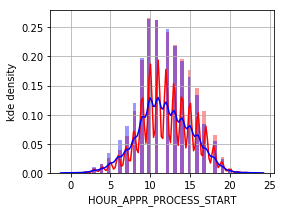


Statistical summary
        HOUR_APPR_PROCESS_START_TARGET_0  HOUR_APPR_PROCESS_START_TARGET_1
count                     282686.000000                      24825.000000
mean                          12.086807                         11.797100
std                            3.263173                          3.284299
min                            0.000000                          0.000000
25%                           10.000000                         10.000000
50%                           12.000000                         12.000000
75%                           14.000000                         14.000000
max                           23.000000                         23.000000


In [400]:
var_int_dist = pd.concat([app_train.DAYS_BIRTH, app_train.DAYS_EMPLOYED, app_train.DAYS_ID_PUBLISH, 
                          app_train.DAYS_LAST_PHONE_CHANGE, app_train.CNT_CHILDREN, app_train.HOUR_APPR_PROCESS_START], axis=1)

var_names = var_int_dist.columns
var = var_names[5]
print('Integer variable name:', var)
# % missing value
print('% missing value', app_train[var].isnull().sum()/len(app_train[var])* 100)

#sns.kdeplot(app_train[var], label = 'all', color='black')
sns.distplot(app_train.loc[app_train['TARGET'] == 0, var], label = 'Target 0', color='red')
sns.distplot(app_train.loc[app_train['TARGET'] == 1, var], label = 'Target 1', color='blue')
plt.xlabel(var)
plt.ylabel('kde density')
plt.grid(True)
plt.rcParams['figure.figsize'] = 4,3
plt.show()

# Statistical summary
target_0_des = app_train.loc[app_train['TARGET'] == 0, var].describe().rename('HOUR_APPR_PROCESS_START_TARGET_0')
target_1_des = app_train.loc[app_train['TARGET'] == 1, var].describe().rename('HOUR_APPR_PROCESS_START_TARGET_1')
#print('Target 1:', target_1_des)
print('\nStatistical summary\n', pd.concat([target_0_des, target_1_des], axis=1))

## variable type: categorical

Categorical variable name: NAME_CONTRACT_TYPE
% missing value 0.0


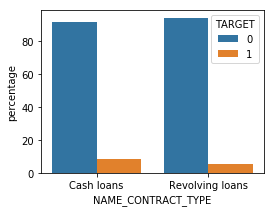

Group summary
   NAME_CONTRACT_TYPE  TARGET  percentage
0         Cash loans       0   91.654087
1         Cash loans       1    8.345913
2    Revolving loans       0   94.521671
3    Revolving loans       1    5.478329


In [427]:
var_obj = obj.columns
var_n = var_obj[0]
print('Categorical variable name:', var_n)
# % missing value
print('% missing value', app_train[var_n].isnull().sum()/len(app_train[var_n])* 100)
# distribution/frequency
df = pd.concat([app_train[var_n], app_train.TARGET], axis=1)
var= df.groupby([var_n])['TARGET'].value_counts(normalize=True).rename('percentage').mul(100).reset_index().sort_values([var_n])
sns.barplot(x=var_n, y='percentage', hue='TARGET', data=var)
plt.show()

print('Group summary\n', var)

Categorical variable name: CODE_GENDER
% missing value 0.0


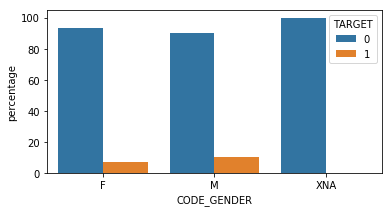

Group summary
   CODE_GENDER  TARGET  percentage
0           F       0   93.000672
1           F       1    6.999328
2           M       0   89.858080
3           M       1   10.141920
4         XNA       0  100.000000


In [430]:
var_obj = obj.columns
var_n = var_obj[1]
print('Categorical variable name:', var_n)
# % missing value
print('% missing value', app_train[var_n].isnull().sum()/len(app_train[var_n])* 100)
# distribution/frequency
df = pd.concat([app_train[var_n], app_train.TARGET], axis=1)
var= df.groupby([var_n])['TARGET'].value_counts(normalize=True).rename('percentage').mul(100).reset_index().sort_values([var_n])
sns.barplot(x=var_n, y='percentage', hue='TARGET', data=var)
plt.rcParams['figure.figsize'] = 6,3
plt.show()
print('Group summary\n', var)

Categorical variable name: FLAG_OWN_CAR
% missing value 0.0


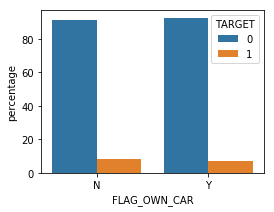

Group summary
   FLAG_OWN_CAR  TARGET  percentage
0            N       0   91.499773
1            N       1    8.500227
2            Y       0   92.756270
3            Y       1    7.243730


In [433]:
var_obj = obj.columns
var_n = var_obj[2]
print('Categorical variable name:', var_n)
# % missing value
print('% missing value', app_train[var_n].isnull().sum()/len(app_train[var_n])* 100)
# distribution/frequency
df = pd.concat([app_train[var_n], app_train.TARGET], axis=1)
var= df.groupby([var_n])['TARGET'].value_counts(normalize=True).rename('percentage').mul(100).reset_index().sort_values([var_n])
sns.barplot(x=var_n, y='percentage', hue='TARGET', data=var)
plt.rcParams['figure.figsize'] = 4,3
plt.show()
print('Group summary\n', var)

Categorical variable name: FLAG_OWN_REALTY
% missing value 0.0


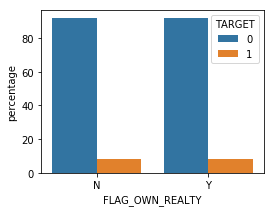

Group summary
   FLAG_OWN_REALTY  TARGET  percentage
0               N       0   91.675071
1               N       1    8.324929
2               Y       0   92.038423
3               Y       1    7.961577


In [434]:
var_obj = obj.columns
var_n = var_obj[3]
print('Categorical variable name:', var_n)
# % missing value
print('% missing value', app_train[var_n].isnull().sum()/len(app_train[var_n])* 100)
# distribution/frequency
df = pd.concat([app_train[var_n], app_train.TARGET], axis=1)
var= df.groupby([var_n])['TARGET'].value_counts(normalize=True).rename('percentage').mul(100).reset_index().sort_values([var_n])
sns.barplot(x=var_n, y='percentage', hue='TARGET', data=var)
plt.rcParams['figure.figsize'] = 4,3
plt.show()
print('Group summary\n', var)

Categorical variable name: NAME_TYPE_SUITE
% missing value 0.42014757195677555


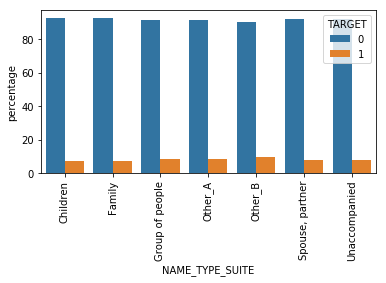

Group summary
     NAME_TYPE_SUITE  TARGET  percentage
0          Children       0   92.623202
1          Children       1    7.376798
2            Family       0   92.505417
3            Family       1    7.494583
4   Group of people       0   91.512915
5   Group of people       1    8.487085
6           Other_A       0   91.224018
7           Other_A       1    8.775982
8           Other_B       0   90.169492
9           Other_B       1    9.830508
10  Spouse, partner       0   92.128408
11  Spouse, partner       1    7.871592
12    Unaccompanied       0   91.816953
13    Unaccompanied       1    8.183047


In [442]:
var_obj = obj.columns
var_n = var_obj[4]
print('Categorical variable name:', var_n)
# % missing value
print('% missing value', app_train[var_n].isnull().sum()/len(app_train[var_n])* 100)
# distribution/frequency
df = pd.concat([app_train[var_n], app_train.TARGET], axis=1)
var= df.groupby([var_n])['TARGET'].value_counts(normalize=True).rename('percentage').mul(100).reset_index().sort_values([var_n])
sns.barplot(x=var_n, y='percentage', hue='TARGET', data=var)
plt.rcParams['figure.figsize'] = 6,3
plt.xticks(rotation='vertical')
plt.show()
print('Group summary\n', var)

Categorical variable name: NAME_INCOME_TYPE
% missing value 0.0


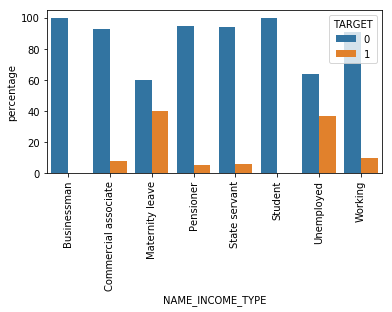

Group summary
         NAME_INCOME_TYPE  TARGET  percentage
0            Businessman       0  100.000000
1   Commercial associate       0   92.515743
2   Commercial associate       1    7.484257
3        Maternity leave       0   60.000000
4        Maternity leave       1   40.000000
5              Pensioner       0   94.613634
6              Pensioner       1    5.386366
7          State servant       0   94.245035
8          State servant       1    5.754965
9                Student       0  100.000000
10            Unemployed       0   63.636364
11            Unemployed       1   36.363636
12               Working       0   90.411528
13               Working       1    9.588472


In [443]:
var_obj = obj.columns
var_n = var_obj[5]
print('Categorical variable name:', var_n)
# % missing value
print('% missing value', app_train[var_n].isnull().sum()/len(app_train[var_n])* 100)
# distribution/frequency
df = pd.concat([app_train[var_n], app_train.TARGET], axis=1)
var= df.groupby([var_n])['TARGET'].value_counts(normalize=True).rename('percentage').mul(100).reset_index().sort_values([var_n])
sns.barplot(x=var_n, y='percentage', hue='TARGET', data=var)
plt.rcParams['figure.figsize'] = 6,3
plt.xticks(rotation='vertical')
plt.show()
print('Group summary\n', var)

100% of businessmen and students repaid the loan in time. Unemployed and women in maternity leave had maximum difficulties in repaying loans 

Categorical variable name: NAME_EDUCATION_TYPE
% missing value 0.0


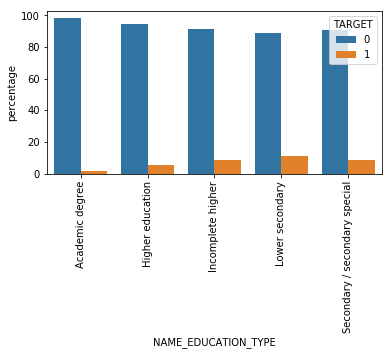

Group summary
              NAME_EDUCATION_TYPE  TARGET  percentage
0                Academic degree       0   98.170732
1                Academic degree       1    1.829268
2               Higher education       0   94.644885
3               Higher education       1    5.355115
4              Incomplete higher       0   91.515034
5              Incomplete higher       1    8.484966
6                Lower secondary       0   89.072327
7                Lower secondary       1   10.927673
8  Secondary / secondary special       0   91.060071
9  Secondary / secondary special       1    8.939929


In [444]:
var_obj = obj.columns
var_n = var_obj[6]
print('Categorical variable name:', var_n)
# % missing value
print('% missing value', app_train[var_n].isnull().sum()/len(app_train[var_n])* 100)
# distribution/frequency
df = pd.concat([app_train[var_n], app_train.TARGET], axis=1)
var= df.groupby([var_n])['TARGET'].value_counts(normalize=True).rename('percentage').mul(100).reset_index().sort_values([var_n])
sns.barplot(x=var_n, y='percentage', hue='TARGET', data=var)
plt.rcParams['figure.figsize'] = 6,3
plt.xticks(rotation='vertical')
plt.show()
print('Group summary\n', var)

People with lower secondary education has more difficulty in repaying loan.

Categorical variable name: NAME_FAMILY_STATUS
% missing value 0.0


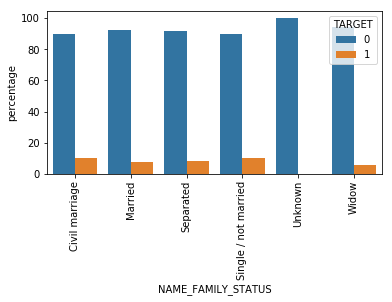

Group summary
       NAME_FAMILY_STATUS  TARGET  percentage
0         Civil marriage       0   90.055416
1         Civil marriage       1    9.944584
2                Married       0   92.440132
3                Married       1    7.559868
4              Separated       0   91.805766
5              Separated       1    8.194234
6   Single / not married       0   90.192325
7   Single / not married       1    9.807675
8                Unknown       0  100.000000
9                  Widow       0   94.175783
10                 Widow       1    5.824217


In [445]:
var_obj = obj.columns
var_n = var_obj[7]
print('Categorical variable name:', var_n)
# % missing value
print('% missing value', app_train[var_n].isnull().sum()/len(app_train[var_n])* 100)
# distribution/frequency
df = pd.concat([app_train[var_n], app_train.TARGET], axis=1)
var= df.groupby([var_n])['TARGET'].value_counts(normalize=True).rename('percentage').mul(100).reset_index().sort_values([var_n])
sns.barplot(x=var_n, y='percentage', hue='TARGET', data=var)
plt.rcParams['figure.figsize'] = 6,3
plt.xticks(rotation='vertical')
plt.show()
print('Group summary\n', var)

People under unknown category had 100% repaid loan in time. The type of category suggests it was not recorded properly and should not be used as an important feature.

Categorical variable name: NAME_HOUSING_TYPE
% missing value 0.0


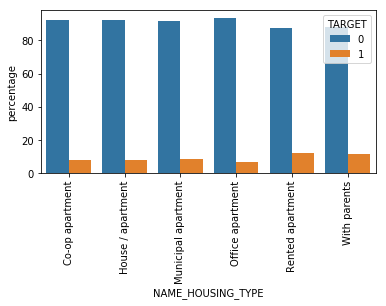

Group summary
       NAME_HOUSING_TYPE  TARGET  percentage
0       Co-op apartment       0   92.067736
1       Co-op apartment       1    7.932264
2     House / apartment       0   92.204289
3     House / apartment       1    7.795711
4   Municipal apartment       0   91.460252
5   Municipal apartment       1    8.539748
6      Office apartment       0   93.427589
7      Office apartment       1    6.572411
8      Rented apartment       0   87.686949
9      Rented apartment       1   12.313051
10         With parents       0   88.301887
11         With parents       1   11.698113


In [446]:
var_obj = obj.columns
var_n = var_obj[8]
print('Categorical variable name:', var_n)
# % missing value
print('% missing value', app_train[var_n].isnull().sum()/len(app_train[var_n])* 100)
# distribution/frequency
df = pd.concat([app_train[var_n], app_train.TARGET], axis=1)
var= df.groupby([var_n])['TARGET'].value_counts(normalize=True).rename('percentage').mul(100).reset_index().sort_values([var_n])
sns.barplot(x=var_n, y='percentage', hue='TARGET', data=var)
plt.rcParams['figure.figsize'] = 6,3
plt.xticks(rotation='vertical')
plt.show()
print('Group summary\n', var)

Among all people with rented apartments and people living with parents had more difficulties to repay the loan but not at significant scale

Categorical variable name: OCCUPATION_TYPE
% missing value 31.345545362604916


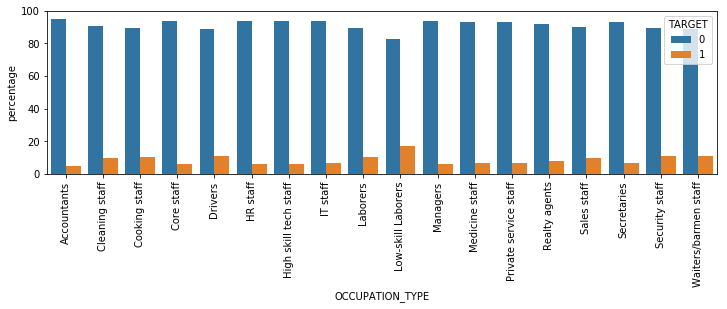

Group summary
           OCCUPATION_TYPE  TARGET  percentage
0             Accountants       0   95.169673
1             Accountants       1    4.830327
2          Cleaning staff       0   90.393295
3          Cleaning staff       1    9.606705
4           Cooking staff       0   89.556004
5           Cooking staff       1   10.443996
6              Core staff       0   93.696046
7              Core staff       1    6.303954
8                 Drivers       0   88.673870
9                 Drivers       1   11.326130
10               HR staff       0   93.605684
11               HR staff       1    6.394316
12  High skill tech staff       0   93.840070
13  High skill tech staff       1    6.159930
14               IT staff       0   93.536122
15               IT staff       1    6.463878
17               Laborers       1   10.578770
16               Laborers       0   89.421230
18     Low-skill Laborers       0   82.847587
19     Low-skill Laborers       1   17.152413
20               Ma

In [451]:
var_obj = obj.columns
var_n = var_obj[9]
print('Categorical variable name:', var_n)
# % missing value
print('% missing value', app_train[var_n].isnull().sum()/len(app_train[var_n])* 100)
# distribution/frequency
df = pd.concat([app_train[var_n], app_train.TARGET], axis=1)
var= df.groupby([var_n])['TARGET'].value_counts(normalize=True).rename('percentage').mul(100).reset_index().sort_values([var_n])
sns.barplot(x=var_n, y='percentage', hue='TARGET', data=var)
plt.rcParams['figure.figsize'] = 12,3
plt.xticks(rotation='vertical')
plt.show()
print('Group summary\n', var)

Occupation type which had difficulties in repaying loans more than 10% times are Low-skill Laborers, Laborers, Drivers, cooking staff, and Waiters/barmen staff reflecting low income group, but again not to great extent.

Categorical variable name: WEEKDAY_APPR_PROCESS_START
% missing value 0.0


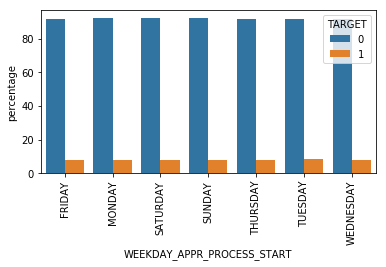

Group summary
    WEEKDAY_APPR_PROCESS_START  TARGET  percentage
0                      FRIDAY       0   91.853073
1                      FRIDAY       1    8.146927
2                      MONDAY       0   92.242773
3                      MONDAY       1    7.757227
4                    SATURDAY       0   92.112726
5                    SATURDAY       1    7.887274
6                      SUNDAY       0   92.070947
7                      SUNDAY       1    7.929053
8                    THURSDAY       0   91.899745
9                    THURSDAY       1    8.100255
10                    TUESDAY       0   91.649506
11                    TUESDAY       1    8.350494
12                  WEDNESDAY       0   91.839643
13                  WEDNESDAY       1    8.160357


In [453]:
var_obj = obj.columns
var_n = var_obj[10]
print('Categorical variable name:', var_n)
# % missing value
print('% missing value', app_train[var_n].isnull().sum()/len(app_train[var_n])* 100)
# distribution/frequency
df = pd.concat([app_train[var_n], app_train.TARGET], axis=1)
var= df.groupby([var_n])['TARGET'].value_counts(normalize=True).rename('percentage').mul(100).reset_index().sort_values([var_n])
sns.barplot(x=var_n, y='percentage', hue='TARGET', data=var)
plt.rcParams['figure.figsize'] = 6,3
plt.xticks(rotation='vertical')
plt.show()
print('Group summary\n', var)

Categorical variable name: ORGANIZATION_TYPE
% missing value 0.0


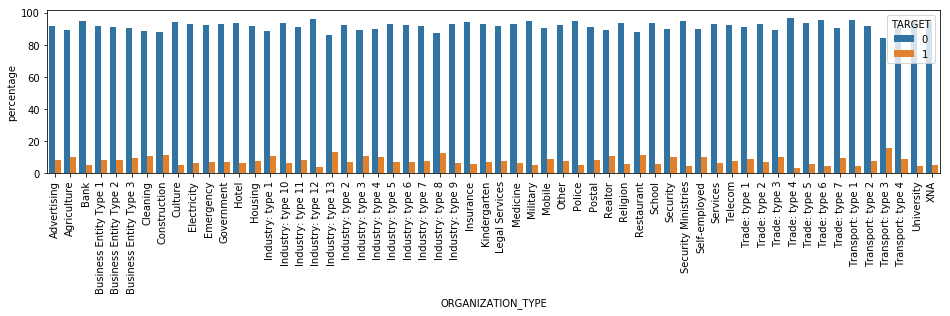

Group summary
           ORGANIZATION_TYPE  TARGET  percentage
115                     XNA       1    5.399646
61                 Medicine       1    6.584472
99            Trade: type 5       1    6.122449
33        Industry: type 11       1    8.653846
67                    Other       1    7.642510
35        Industry: type 12       1    3.794038
97            Trade: type 4       1    3.125000
37        Industry: type 13       1   13.432836
77               Restaurant       1   11.706240
39         Industry: type 2       1    7.205240
41         Industry: type 3       1   10.616229
95            Trade: type 3       1   10.337915
83      Security Ministries       1    4.863222
43         Industry: type 4       1   10.148233
93            Trade: type 2       1    7.000000
45         Industry: type 5       1    6.844741
65                   Mobile       1    9.148265
47         Industry: type 6       1    7.142857
91            Trade: type 1       1    8.908046
49         Industry: type

In [638]:
var_obj = obj.columns
var_n = var_obj[11]
print('Categorical variable name:', var_n)
# % missing value
print('% missing value', app_train[var_n].isnull().sum()/len(app_train[var_n])* 100)
# distribution/frequency
df = pd.concat([app_train[var_n], app_train.TARGET], axis=1)
var= df.groupby([var_n])['TARGET'].value_counts(normalize=True).rename('percentage').mul(100).reset_index().sort_values([var_n])
plt.rcParams['figure.figsize'] = 16,3
sns.barplot(x=var_n, y='percentage', hue='TARGET', data=var)
plt.xticks(rotation='vertical')
plt.show()
print('Group summary\n', var.sort_values(by='TARGET', ascending=False))

People with several organization type had difficulties in repaying loan

Categorical variable name: FONDKAPREMONT_MODE
% missing value 68.38617155158677


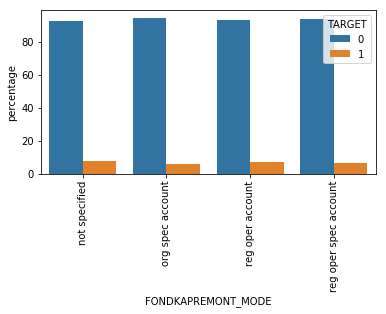

Group summary
       FONDKAPREMONT_MODE  TARGET  percentage
0          not specified       0   92.456480
1          not specified       1    7.543520
2       org spec account       0   94.180459
3       org spec account       1    5.819541
4       reg oper account       0   93.021807
5       reg oper account       1    6.978193
6  reg oper spec account       0   93.443709
7  reg oper spec account       1    6.556291


In [472]:
var_obj = obj.columns
var_n = var_obj[12]
print('Categorical variable name:', var_n)
# % missing value
print('% missing value', app_train[var_n].isnull().sum()/len(app_train[var_n])* 100)
# distribution/frequency
df = pd.concat([app_train[var_n], app_train.TARGET], axis=1)
var= df.groupby([var_n])['TARGET'].value_counts(normalize=True).rename('percentage').mul(100).reset_index().sort_values([var_n])
plt.rcParams['figure.figsize'] = 6,3
sns.barplot(x=var_n, y='percentage', hue='TARGET', data=var)
plt.xticks(rotation='vertical')
plt.show()
print('Group summary\n', var)

Categorical variable name: HOUSETYPE_MODE
% missing value 50.176091261776


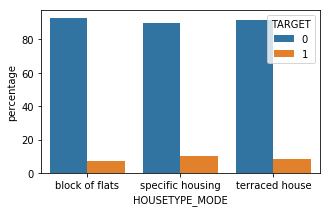

Group summary
      HOUSETYPE_MODE  TARGET  percentage
0    block of flats       0   93.056617
1    block of flats       1    6.943383
2  specific housing       0   89.859907
3  specific housing       1   10.140093
4    terraced house       0   91.501650
5    terraced house       1    8.498350


In [478]:
var_obj = obj.columns
var_n = var_obj[13]
print('Categorical variable name:', var_n)
# % missing value
print('% missing value', app_train[var_n].isnull().sum()/len(app_train[var_n])* 100)
# distribution/frequency
df = pd.concat([app_train[var_n], app_train.TARGET], axis=1)
var= df.groupby([var_n])['TARGET'].value_counts(normalize=True).rename('percentage').mul(100).reset_index().sort_values([var_n])
plt.rcParams['figure.figsize'] = 5,3
sns.barplot(x=var_n, y='percentage', hue='TARGET', data=var)
#plt.xticks(rotation='vertical')
plt.show()
print('Group summary\n', var)

Categorical variable name: WALLSMATERIAL_MODE
% missing value 50.8407829313423


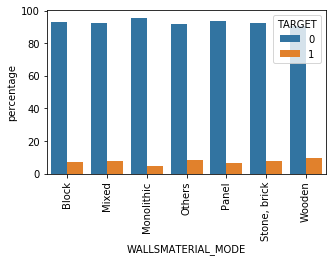

Group summary
    WALLSMATERIAL_MODE  TARGET  percentage
0               Block       0   92.975251
1               Block       1    7.024749
2               Mixed       0   92.465157
3               Mixed       1    7.534843
4          Monolithic       0   95.278246
5          Monolithic       1    4.721754
6              Others       0   91.692308
7              Others       1    8.307692
8               Panel       0   93.652332
9               Panel       1    6.347668
10       Stone, brick       0   92.594307
11       Stone, brick       1    7.405693
12             Wooden       0   90.302126
13             Wooden       1    9.697874


In [475]:
var_obj = obj.columns
var_n = var_obj[14]
print('Categorical variable name:', var_n)
# % missing value
print('% missing value', app_train[var_n].isnull().sum()/len(app_train[var_n])* 100)
# distribution/frequency
df = pd.concat([app_train[var_n], app_train.TARGET], axis=1)
var= df.groupby([var_n])['TARGET'].value_counts(normalize=True).rename('percentage').mul(100).reset_index().sort_values([var_n])
plt.rcParams['figure.figsize'] = 5,3
sns.barplot(x=var_n, y='percentage', hue='TARGET', data=var)
plt.xticks(rotation='vertical')
plt.show()
print('Group summary\n', var)

Categorical variable name: EMERGENCYSTATE_MODE
% missing value 47.39830445089769


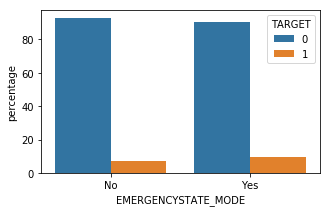

Group summary
   EMERGENCYSTATE_MODE  TARGET  percentage
0                  No       0   93.035100
1                  No       1    6.964900
2                 Yes       0   90.420962
3                 Yes       1    9.579038


In [477]:
var_obj = obj.columns
var_n = var_obj[15]
print('Categorical variable name:', var_n)
# % missing value
print('% missing value', app_train[var_n].isnull().sum()/len(app_train[var_n])* 100)
# distribution/frequency
df = pd.concat([app_train[var_n], app_train.TARGET], axis=1)
var= df.groupby([var_n])['TARGET'].value_counts(normalize=True).rename('percentage').mul(100).reset_index().sort_values([var_n])
plt.rcParams['figure.figsize'] = 5,3
sns.barplot(x=var_n, y='percentage', hue='TARGET', data=var)
#plt.xticks(rotation='vertical')
plt.show()
print('Group summary\n', var)

Among all these variables EXT_SOURCE_1, EXT_SOURCE_2, EXT_SOURCE_3, DAYS_BIRTH, DAYS_EMPLOYED, DAYS_ID_PUBLISH, NAME_INCOME_TYPE, NAME_EDUCATION_TYPE, NAME_HOUSING_TYPE, OCCUPATION_TYPE, ORGANIZATION_TYPE have visible influence on the TARGET. So, these variables are important in predicting the target.

## Dealing with missing values and anomalies: app_train, app_test

Label encoding and One-hot encoding
For categorical variables with unique categories = 2, we will use label encoding, and with unique categories > 2, we will use one-hot encoding. The underlying assumption is keep it the values in one column when unique values = 2. Thus the number of column is same here.

In [72]:
# # fitting and transforming with label encoder in app_train
le = LabelEncoder()
le_count = 0
for col in app_train:
    if app_train[col].dtype == 'object':
        if len(list(app_train[col].unique())) <= 2: # for unique category less/equal 2
            le.fit(app_train[col]) # fitting and transforming with label encoder
            app_train[col] = le.transform(app_train[col])
            app_test[col] = le.transform(app_test[col])
            le_count += 1
print(le_count)

3


In [73]:
## One hot encoding for unique category >2 in app_train
app_train = pd.get_dummies(app_train)
app_test = pd.get_dummies(app_test)
print(app_train.shape, app_test.shape)

(307511, 243) (48744, 239)


In [74]:
## geting rid of excess columns in train dataset
train_labels = app_train['TARGET']
app_train, app_test = app_train.align(app_test, join = 'inner', axis=1)
app_train['TARGET'] = train_labels
print(app_train.shape, app_test.shape)

(307511, 240) (48744, 239)


From HomeCredit_columns_description.csv it is apparent that DAYS_BIRTH, DAYS_EMPLOYED, DAYS_REGISTRATION, DAYS_ID_PUBLISH, DAYS_LAST_PHONE_CHANGE columns are populated with the number of days relative to the application, thus are negative. 

In [75]:
days_columns = pd.concat([app_train.DAYS_BIRTH, app_train.DAYS_EMPLOYED, app_train.DAYS_REGISTRATION, app_train.DAYS_ID_PUBLISH, app_train.DAYS_LAST_PHONE_CHANGE], axis=1)
(days_columns/-365).describe() # summary statistics in terms of years (not days)

,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,DAYS_LAST_PHONE_CHANGE
count,307511.000000,307511.000000,307511.000000,307511.000000,307510.000000
mean,43.936973,-174.835742,13.660604,8.203294,2.637969
std,11.956133,387.056895,9.651743,4.135481,2.265229
min,20.517808,-1000.665753,-0.000000,-0.000000,-0.000000
25%,34.008219,0.791781,5.506849,4.712329,0.750685
50%,43.150685,3.323288,12.339726,8.915068,2.073973
75%,53.923288,7.561644,20.491781,11.778082,4.301370
max,69.120548,49.073973,67.594521,19.717808,11.758904


The average age of applicant ~ 44 years, youngest ~ 21 year, oldest ~ 69 year .. sounds about right.
In employment history the minimum and mean value are -1000 years and -174 years.. not right. But registration, id publish time and last phone change looks about right. 

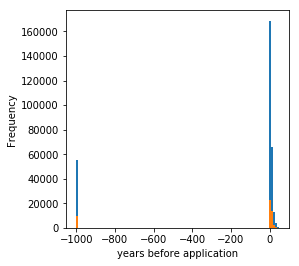

% anomaly in train.DAYS_EMPLOYED: 18.01
% anomaly in test.DAYS_EMPLOYED: 19.03


In [76]:
# distribution of 'DAYS_EMPLOYED' data
(app_train['DAYS_EMPLOYED']/-365).plot.hist(bins=100)
(app_test['DAYS_EMPLOYED']/-365).plot.hist(bins=100)
plt.xlabel('years before application')
plt.show()

print('% anomaly in train.DAYS_EMPLOYED: {:05.2f}'.format(len(app_train[app_train['DAYS_EMPLOYED']== 365243]['DAYS_EMPLOYED'])
                                   /len(app_train['DAYS_EMPLOYED'])*100))
print('% anomaly in test.DAYS_EMPLOYED: {:05.2f}'.format(len(app_test[app_test['DAYS_EMPLOYED']== 365243]['DAYS_EMPLOYED'])
                                   /len(app_test['DAYS_EMPLOYED'])*100))


A large spike can be seen at 1000 caused by anomalies. There anomaly in train and test data are ~ 18% and 19% respectively of total 'DAYS_EMPLOYED.

### Correlation with target

In [77]:
# find correlation of the features with target
correlations =  app_train.corr()['TARGET'].sort_values()
print('Most negative correlations:\n', correlations.head(10), '\n\nMost positive correlations\n', correlations.tail(10))

Most negative correlations:
 EXT_SOURCE_3                           -0.178919
EXT_SOURCE_2                           -0.160472
EXT_SOURCE_1                           -0.155317
NAME_EDUCATION_TYPE_Higher education   -0.056593
CODE_GENDER_F                          -0.054704
NAME_INCOME_TYPE_Pensioner             -0.046209
ORGANIZATION_TYPE_XNA                  -0.045987
DAYS_EMPLOYED                          -0.044932
FLOORSMAX_AVG                          -0.044003
FLOORSMAX_MEDI                         -0.043768
Name: TARGET, dtype: float64 

Most positive correlations
 NAME_EDUCATION_TYPE_Secondary / secondary special    0.049824
REG_CITY_NOT_WORK_CITY                               0.050994
DAYS_ID_PUBLISH                                      0.051457
CODE_GENDER_M                                        0.054713
DAYS_LAST_PHONE_CHANGE                               0.055218
NAME_INCOME_TYPE_Working                             0.057481
REGION_RATING_CLIENT                              

The correlation of any individual variable with the target is not strong. DAYS_BIRTH has strongest positive relation and EXIT_SOURCE_3 has maximum negative correlation. However, if we apply feature engineering the correlation canbe improved.

## Feature Engineering

In [78]:
# Feature engineering by combining several features to have higher correlation with the target
poly_features = app_train[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH', 'TARGET']]
poly_features_test = app_test[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]

# imputer for handling missing values
from sklearn.preprocessing import Imputer
imputer = Imputer(strategy = 'median')
poly_target = poly_features['TARGET']
poly_features = poly_features.drop(columns = ['TARGET']) # seperating TARGET column from train dataset

#replacing missing values (external sources have missing values)
poly_features = imputer.fit_transform(poly_features)
poly_features_test = imputer.fit_transform(poly_features_test)

# create polynomial object
from sklearn.preprocessing import PolynomialFeatures
poly_transformer = PolynomialFeatures(degree = 3)

# train the polynomial features
poly_transformer.fit(poly_features)

# transform the features
poly_features = poly_transformer.transform(poly_features)
poly_features_test = poly_transformer.transform(poly_features_test)
print(poly_features.shape) # we started with 4 variables as poly features and ended with 35
columns = poly_transformer.get_feature_names(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH'])
print(columns[:10]) # new feature names

(307511, 35)
['1', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH', 'EXT_SOURCE_1^2', 'EXT_SOURCE_1 EXT_SOURCE_2', 'EXT_SOURCE_1 EXT_SOURCE_3', 'EXT_SOURCE_1 DAYS_BIRTH', 'EXT_SOURCE_2^2']


We started with 4 features and after transformation we have 35 features which are all possible combination between polynomial features, such as EXT_SOURCE_1^2, EXT_SOURCE_1 EXT_SOURCE_2, EXT_SOURCE_1 EXT_SOURCE_3 etc.

In [79]:
# checking correlation with target
# creating dataframe with new features in train dataset
poly_features = pd.DataFrame(poly_features, columns = columns)
poly_features['TARGET'] = poly_target

# find correlation in train
poly_corrs = poly_features.corr()['TARGET'].sort_values()
print(poly_corrs.head(10), '\n', poly_corrs.tail(10))

EXT_SOURCE_2 EXT_SOURCE_3                -0.193939
EXT_SOURCE_1 EXT_SOURCE_2 EXT_SOURCE_3   -0.189605
EXT_SOURCE_2^2 EXT_SOURCE_3              -0.176428
EXT_SOURCE_2 EXT_SOURCE_3^2              -0.172282
EXT_SOURCE_1 EXT_SOURCE_2                -0.166625
EXT_SOURCE_1 EXT_SOURCE_3                -0.164065
EXT_SOURCE_2                             -0.160295
EXT_SOURCE_1 EXT_SOURCE_2^2              -0.156867
EXT_SOURCE_3                             -0.155892
EXT_SOURCE_1 EXT_SOURCE_3^2              -0.150822
Name: TARGET, dtype: float64 
 EXT_SOURCE_1 DAYS_BIRTH                 0.104882
EXT_SOURCE_3^2 DAYS_BIRTH               0.141777
EXT_SOURCE_2^2 DAYS_BIRTH               0.149313
EXT_SOURCE_3 DAYS_BIRTH                 0.150109
EXT_SOURCE_1 EXT_SOURCE_3 DAYS_BIRTH    0.151816
EXT_SOURCE_1 EXT_SOURCE_2 DAYS_BIRTH    0.155891
EXT_SOURCE_2 DAYS_BIRTH                 0.156873
EXT_SOURCE_2 EXT_SOURCE_3 DAYS_BIRTH    0.181283
TARGET                                  1.000000
1                 

The correlations have improved than earlier. There are several features which are important to understand the financial capacity of a cliet, such as the percentage of the credit amount relative to a client's income (CREDIT_INCOME_PERCENT), the percentage of the loan annuity relative to a client's income (ANNUITY_INCOME_PERCENT), the length of the payment in months (since the annuity is the monthly amount due (CREDIT_TERM), the percentage of the days employed relative to the client's age (DAYS_EMPLOYED_PERCENT) etc. 

In [85]:
app_train_domain = app_train.copy()
app_train_domain['CREDIT_INCOME_PERCENT'] = app_train_domain['AMT_CREDIT'] / app_train_domain['AMT_INCOME_TOTAL']
app_train_domain['ANNUITY_INCOME_PERCENT'] = app_train_domain['AMT_ANNUITY'] / app_train_domain['AMT_INCOME_TOTAL']
app_train_domain['CREDIT_TERM'] = app_train_domain['AMT_ANNUITY'] / app_train_domain['AMT_CREDIT']
app_train_domain['DAYS_EMPLOYED_PERCENT'] = app_train_domain['DAYS_EMPLOYED'] / app_train_domain['DAYS_BIRTH']
domain = pd.concat([app_train_domain['CREDIT_INCOME_PERCENT'], app_train_domain['ANNUITY_INCOME_PERCENT'], app_train_domain['CREDIT_TERM'], app_train_domain['DAYS_EMPLOYED_PERCENT'], app_train_domain['TARGET']], axis=1)
app_test_domain = app_test.copy()
app_test_domain['CREDIT_INCOME_PERCENT'] = app_test_domain['AMT_CREDIT'] / app_test_domain['AMT_INCOME_TOTAL']
app_test_domain['ANNUITY_INCOME_PERCENT'] = app_test_domain['AMT_ANNUITY'] / app_test_domain['AMT_INCOME_TOTAL']
app_test_domain['CREDIT_TERM'] = app_test_domain['AMT_ANNUITY'] / app_test_domain['AMT_CREDIT']
app_test_domain['DAYS_EMPLOYED_PERCENT'] = app_test_domain['DAYS_EMPLOYED'] / app_test_domain['DAYS_BIRTH']
domain_corrs = domain.corr()['TARGET'].sort_values()
print(domain_corrs)

CREDIT_INCOME_PERCENT    -0.007727
CREDIT_TERM               0.012704
ANNUITY_INCOME_PERCENT    0.014265
DAYS_EMPLOYED_PERCENT     0.042206
TARGET                    1.000000
Name: TARGET, dtype: float64


The correlation is not good with engineered features. 

What about other datasets!! Can we include them in train and test dataset and improve the prediction!!

In [88]:
print('bureau', bureau.columns)
print('bureau_bal', bureau_bal.columns)
print('credit balance', credit_bal.columns)
print('installment payment', inst_pay.columns)
print('cash balance', cash_bal.columns)
print('previous application', prev_app.columns)


bureau Index(['SK_ID_CURR', 'SK_ID_BUREAU', 'CREDIT_ACTIVE', 'CREDIT_CURRENCY',
       'DAYS_CREDIT', 'CREDIT_DAY_OVERDUE', 'DAYS_CREDIT_ENDDATE',
       'DAYS_ENDDATE_FACT', 'AMT_CREDIT_MAX_OVERDUE', 'CNT_CREDIT_PROLONG',
       'AMT_CREDIT_SUM', 'AMT_CREDIT_SUM_DEBT', 'AMT_CREDIT_SUM_LIMIT',
       'AMT_CREDIT_SUM_OVERDUE', 'CREDIT_TYPE', 'DAYS_CREDIT_UPDATE',
       'AMT_ANNUITY'],
      dtype='object')
bureau_bal Index(['SK_ID_BUREAU', 'MONTHS_BALANCE', 'STATUS'], dtype='object')
credit balance Index(['SK_ID_PREV', 'SK_ID_CURR', 'MONTHS_BALANCE', 'AMT_BALANCE',
       'AMT_CREDIT_LIMIT_ACTUAL', 'AMT_DRAWINGS_ATM_CURRENT',
       'AMT_DRAWINGS_CURRENT', 'AMT_DRAWINGS_OTHER_CURRENT',
       'AMT_DRAWINGS_POS_CURRENT', 'AMT_INST_MIN_REGULARITY',
       'AMT_PAYMENT_CURRENT', 'AMT_PAYMENT_TOTAL_CURRENT',
       'AMT_RECEIVABLE_PRINCIPAL', 'AMT_RECIVABLE', 'AMT_TOTAL_RECEIVABLE',
       'CNT_DRAWINGS_ATM_CURRENT', 'CNT_DRAWINGS_CURRENT',
       'CNT_DRAWINGS_OTHER_CURRENT', 'CNT_DRAWING

In [96]:
print('Bureau variable types are:\n', bureau.dtypes.value_counts()) # variable type: integer, float, categorical
print('\nbureau balance variable types are:\n', bureau_bal.dtypes.value_counts()) # variable type: integer, float, categorical
print('\nCredit balance variable types are:\n', credit_bal.dtypes.value_counts()) # variable type: integer, float, categorical
print('\nInstallment payment variable types are:\n', inst_pay.dtypes.value_counts()) # variable type: integer, float, categorical
print('\nCash balance variable types are:\n', cash_bal.dtypes.value_counts()) # variable type: integer, float, categorical
print('\nPrevious application variable types are:\n', prev_app.dtypes.value_counts()) # variable type: integer, float, categorical


Bureau variable types are:
 float64    8
int64      6
object     3
dtype: int64

bureau balance variable types are:
 int64     2
object    1
dtype: int64

Credit balance variable types are:
 float64    15
int64       7
object      1
dtype: int64

Installment payment variable types are:
 float64    5
int64      3
dtype: int64

Cash balance variable types are:
 int64      5
float64    2
object     1
dtype: int64

Previous application variable types are:
 object     16
float64    15
int64       6
dtype: int64


In [116]:
bureau_train = pd.merge(app_train, bureau, on='SK_ID_CURR', how='left')
bureau_train.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY_x,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,...,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY_y
0,100002,0,0,1,0,202500.0,406597.5,24700.5,351000.0,0.018801,...,-1038.0,NaN,0.0,40761.0,NaN,NaN,0.0,Credit card,-1038.0,0.0
1,100002,0,0,1,0,202500.0,406597.5,24700.5,351000.0,0.018801,...,-48.0,NaN,0.0,0.0,0.0,NaN,0.0,Credit card,-47.0,NaN
2,100002,0,0,1,0,202500.0,406597.5,24700.5,351000.0,0.018801,...,-1185.0,0.000,0.0,135000.0,0.0,0.0,0.0,Consumer credit,-1185.0,0.0
3,100002,0,0,1,0,202500.0,406597.5,24700.5,351000.0,0.018801,...,-911.0,3321.000,0.0,19071.0,NaN,NaN,0.0,Consumer credit,-906.0,0.0
4,100002,0,0,1,0,202500.0,406597.5,24700.5,351000.0,0.018801,...,-36.0,5043.645,0.0,120735.0,0.0,0.0,0.0,Consumer credit,-34.0,0.0


There are multiple entry for one SKIDCURR in bureau. So the number of rows increased.

In [119]:
app_train.shape

(307511, 240)

In [118]:
credit_bal_train = pd.merge(app_train, credit_bal, on='SK_ID_CURR', how='left')
credit_bal_train.shape

(3448571, 262)

In [120]:
inst_pay_train = pd.merge(app_train, inst_pay, on='SK_ID_CURR', how='left')
inst_pay_train.shape

(11607460, 247)

In [121]:
cash_bal_train = pd.merge(app_train, cash_bal, on='SK_ID_CURR', how='left')
cash_bal_train.shape

(8561442, 247)